In [ ]:
#!pip install torch seaborn pandas sbi

In [1]:
import numpy as np
import os
import tensorflow as tf
import torch
import maxent
from sbi_gravitation import GravitySimulator, sim_wrapper, get_observation_points
from torch.distributions.multivariate_normal import MultivariateNormal
from sbi.inference import infer
import scipy

In [2]:
# set up true parameters
m1 = 100. # solar masses
m2 = 50. # solar masses
m3 = 75 # solar masses
G = 1.90809e5 # solar radius / solar mass * (km/s)^2
v0 = np.array([15.,-40.]) # km/s

true_params = [m1, m2, m3, v0[0], v0[1]]

# set prior means
prior_means = [85., 40., 70., 12., -30.]
prior_cov = np.eye(5) * 50

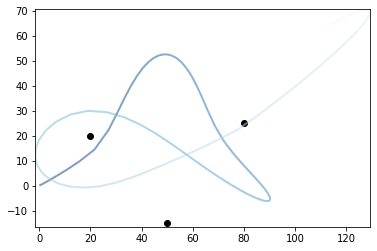

In [3]:
# generate true trajectory and apply some noise to it
if os.path.exists('true_trajectory.txt'):
    true_traj = np.genfromtxt('true_trajectory.txt')
else:
    sim = GravitySimulator(m1, m2, m3, v0, G, random_noise=False)
    true_traj = sim.run()
    np.savetxt('true_trajectory.txt', true_traj)

if os.path.exists('noisy_trajectory.txt'):
    noisy_traj=np.genfromtxt('noisy_trajectory.txt')
else:
    sim = GravitySimulator(m1, m2, m3, v0, G, random_noise=True)
    noisy_traj = sim.run()
    np.savetxt('noisy_trajectory.txt', noisy_traj)

observed_points = get_observation_points(noisy_traj)
observation_summary_stats = observed_points.flatten()
sim = GravitySimulator(m1, m2, m3, v0, G, random_noise=False)
sim.run()
sim.plot_traj()

In [4]:
# perform SNL inference
prior = MultivariateNormal(loc=torch.as_tensor(prior_means),
                            covariance_matrix=torch.as_tensor(torch.eye(5)*50))

posterior = infer(sim_wrapper, prior, method='SNLE', num_simulations=2048, num_workers=16)

Running 2048 simulations in 2048 batches.:   0%|          | 0/2048 [00:00<?, ?it/s]

Neural network successfully converged after 90 epochs.


In [5]:
# sample from SNL posterior
samples = posterior.sample((2000,), x=observation_summary_stats)
snl_data = np.array(samples)
np.savetxt('wide_prior_samples.txt', snl_data)

Generating samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [14:56<00:00,  2.23it/s]


In [66]:
# set up restraints for maxent
# restraint structure: [value, uncertainty, indices... ]
restraints = []
for i, point in enumerate(observed_points):
    value1 = point[0]
    value2 = point[1]
    uncertainty = 25
    index = 20 * i + 19 # based on how we slice in get_observation_points()
    restraints.append([value1, uncertainty, index, 0])
    restraints.append([value2, uncertainty, index, 1])

In [67]:
# set up laplace restraints
laplace_restraints = []

for i in range(len(restraints)):
    traj_index = tuple(restraints[i][2:])
    value = restraints[i][0]
    uncertainty = restraints[i][1]
    p = maxent.EmptyPrior()
    r = maxent.Restraint(lambda traj, i=traj_index: traj[i], value, p)
    laplace_restraints.append(r)

In [8]:
# sample from prior for maxent
np.random.seed(12656)
prior_dist = np.random.multivariate_normal(prior_means, prior_cov, size=2048)
np.save('maxent_prior_samples.npy', prior_dist)

In [9]:
# generate trajectories for maxent from prior samples
trajs = np.zeros([prior_dist.shape[0], 100, 2])

for i, sample in enumerate(prior_dist):
    m1, m2, m3, v0 = sample[0], sample[1], sample[2], sample[3:]
    sim = GravitySimulator(m1, m2, m3, v0, random_noise=False)
    traj = sim.run()
    trajs[i] = traj
    
maxent_trajs = trajs
np.save('maxent_raw_trajectories.npy', trajs)

In [10]:
# run maxent on trajectories
batch_size = prior_dist.shape[0]

model = maxent.MaxentModel(laplace_restraints)
model.compile(tf.keras.optimizers.Adam(1e-4), 'mean_squared_error')
# short burn-in
h = model.fit(trajs, batch_size=batch_size, epochs=5000, verbose=1)
# restart to reset learning rate
h = model.fit(trajs, batch_size=batch_size, epochs=25000, verbose=1)

np.savetxt('maxent_loss.txt', h.history['loss'])

maxent_weights = model.traj_weights
np.savetxt('maxent_traj_weights.txt', maxent_weights)

maxent_avg_traj = np.sum(trajs * maxent_weights[:, np.newaxis, np.newaxis], axis=0)
np.savetxt('maxent_avg_traj.txt', maxent_avg_traj)

2021-08-03 10:32:39.580360: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-03 10:32:40.165738: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5000
1/1 [==============================] - 1s 510ms/step - loss: 1170.8577 - weight-entropy: 7.6246
Epoch 2/5000
1/1 [==============================] - 0s 2ms/step - loss: 736.3901 - weight-entropy: 7.6202
Epoch 3/5000
1/1 [==============================] - 0s 2ms/step - loss: 817.7186 - weight-entropy: 7.5795
Epoch 4/5000
1/1 [==============================] - 0s 3ms/step - loss: 493.1054 - weight-entropy: 7.6052
Epoch 5/5000
1/1 [==============================] - 0s 3ms/step - loss: 585.2890 - weight-entropy: 7.6147
Epoch 6/5000
1/1 [==============================] - 0s 2ms/step - loss: 654.2584 - weight-entropy: 7.6173
Epoch 7/5000
1/1 [==============================] - 0s 3ms/step - loss: 666.2289 - weight-entropy: 7.6172
Epoch 8/5000
1/1 [==============================] - 0s 3ms/step - loss: 637.8702 - weight-entropy: 7.6153
Epoch 9/5000
1/1 [==============================] - 0s 3ms/step - loss: 591.6251 - weight-entropy: 7.6112
Epoch 10/5000
1/1 [========================

1/1 [==============================] - 0s 3ms/step - loss: 454.4503 - weight-entropy: 7.6007
Epoch 154/5000
1/1 [==============================] - 0s 3ms/step - loss: 454.1202 - weight-entropy: 7.6007
Epoch 155/5000
1/1 [==============================] - 0s 2ms/step - loss: 453.7880 - weight-entropy: 7.6006
Epoch 156/5000
1/1 [==============================] - 0s 3ms/step - loss: 453.4539 - weight-entropy: 7.6005
Epoch 157/5000
1/1 [==============================] - 0s 3ms/step - loss: 453.1183 - weight-entropy: 7.6005
Epoch 158/5000
1/1 [==============================] - 0s 2ms/step - loss: 452.7849 - weight-entropy: 7.6004
Epoch 159/5000
1/1 [==============================] - 0s 2ms/step - loss: 452.4481 - weight-entropy: 7.6003
Epoch 160/5000
1/1 [==============================] - 0s 4ms/step - loss: 452.1093 - weight-entropy: 7.6002
Epoch 161/5000
1/1 [==============================] - 0s 2ms/step - loss: 451.7698 - weight-entropy: 7.6002
Epoch 162/5000
1/1 [=======================

Epoch 229/5000
1/1 [==============================] - 0s 3ms/step - loss: 425.9999 - weight-entropy: 7.5924
Epoch 230/5000
1/1 [==============================] - 0s 3ms/step - loss: 425.5818 - weight-entropy: 7.5922
Epoch 231/5000
1/1 [==============================] - 0s 2ms/step - loss: 425.1611 - weight-entropy: 7.5921
Epoch 232/5000
1/1 [==============================] - 0s 4ms/step - loss: 424.7412 - weight-entropy: 7.5919
Epoch 233/5000
1/1 [==============================] - 0s 2ms/step - loss: 424.3176 - weight-entropy: 7.5917
Epoch 234/5000
1/1 [==============================] - 0s 3ms/step - loss: 423.8954 - weight-entropy: 7.5915
Epoch 235/5000
1/1 [==============================] - 0s 3ms/step - loss: 423.4715 - weight-entropy: 7.5914
Epoch 236/5000
1/1 [==============================] - 0s 2ms/step - loss: 423.0460 - weight-entropy: 7.5912
Epoch 237/5000
1/1 [==============================] - 0s 3ms/step - loss: 422.6184 - weight-entropy: 7.5910
Epoch 238/5000
1/1 [========

1/1 [==============================] - 0s 2ms/step - loss: 354.8060 - weight-entropy: 7.5426
Epoch 380/5000
1/1 [==============================] - 0s 3ms/step - loss: 354.3228 - weight-entropy: 7.5421
Epoch 381/5000
1/1 [==============================] - 0s 2ms/step - loss: 353.8395 - weight-entropy: 7.5416
Epoch 382/5000
1/1 [==============================] - 0s 2ms/step - loss: 353.3566 - weight-entropy: 7.5411
Epoch 383/5000
1/1 [==============================] - 0s 2ms/step - loss: 352.8746 - weight-entropy: 7.5406
Epoch 384/5000
1/1 [==============================] - 0s 3ms/step - loss: 352.3920 - weight-entropy: 7.5400
Epoch 385/5000
1/1 [==============================] - 0s 2ms/step - loss: 351.9102 - weight-entropy: 7.5395
Epoch 386/5000
1/1 [==============================] - 0s 2ms/step - loss: 351.4298 - weight-entropy: 7.5390
Epoch 387/5000
1/1 [==============================] - 0s 2ms/step - loss: 350.9503 - weight-entropy: 7.5385
Epoch 388/5000
1/1 [=======================

Epoch 455/5000
1/1 [==============================] - 0s 2ms/step - loss: 319.7461 - weight-entropy: 7.4986
Epoch 456/5000
1/1 [==============================] - 0s 2ms/step - loss: 319.3089 - weight-entropy: 7.4980
Epoch 457/5000
1/1 [==============================] - 0s 3ms/step - loss: 318.8735 - weight-entropy: 7.4973
Epoch 458/5000
1/1 [==============================] - 0s 4ms/step - loss: 318.4378 - weight-entropy: 7.4967
Epoch 459/5000
1/1 [==============================] - 0s 2ms/step - loss: 318.0036 - weight-entropy: 7.4960
Epoch 460/5000
1/1 [==============================] - 0s 3ms/step - loss: 317.5700 - weight-entropy: 7.4953
Epoch 461/5000
1/1 [==============================] - 0s 2ms/step - loss: 317.1366 - weight-entropy: 7.4947
Epoch 462/5000
1/1 [==============================] - 0s 2ms/step - loss: 316.7032 - weight-entropy: 7.4940
Epoch 463/5000
1/1 [==============================] - 0s 2ms/step - loss: 316.2722 - weight-entropy: 7.4934
Epoch 464/5000
1/1 [========

Epoch 606/5000
1/1 [==============================] - 0s 2ms/step - loss: 264.0839 - weight-entropy: 7.3822
Epoch 607/5000
1/1 [==============================] - 0s 3ms/step - loss: 263.8026 - weight-entropy: 7.3814
Epoch 608/5000
1/1 [==============================] - 0s 3ms/step - loss: 263.5229 - weight-entropy: 7.3806
Epoch 609/5000
1/1 [==============================] - 0s 2ms/step - loss: 263.2436 - weight-entropy: 7.3798
Epoch 610/5000
1/1 [==============================] - 0s 3ms/step - loss: 262.9653 - weight-entropy: 7.3790
Epoch 611/5000
1/1 [==============================] - 0s 2ms/step - loss: 262.6895 - weight-entropy: 7.3782
Epoch 612/5000
1/1 [==============================] - 0s 3ms/step - loss: 262.4142 - weight-entropy: 7.3773
Epoch 613/5000
1/1 [==============================] - 0s 4ms/step - loss: 262.1406 - weight-entropy: 7.3765
Epoch 614/5000
1/1 [==============================] - 0s 7ms/step - loss: 261.8672 - weight-entropy: 7.3757
Epoch 615/5000
1/1 [========

Epoch 756/5000
1/1 [==============================] - 0s 2ms/step - loss: 232.6660 - weight-entropy: 7.2780
Epoch 757/5000
1/1 [==============================] - 0s 3ms/step - loss: 232.5058 - weight-entropy: 7.2775
Epoch 758/5000
1/1 [==============================] - 0s 3ms/step - loss: 232.3461 - weight-entropy: 7.2769
Epoch 759/5000
1/1 [==============================] - 0s 2ms/step - loss: 232.1870 - weight-entropy: 7.2764
Epoch 760/5000
1/1 [==============================] - 0s 2ms/step - loss: 232.0278 - weight-entropy: 7.2758
Epoch 761/5000
1/1 [==============================] - 0s 4ms/step - loss: 231.8692 - weight-entropy: 7.2753
Epoch 762/5000
1/1 [==============================] - 0s 3ms/step - loss: 231.7110 - weight-entropy: 7.2747
Epoch 763/5000
1/1 [==============================] - 0s 3ms/step - loss: 231.5532 - weight-entropy: 7.2742
Epoch 764/5000
1/1 [==============================] - 0s 2ms/step - loss: 231.3963 - weight-entropy: 7.2736
Epoch 765/5000
1/1 [========

Epoch 907/5000
1/1 [==============================] - 0s 3ms/step - loss: 211.7071 - weight-entropy: 7.2085
Epoch 908/5000
1/1 [==============================] - 0s 3ms/step - loss: 211.5839 - weight-entropy: 7.2081
Epoch 909/5000
1/1 [==============================] - 0s 2ms/step - loss: 211.4610 - weight-entropy: 7.2077
Epoch 910/5000
1/1 [==============================] - 0s 2ms/step - loss: 211.3383 - weight-entropy: 7.2073
Epoch 911/5000
1/1 [==============================] - 0s 4ms/step - loss: 211.2155 - weight-entropy: 7.2070
Epoch 912/5000
1/1 [==============================] - 0s 4ms/step - loss: 211.0933 - weight-entropy: 7.2066
Epoch 913/5000
1/1 [==============================] - 0s 3ms/step - loss: 210.9707 - weight-entropy: 7.2062
Epoch 914/5000
1/1 [==============================] - 0s 3ms/step - loss: 210.8491 - weight-entropy: 7.2058
Epoch 915/5000
1/1 [==============================] - 0s 3ms/step - loss: 210.7266 - weight-entropy: 7.2054
Epoch 916/5000
1/1 [========

1/1 [==============================] - 0s 3ms/step - loss: 194.6549 - weight-entropy: 7.1561
Epoch 1058/5000
1/1 [==============================] - 0s 2ms/step - loss: 194.5490 - weight-entropy: 7.1558
Epoch 1059/5000
1/1 [==============================] - 0s 3ms/step - loss: 194.4434 - weight-entropy: 7.1555
Epoch 1060/5000
1/1 [==============================] - 0s 3ms/step - loss: 194.3379 - weight-entropy: 7.1552
Epoch 1061/5000
1/1 [==============================] - 0s 2ms/step - loss: 194.2324 - weight-entropy: 7.1549
Epoch 1062/5000
1/1 [==============================] - 0s 3ms/step - loss: 194.1269 - weight-entropy: 7.1546
Epoch 1063/5000
1/1 [==============================] - 0s 3ms/step - loss: 194.0215 - weight-entropy: 7.1543
Epoch 1064/5000
1/1 [==============================] - 0s 3ms/step - loss: 193.9160 - weight-entropy: 7.1539
Epoch 1065/5000
1/1 [==============================] - 0s 3ms/step - loss: 193.8106 - weight-entropy: 7.1536
Epoch 1066/5000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 179.5959 - weight-entropy: 7.1121
Epoch 1208/5000
1/1 [==============================] - 0s 3ms/step - loss: 179.5007 - weight-entropy: 7.1119
Epoch 1209/5000
1/1 [==============================] - 0s 3ms/step - loss: 179.4050 - weight-entropy: 7.1116
Epoch 1210/5000
1/1 [==============================] - 0s 2ms/step - loss: 179.3099 - weight-entropy: 7.1113
Epoch 1211/5000
1/1 [==============================] - 0s 3ms/step - loss: 179.2147 - weight-entropy: 7.1110
Epoch 1212/5000
1/1 [==============================] - 0s 2ms/step - loss: 179.1191 - weight-entropy: 7.1108
Epoch 1213/5000
1/1 [==============================] - 0s 2ms/step - loss: 179.0235 - weight-entropy: 7.1105
Epoch 1214/5000
1/1 [==============================] - 0s 3ms/step - loss: 178.9283 - weight-entropy: 7.1102
Epoch 1215/5000
1/1 [==============================] - 0s 2ms/step - loss: 178.8335 - weight-entropy: 7.1099
Epoch 1216/5000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 165.9162 - weight-entropy: 7.0726
Epoch 1357/5000
1/1 [==============================] - 0s 2ms/step - loss: 165.8281 - weight-entropy: 7.0724
Epoch 1358/5000
1/1 [==============================] - 0s 2ms/step - loss: 165.7401 - weight-entropy: 7.0721
Epoch 1359/5000
1/1 [==============================] - 0s 2ms/step - loss: 165.6516 - weight-entropy: 7.0719
Epoch 1360/5000
1/1 [==============================] - 0s 2ms/step - loss: 165.5632 - weight-entropy: 7.0716
Epoch 1361/5000
1/1 [==============================] - 0s 2ms/step - loss: 165.4748 - weight-entropy: 7.0714
Epoch 1362/5000
1/1 [==============================] - 0s 2ms/step - loss: 165.3867 - weight-entropy: 7.0711
Epoch 1363/5000
1/1 [==============================] - 0s 2ms/step - loss: 165.2988 - weight-entropy: 7.0708
Epoch 1364/5000
1/1 [==============================] - 0s 3ms/step - loss: 165.2109 - weight-entropy: 7.0706
Epoch 1365/5000
1/1 [==============

1/1 [==============================] - 0s 5ms/step - loss: 153.1170 - weight-entropy: 7.0345
Epoch 1507/5000
1/1 [==============================] - 0s 4ms/step - loss: 153.0343 - weight-entropy: 7.0342
Epoch 1508/5000
1/1 [==============================] - 0s 2ms/step - loss: 152.9518 - weight-entropy: 7.0340
Epoch 1509/5000
1/1 [==============================] - 0s 2ms/step - loss: 152.8698 - weight-entropy: 7.0337
Epoch 1510/5000
1/1 [==============================] - 0s 5ms/step - loss: 152.7871 - weight-entropy: 7.0335
Epoch 1511/5000
1/1 [==============================] - 0s 5ms/step - loss: 152.7049 - weight-entropy: 7.0332
Epoch 1512/5000
1/1 [==============================] - 0s 2ms/step - loss: 152.6229 - weight-entropy: 7.0330
Epoch 1513/5000
1/1 [==============================] - 0s 3ms/step - loss: 152.5403 - weight-entropy: 7.0327
Epoch 1514/5000
1/1 [==============================] - 0s 2ms/step - loss: 152.4582 - weight-entropy: 7.0325
Epoch 1515/5000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 141.1452 - weight-entropy: 6.9963
Epoch 1657/5000
1/1 [==============================] - 0s 3ms/step - loss: 141.0681 - weight-entropy: 6.9960
Epoch 1658/5000
1/1 [==============================] - 0s 4ms/step - loss: 140.9909 - weight-entropy: 6.9957
Epoch 1659/5000
1/1 [==============================] - 0s 2ms/step - loss: 140.9139 - weight-entropy: 6.9955
Epoch 1660/5000
1/1 [==============================] - 0s 2ms/step - loss: 140.8366 - weight-entropy: 6.9952
Epoch 1661/5000
1/1 [==============================] - 0s 3ms/step - loss: 140.7596 - weight-entropy: 6.9950
Epoch 1662/5000
1/1 [==============================] - 0s 2ms/step - loss: 140.6825 - weight-entropy: 6.9947
Epoch 1663/5000
1/1 [==============================] - 0s 3ms/step - loss: 140.6055 - weight-entropy: 6.9945
Epoch 1664/5000
1/1 [==============================] - 0s 3ms/step - loss: 140.5284 - weight-entropy: 6.9942
Epoch 1665/5000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 129.9286 - weight-entropy: 6.9569
Epoch 1807/5000
1/1 [==============================] - 0s 3ms/step - loss: 129.8564 - weight-entropy: 6.9567
Epoch 1808/5000
1/1 [==============================] - 0s 2ms/step - loss: 129.7841 - weight-entropy: 6.9564
Epoch 1809/5000
1/1 [==============================] - 0s 2ms/step - loss: 129.7117 - weight-entropy: 6.9561
Epoch 1810/5000
1/1 [==============================] - 0s 2ms/step - loss: 129.6396 - weight-entropy: 6.9559
Epoch 1811/5000
1/1 [==============================] - 0s 2ms/step - loss: 129.5672 - weight-entropy: 6.9556
Epoch 1812/5000
1/1 [==============================] - 0s 2ms/step - loss: 129.4949 - weight-entropy: 6.9553
Epoch 1813/5000
1/1 [==============================] - 0s 2ms/step - loss: 129.4228 - weight-entropy: 6.9551
Epoch 1814/5000
1/1 [==============================] - 0s 3ms/step - loss: 129.3506 - weight-entropy: 6.9548
Epoch 1815/5000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 119.4919 - weight-entropy: 6.9160
Epoch 1956/5000
1/1 [==============================] - 0s 2ms/step - loss: 119.4239 - weight-entropy: 6.9158
Epoch 1957/5000
1/1 [==============================] - 0s 3ms/step - loss: 119.3564 - weight-entropy: 6.9155
Epoch 1958/5000
1/1 [==============================] - 0s 3ms/step - loss: 119.2888 - weight-entropy: 6.9152
Epoch 1959/5000
1/1 [==============================] - 0s 2ms/step - loss: 119.2208 - weight-entropy: 6.9149
Epoch 1960/5000
1/1 [==============================] - 0s 3ms/step - loss: 119.1533 - weight-entropy: 6.9146
Epoch 1961/5000
1/1 [==============================] - 0s 2ms/step - loss: 119.0859 - weight-entropy: 6.9143
Epoch 1962/5000
1/1 [==============================] - 0s 3ms/step - loss: 119.0183 - weight-entropy: 6.9141
Epoch 1963/5000
1/1 [==============================] - 0s 4ms/step - loss: 118.9504 - weight-entropy: 6.9138
Epoch 1964/5000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 109.6621 - weight-entropy: 6.8725
Epoch 2106/5000
1/1 [==============================] - 0s 3ms/step - loss: 109.5987 - weight-entropy: 6.8722
Epoch 2107/5000
1/1 [==============================] - 0s 2ms/step - loss: 109.5354 - weight-entropy: 6.8719
Epoch 2108/5000
1/1 [==============================] - 0s 3ms/step - loss: 109.4724 - weight-entropy: 6.8716
Epoch 2109/5000
1/1 [==============================] - 0s 2ms/step - loss: 109.4090 - weight-entropy: 6.8713
Epoch 2110/5000
1/1 [==============================] - 0s 2ms/step - loss: 109.3457 - weight-entropy: 6.8710
Epoch 2111/5000
1/1 [==============================] - 0s 3ms/step - loss: 109.2825 - weight-entropy: 6.8707
Epoch 2112/5000
1/1 [==============================] - 0s 2ms/step - loss: 109.2197 - weight-entropy: 6.8704
Epoch 2113/5000
1/1 [==============================] - 0s 2ms/step - loss: 109.1563 - weight-entropy: 6.8701
Epoch 2114/5000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 100.5398 - weight-entropy: 6.8266
Epoch 2255/5000
1/1 [==============================] - 0s 3ms/step - loss: 100.4807 - weight-entropy: 6.8263
Epoch 2256/5000
1/1 [==============================] - 0s 3ms/step - loss: 100.4216 - weight-entropy: 6.8259
Epoch 2257/5000
1/1 [==============================] - 0s 2ms/step - loss: 100.3624 - weight-entropy: 6.8256
Epoch 2258/5000
1/1 [==============================] - 0s 3ms/step - loss: 100.3037 - weight-entropy: 6.8253
Epoch 2259/5000
1/1 [==============================] - 0s 3ms/step - loss: 100.2444 - weight-entropy: 6.8250
Epoch 2260/5000
1/1 [==============================] - 0s 2ms/step - loss: 100.1855 - weight-entropy: 6.8247
Epoch 2261/5000
1/1 [==============================] - 0s 2ms/step - loss: 100.1266 - weight-entropy: 6.8243
Epoch 2262/5000
1/1 [==============================] - 0s 2ms/step - loss: 100.0674 - weight-entropy: 6.8240
Epoch 2263/5000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 91.9150 - weight-entropy: 6.7770
Epoch 2406/5000
1/1 [==============================] - 0s 2ms/step - loss: 91.8600 - weight-entropy: 6.7767
Epoch 2407/5000
1/1 [==============================] - 0s 2ms/step - loss: 91.8048 - weight-entropy: 6.7763
Epoch 2408/5000
1/1 [==============================] - 0s 2ms/step - loss: 91.7499 - weight-entropy: 6.7760
Epoch 2409/5000
1/1 [==============================] - 0s 2ms/step - loss: 91.6947 - weight-entropy: 6.7757
Epoch 2410/5000
1/1 [==============================] - 0s 2ms/step - loss: 91.6396 - weight-entropy: 6.7753
Epoch 2411/5000
1/1 [==============================] - 0s 2ms/step - loss: 91.5847 - weight-entropy: 6.7750
Epoch 2412/5000
1/1 [==============================] - 0s 2ms/step - loss: 91.5296 - weight-entropy: 6.7746
Epoch 2413/5000
1/1 [==============================] - 0s 2ms/step - loss: 91.4749 - weight-entropy: 6.7743
Epoch 2414/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 87.7989 - weight-entropy: 6.7509
Epoch 2482/5000
1/1 [==============================] - 0s 2ms/step - loss: 87.7458 - weight-entropy: 6.7505
Epoch 2483/5000
1/1 [==============================] - 0s 3ms/step - loss: 87.6927 - weight-entropy: 6.7502
Epoch 2484/5000
1/1 [==============================] - 0s 2ms/step - loss: 87.6397 - weight-entropy: 6.7498
Epoch 2485/5000
1/1 [==============================] - 0s 5ms/step - loss: 87.5866 - weight-entropy: 6.7495
Epoch 2486/5000
1/1 [==============================] - 0s 3ms/step - loss: 87.5333 - weight-entropy: 6.7491
Epoch 2487/5000
1/1 [==============================] - 0s 4ms/step - loss: 87.4804 - weight-entropy: 6.7488
Epoch 2488/5000
1/1 [==============================] - 0s 4ms/step - loss: 87.4274 - weight-entropy: 6.7484
Epoch 2489/5000
1/1 [==============================] - 0s 2ms/step - loss: 87.3743 - weight-entropy: 6.7481
Epoch 2490/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 83.8280 - weight-entropy: 6.7240
Epoch 2558/5000
1/1 [==============================] - 0s 3ms/step - loss: 83.7766 - weight-entropy: 6.7236
Epoch 2559/5000
1/1 [==============================] - 0s 3ms/step - loss: 83.7253 - weight-entropy: 6.7232
Epoch 2560/5000
1/1 [==============================] - 0s 2ms/step - loss: 83.6741 - weight-entropy: 6.7229
Epoch 2561/5000
1/1 [==============================] - 0s 2ms/step - loss: 83.6227 - weight-entropy: 6.7225
Epoch 2562/5000
1/1 [==============================] - 0s 2ms/step - loss: 83.5716 - weight-entropy: 6.7222
Epoch 2563/5000
1/1 [==============================] - 0s 2ms/step - loss: 83.5204 - weight-entropy: 6.7218
Epoch 2564/5000
1/1 [==============================] - 0s 2ms/step - loss: 83.4691 - weight-entropy: 6.7214
Epoch 2565/5000
1/1 [==============================] - 0s 2ms/step - loss: 83.4180 - weight-entropy: 6.7211
Epoch 2566/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 79.9970 - weight-entropy: 6.6963
Epoch 2634/5000
1/1 [==============================] - 0s 5ms/step - loss: 79.9473 - weight-entropy: 6.6959
Epoch 2635/5000
1/1 [==============================] - 0s 3ms/step - loss: 79.8978 - weight-entropy: 6.6955
Epoch 2636/5000
1/1 [==============================] - 0s 2ms/step - loss: 79.8485 - weight-entropy: 6.6952
Epoch 2637/5000
1/1 [==============================] - 0s 4ms/step - loss: 79.7989 - weight-entropy: 6.6948
Epoch 2638/5000
1/1 [==============================] - 0s 2ms/step - loss: 79.7497 - weight-entropy: 6.6944
Epoch 2639/5000
1/1 [==============================] - 0s 2ms/step - loss: 79.7002 - weight-entropy: 6.6940
Epoch 2640/5000
1/1 [==============================] - 0s 3ms/step - loss: 79.6510 - weight-entropy: 6.6937
Epoch 2641/5000
1/1 [==============================] - 0s 2ms/step - loss: 79.6016 - weight-entropy: 6.6933
Epoch 2642/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 76.3496 - weight-entropy: 6.6682
Epoch 2709/5000
1/1 [==============================] - 0s 2ms/step - loss: 76.3018 - weight-entropy: 6.6678
Epoch 2710/5000
1/1 [==============================] - 0s 3ms/step - loss: 76.2540 - weight-entropy: 6.6674
Epoch 2711/5000
1/1 [==============================] - 0s 3ms/step - loss: 76.2064 - weight-entropy: 6.6671
Epoch 2712/5000
1/1 [==============================] - 0s 2ms/step - loss: 76.1588 - weight-entropy: 6.6667
Epoch 2713/5000
1/1 [==============================] - 0s 2ms/step - loss: 76.1112 - weight-entropy: 6.6663
Epoch 2714/5000
1/1 [==============================] - 0s 3ms/step - loss: 76.0635 - weight-entropy: 6.6659
Epoch 2715/5000
1/1 [==============================] - 0s 8ms/step - loss: 76.0157 - weight-entropy: 6.6655
Epoch 2716/5000
1/1 [==============================] - 0s 3ms/step - loss: 75.9682 - weight-entropy: 6.6652
Epoch 2717/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 72.7845 - weight-entropy: 6.6390
Epoch 2785/5000
1/1 [==============================] - 0s 2ms/step - loss: 72.7386 - weight-entropy: 6.6387
Epoch 2786/5000
1/1 [==============================] - 0s 3ms/step - loss: 72.6924 - weight-entropy: 6.6383
Epoch 2787/5000
1/1 [==============================] - 0s 3ms/step - loss: 72.6465 - weight-entropy: 6.6379
Epoch 2788/5000
1/1 [==============================] - 0s 3ms/step - loss: 72.6006 - weight-entropy: 6.6375
Epoch 2789/5000
1/1 [==============================] - 0s 3ms/step - loss: 72.5547 - weight-entropy: 6.6371
Epoch 2790/5000
1/1 [==============================] - 0s 2ms/step - loss: 72.5087 - weight-entropy: 6.6367
Epoch 2791/5000
1/1 [==============================] - 0s 3ms/step - loss: 72.4628 - weight-entropy: 6.6363
Epoch 2792/5000
1/1 [==============================] - 0s 3ms/step - loss: 72.4169 - weight-entropy: 6.6359
Epoch 2793/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 69.3475 - weight-entropy: 6.6092
Epoch 2861/5000
1/1 [==============================] - 0s 2ms/step - loss: 69.3031 - weight-entropy: 6.6088
Epoch 2862/5000
1/1 [==============================] - 0s 3ms/step - loss: 69.2587 - weight-entropy: 6.6084
Epoch 2863/5000
1/1 [==============================] - 0s 3ms/step - loss: 69.2143 - weight-entropy: 6.6080
Epoch 2864/5000
1/1 [==============================] - 0s 2ms/step - loss: 69.1700 - weight-entropy: 6.6076
Epoch 2865/5000
1/1 [==============================] - 0s 2ms/step - loss: 69.1259 - weight-entropy: 6.6072
Epoch 2866/5000
1/1 [==============================] - 0s 2ms/step - loss: 69.0814 - weight-entropy: 6.6068
Epoch 2867/5000
1/1 [==============================] - 0s 2ms/step - loss: 69.0371 - weight-entropy: 6.6064
Epoch 2868/5000
1/1 [==============================] - 0s 2ms/step - loss: 68.9930 - weight-entropy: 6.6060
Epoch 2869/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 66.0346 - weight-entropy: 6.5787
Epoch 2937/5000
1/1 [==============================] - 0s 3ms/step - loss: 65.9917 - weight-entropy: 6.5783
Epoch 2938/5000
1/1 [==============================] - 0s 2ms/step - loss: 65.9489 - weight-entropy: 6.5779
Epoch 2939/5000
1/1 [==============================] - 0s 2ms/step - loss: 65.9062 - weight-entropy: 6.5775
Epoch 2940/5000
1/1 [==============================] - 0s 2ms/step - loss: 65.8634 - weight-entropy: 6.5771
Epoch 2941/5000
1/1 [==============================] - 0s 2ms/step - loss: 65.8208 - weight-entropy: 6.5767
Epoch 2942/5000
1/1 [==============================] - 0s 2ms/step - loss: 65.7783 - weight-entropy: 6.5763
Epoch 2943/5000
1/1 [==============================] - 0s 2ms/step - loss: 65.7355 - weight-entropy: 6.5759
Epoch 2944/5000
1/1 [==============================] - 0s 3ms/step - loss: 65.6929 - weight-entropy: 6.5755
Epoch 2945/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 59.8076 - weight-entropy: 6.5165
Epoch 3088/5000
1/1 [==============================] - 0s 3ms/step - loss: 59.7681 - weight-entropy: 6.5161
Epoch 3089/5000
1/1 [==============================] - 0s 2ms/step - loss: 59.7285 - weight-entropy: 6.5157
Epoch 3090/5000
1/1 [==============================] - 0s 3ms/step - loss: 59.6886 - weight-entropy: 6.5153
Epoch 3091/5000
1/1 [==============================] - 0s 3ms/step - loss: 59.6490 - weight-entropy: 6.5148
Epoch 3092/5000
1/1 [==============================] - 0s 3ms/step - loss: 59.6093 - weight-entropy: 6.5144
Epoch 3093/5000
1/1 [==============================] - 0s 3ms/step - loss: 59.5698 - weight-entropy: 6.5140
Epoch 3094/5000
1/1 [==============================] - 0s 3ms/step - loss: 59.5302 - weight-entropy: 6.5136
Epoch 3095/5000
1/1 [==============================] - 0s 4ms/step - loss: 59.4907 - weight-entropy: 6.5132
Epoch 3096/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 56.8467 - weight-entropy: 6.4844
Epoch 3164/5000
1/1 [==============================] - 0s 2ms/step - loss: 56.8086 - weight-entropy: 6.4840
Epoch 3165/5000
1/1 [==============================] - 0s 3ms/step - loss: 56.7702 - weight-entropy: 6.4836
Epoch 3166/5000
1/1 [==============================] - 0s 2ms/step - loss: 56.7320 - weight-entropy: 6.4832
Epoch 3167/5000
1/1 [==============================] - 0s 2ms/step - loss: 56.6940 - weight-entropy: 6.4827
Epoch 3168/5000
1/1 [==============================] - 0s 2ms/step - loss: 56.6558 - weight-entropy: 6.4823
Epoch 3169/5000
1/1 [==============================] - 0s 2ms/step - loss: 56.6178 - weight-entropy: 6.4819
Epoch 3170/5000
1/1 [==============================] - 0s 3ms/step - loss: 56.5797 - weight-entropy: 6.4815
Epoch 3171/5000
1/1 [==============================] - 0s 2ms/step - loss: 56.5415 - weight-entropy: 6.4810
Epoch 3172/5000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 53.9979 - weight-entropy: 6.4520
Epoch 3240/5000
1/1 [==============================] - 0s 3ms/step - loss: 53.9611 - weight-entropy: 6.4515
Epoch 3241/5000
1/1 [==============================] - 0s 2ms/step - loss: 53.9244 - weight-entropy: 6.4511
Epoch 3242/5000
1/1 [==============================] - 0s 3ms/step - loss: 53.8877 - weight-entropy: 6.4507
Epoch 3243/5000
1/1 [==============================] - 0s 2ms/step - loss: 53.8511 - weight-entropy: 6.4502
Epoch 3244/5000
1/1 [==============================] - 0s 3ms/step - loss: 53.8144 - weight-entropy: 6.4498
Epoch 3245/5000
1/1 [==============================] - 0s 3ms/step - loss: 53.7777 - weight-entropy: 6.4494
Epoch 3246/5000
1/1 [==============================] - 0s 2ms/step - loss: 53.7412 - weight-entropy: 6.4489
Epoch 3247/5000
1/1 [==============================] - 0s 2ms/step - loss: 53.7045 - weight-entropy: 6.4485
Epoch 3248/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 48.6953 - weight-entropy: 6.3868
Epoch 3390/5000
1/1 [==============================] - 0s 3ms/step - loss: 48.6613 - weight-entropy: 6.3864
Epoch 3391/5000
1/1 [==============================] - 0s 3ms/step - loss: 48.6274 - weight-entropy: 6.3859
Epoch 3392/5000
1/1 [==============================] - 0s 2ms/step - loss: 48.5934 - weight-entropy: 6.3855
Epoch 3393/5000
1/1 [==============================] - 0s 3ms/step - loss: 48.5596 - weight-entropy: 6.3850
Epoch 3394/5000
1/1 [==============================] - 0s 4ms/step - loss: 48.5257 - weight-entropy: 6.3846
Epoch 3395/5000
1/1 [==============================] - 0s 3ms/step - loss: 48.4917 - weight-entropy: 6.3842
Epoch 3396/5000
1/1 [==============================] - 0s 2ms/step - loss: 48.4580 - weight-entropy: 6.3837
Epoch 3397/5000
1/1 [==============================] - 0s 3ms/step - loss: 48.4242 - weight-entropy: 6.3833
Epoch 3398/5000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 46.1662 - weight-entropy: 6.3534
Epoch 3466/5000
1/1 [==============================] - 0s 2ms/step - loss: 46.1337 - weight-entropy: 6.3529
Epoch 3467/5000
1/1 [==============================] - 0s 2ms/step - loss: 46.1011 - weight-entropy: 6.3525
Epoch 3468/5000
1/1 [==============================] - 0s 3ms/step - loss: 46.0687 - weight-entropy: 6.3521
Epoch 3469/5000
1/1 [==============================] - 0s 3ms/step - loss: 46.0360 - weight-entropy: 6.3516
Epoch 3470/5000
1/1 [==============================] - 0s 3ms/step - loss: 46.0034 - weight-entropy: 6.3512
Epoch 3471/5000
1/1 [==============================] - 0s 3ms/step - loss: 45.9710 - weight-entropy: 6.3507
Epoch 3472/5000
1/1 [==============================] - 0s 3ms/step - loss: 45.9385 - weight-entropy: 6.3503
Epoch 3473/5000
1/1 [==============================] - 0s 4ms/step - loss: 45.9061 - weight-entropy: 6.3498
Epoch 3474/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 43.7402 - weight-entropy: 6.3198
Epoch 3542/5000
1/1 [==============================] - 0s 3ms/step - loss: 43.7090 - weight-entropy: 6.3193
Epoch 3543/5000
1/1 [==============================] - 0s 3ms/step - loss: 43.6778 - weight-entropy: 6.3189
Epoch 3544/5000
1/1 [==============================] - 0s 2ms/step - loss: 43.6465 - weight-entropy: 6.3184
Epoch 3545/5000
1/1 [==============================] - 0s 3ms/step - loss: 43.6154 - weight-entropy: 6.3180
Epoch 3546/5000
1/1 [==============================] - 0s 3ms/step - loss: 43.5843 - weight-entropy: 6.3175
Epoch 3547/5000
1/1 [==============================] - 0s 3ms/step - loss: 43.5532 - weight-entropy: 6.3171
Epoch 3548/5000
1/1 [==============================] - 0s 3ms/step - loss: 43.5220 - weight-entropy: 6.3166
Epoch 3549/5000
1/1 [==============================] - 0s 3ms/step - loss: 43.4909 - weight-entropy: 6.3162
Epoch 3550/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 41.4154 - weight-entropy: 6.2860
Epoch 3618/5000
1/1 [==============================] - 0s 3ms/step - loss: 41.3854 - weight-entropy: 6.2855
Epoch 3619/5000
1/1 [==============================] - 0s 3ms/step - loss: 41.3555 - weight-entropy: 6.2851
Epoch 3620/5000
1/1 [==============================] - 0s 3ms/step - loss: 41.3256 - weight-entropy: 6.2846
Epoch 3621/5000
1/1 [==============================] - 0s 2ms/step - loss: 41.2957 - weight-entropy: 6.2842
Epoch 3622/5000
1/1 [==============================] - 0s 3ms/step - loss: 41.2658 - weight-entropy: 6.2837
Epoch 3623/5000
1/1 [==============================] - 0s 2ms/step - loss: 41.2360 - weight-entropy: 6.2833
Epoch 3624/5000
1/1 [==============================] - 0s 4ms/step - loss: 41.2062 - weight-entropy: 6.2829
Epoch 3625/5000
1/1 [==============================] - 0s 2ms/step - loss: 41.1764 - weight-entropy: 6.2824
Epoch 3626/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 39.1892 - weight-entropy: 6.2521
Epoch 3694/5000
1/1 [==============================] - 0s 2ms/step - loss: 39.1606 - weight-entropy: 6.2517
Epoch 3695/5000
1/1 [==============================] - 0s 3ms/step - loss: 39.1320 - weight-entropy: 6.2512
Epoch 3696/5000
1/1 [==============================] - 0s 2ms/step - loss: 39.1033 - weight-entropy: 6.2508
Epoch 3697/5000
1/1 [==============================] - 0s 3ms/step - loss: 39.0747 - weight-entropy: 6.2503
Epoch 3698/5000
1/1 [==============================] - 0s 2ms/step - loss: 39.0462 - weight-entropy: 6.2499
Epoch 3699/5000
1/1 [==============================] - 0s 3ms/step - loss: 39.0176 - weight-entropy: 6.2494
Epoch 3700/5000
1/1 [==============================] - 0s 3ms/step - loss: 38.9891 - weight-entropy: 6.2490
Epoch 3701/5000
1/1 [==============================] - 0s 2ms/step - loss: 38.9606 - weight-entropy: 6.2485
Epoch 3702/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 37.0598 - weight-entropy: 6.2182
Epoch 3770/5000
1/1 [==============================] - 0s 3ms/step - loss: 37.0323 - weight-entropy: 6.2177
Epoch 3771/5000
1/1 [==============================] - 0s 3ms/step - loss: 37.0049 - weight-entropy: 6.2173
Epoch 3772/5000
1/1 [==============================] - 0s 2ms/step - loss: 36.9776 - weight-entropy: 6.2169
Epoch 3773/5000
1/1 [==============================] - 0s 3ms/step - loss: 36.9502 - weight-entropy: 6.2164
Epoch 3774/5000
1/1 [==============================] - 0s 3ms/step - loss: 36.9229 - weight-entropy: 6.2160
Epoch 3775/5000
1/1 [==============================] - 0s 3ms/step - loss: 36.8957 - weight-entropy: 6.2155
Epoch 3776/5000
1/1 [==============================] - 0s 2ms/step - loss: 36.8684 - weight-entropy: 6.2151
Epoch 3777/5000
1/1 [==============================] - 0s 2ms/step - loss: 36.8411 - weight-entropy: 6.2146
Epoch 3778/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 35.0246 - weight-entropy: 6.1843
Epoch 3846/5000
1/1 [==============================] - 0s 2ms/step - loss: 34.9985 - weight-entropy: 6.1838
Epoch 3847/5000
1/1 [==============================] - 0s 2ms/step - loss: 34.9722 - weight-entropy: 6.1834
Epoch 3848/5000
1/1 [==============================] - 0s 2ms/step - loss: 34.9462 - weight-entropy: 6.1830
Epoch 3849/5000
1/1 [==============================] - 0s 2ms/step - loss: 34.9201 - weight-entropy: 6.1825
Epoch 3850/5000
1/1 [==============================] - 0s 2ms/step - loss: 34.8940 - weight-entropy: 6.1821
Epoch 3851/5000
1/1 [==============================] - 0s 2ms/step - loss: 34.8679 - weight-entropy: 6.1816
Epoch 3852/5000
1/1 [==============================] - 0s 4ms/step - loss: 34.8418 - weight-entropy: 6.1812
Epoch 3853/5000
1/1 [==============================] - 0s 3ms/step - loss: 34.8158 - weight-entropy: 6.1807
Epoch 3854/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 33.0815 - weight-entropy: 6.1504
Epoch 3922/5000
1/1 [==============================] - 0s 3ms/step - loss: 33.0566 - weight-entropy: 6.1500
Epoch 3923/5000
1/1 [==============================] - 0s 3ms/step - loss: 33.0315 - weight-entropy: 6.1496
Epoch 3924/5000
1/1 [==============================] - 0s 2ms/step - loss: 33.0066 - weight-entropy: 6.1491
Epoch 3925/5000
1/1 [==============================] - 0s 3ms/step - loss: 32.9817 - weight-entropy: 6.1487
Epoch 3926/5000
1/1 [==============================] - 0s 2ms/step - loss: 32.9568 - weight-entropy: 6.1482
Epoch 3927/5000
1/1 [==============================] - 0s 2ms/step - loss: 32.9319 - weight-entropy: 6.1478
Epoch 3928/5000
1/1 [==============================] - 0s 2ms/step - loss: 32.9070 - weight-entropy: 6.1473
Epoch 3929/5000
1/1 [==============================] - 0s 3ms/step - loss: 32.8821 - weight-entropy: 6.1469
Epoch 3930/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 31.3791 - weight-entropy: 6.1170
Epoch 3997/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.6767 - weight-entropy: 6.1191
Epoch 3998/5000
1/1 [==============================] - 0s 3ms/step - loss: 31.6041 - weight-entropy: 6.1160
Epoch 3999/5000
1/1 [==============================] - 0s 3ms/step - loss: 31.3213 - weight-entropy: 6.1174
Epoch 4000/5000
1/1 [==============================] - 0s 3ms/step - loss: 31.2374 - weight-entropy: 6.1164
Epoch 4001/5000
1/1 [==============================] - 0s 3ms/step - loss: 31.3955 - weight-entropy: 6.1146
Epoch 4002/5000
1/1 [==============================] - 0s 3ms/step - loss: 31.4385 - weight-entropy: 6.1167
Epoch 4003/5000
1/1 [==============================] - 0s 3ms/step - loss: 31.2292 - weight-entropy: 6.1147
Epoch 4004/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.1272 - weight-entropy: 6.1152
Epoch 4005/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 29.6328 - weight-entropy: 6.0890
Epoch 4073/5000
1/1 [==============================] - 0s 5ms/step - loss: 29.6116 - weight-entropy: 6.0885
Epoch 4074/5000
1/1 [==============================] - 0s 2ms/step - loss: 29.5903 - weight-entropy: 6.0882
Epoch 4075/5000
1/1 [==============================] - 0s 3ms/step - loss: 29.5689 - weight-entropy: 6.0877
Epoch 4076/5000
1/1 [==============================] - 0s 3ms/step - loss: 29.5475 - weight-entropy: 6.0874
Epoch 4077/5000
1/1 [==============================] - 0s 2ms/step - loss: 29.5261 - weight-entropy: 6.0870
Epoch 4078/5000
1/1 [==============================] - 0s 4ms/step - loss: 29.5047 - weight-entropy: 6.0866
Epoch 4079/5000
1/1 [==============================] - 0s 2ms/step - loss: 29.4834 - weight-entropy: 6.0862
Epoch 4080/5000
1/1 [==============================] - 0s 4ms/step - loss: 29.4622 - weight-entropy: 6.0858
Epoch 4081/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 28.2309 - weight-entropy: 6.0605
Epoch 4149/5000
1/1 [==============================] - 0s 2ms/step - loss: 28.3026 - weight-entropy: 6.0587
Epoch 4150/5000
1/1 [==============================] - 0s 4ms/step - loss: 28.2158 - weight-entropy: 6.0602
Epoch 4151/5000
1/1 [==============================] - 0s 2ms/step - loss: 28.0554 - weight-entropy: 6.0585
Epoch 4152/5000
1/1 [==============================] - 0s 3ms/step - loss: 28.0337 - weight-entropy: 6.0580
Epoch 4153/5000
1/1 [==============================] - 0s 2ms/step - loss: 28.1116 - weight-entropy: 6.0587
Epoch 4154/5000
1/1 [==============================] - 0s 3ms/step - loss: 28.1140 - weight-entropy: 6.0571
Epoch 4155/5000
1/1 [==============================] - 0s 2ms/step - loss: 28.0308 - weight-entropy: 6.0584
Epoch 4156/5000
1/1 [==============================] - 0s 3ms/step - loss: 27.9395 - weight-entropy: 6.0574
Epoch 4157/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 26.6467 - weight-entropy: 6.0329
Epoch 4225/5000
1/1 [==============================] - 0s 2ms/step - loss: 26.6283 - weight-entropy: 6.0325
Epoch 4226/5000
1/1 [==============================] - 0s 2ms/step - loss: 26.6098 - weight-entropy: 6.0322
Epoch 4227/5000
1/1 [==============================] - 0s 2ms/step - loss: 26.5913 - weight-entropy: 6.0317
Epoch 4228/5000
1/1 [==============================] - 0s 3ms/step - loss: 26.5728 - weight-entropy: 6.0315
Epoch 4229/5000
1/1 [==============================] - 0s 2ms/step - loss: 26.5545 - weight-entropy: 6.0310
Epoch 4230/5000
1/1 [==============================] - 0s 3ms/step - loss: 26.5361 - weight-entropy: 6.0307
Epoch 4231/5000
1/1 [==============================] - 0s 2ms/step - loss: 26.5178 - weight-entropy: 6.0302
Epoch 4232/5000
1/1 [==============================] - 0s 3ms/step - loss: 26.4996 - weight-entropy: 6.0300
Epoch 4233/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 25.3156 - weight-entropy: 6.0074
Epoch 4301/5000
1/1 [==============================] - 0s 2ms/step - loss: 25.3039 - weight-entropy: 6.0068
Epoch 4302/5000
1/1 [==============================] - 0s 3ms/step - loss: 25.2932 - weight-entropy: 6.0067
Epoch 4303/5000
1/1 [==============================] - 0s 2ms/step - loss: 25.2803 - weight-entropy: 6.0059
Epoch 4304/5000
1/1 [==============================] - 0s 2ms/step - loss: 25.2647 - weight-entropy: 6.0060
Epoch 4305/5000
1/1 [==============================] - 0s 2ms/step - loss: 25.2451 - weight-entropy: 6.0053
Epoch 4306/5000
1/1 [==============================] - 0s 2ms/step - loss: 25.2242 - weight-entropy: 6.0054
Epoch 4307/5000
1/1 [==============================] - 0s 2ms/step - loss: 25.2022 - weight-entropy: 6.0046
Epoch 4308/5000
1/1 [==============================] - 0s 2ms/step - loss: 25.1812 - weight-entropy: 6.0045
Epoch 4309/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 24.2045 - weight-entropy: 5.9822
Epoch 4377/5000
1/1 [==============================] - 0s 2ms/step - loss: 24.2634 - weight-entropy: 5.9806
Epoch 4378/5000
1/1 [==============================] - 0s 2ms/step - loss: 24.2358 - weight-entropy: 5.9817
Epoch 4379/5000
1/1 [==============================] - 0s 3ms/step - loss: 24.1132 - weight-entropy: 5.9797
Epoch 4380/5000
1/1 [==============================] - 0s 3ms/step - loss: 24.0215 - weight-entropy: 5.9800
Epoch 4381/5000
1/1 [==============================] - 0s 2ms/step - loss: 24.0047 - weight-entropy: 5.9800
Epoch 4382/5000
1/1 [==============================] - 0s 2ms/step - loss: 24.0479 - weight-entropy: 5.9794
Epoch 4383/5000
1/1 [==============================] - 0s 3ms/step - loss: 24.0909 - weight-entropy: 5.9804
Epoch 4384/5000
1/1 [==============================] - 0s 2ms/step - loss: 24.0674 - weight-entropy: 5.9786
Epoch 4385/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 23.1938 - weight-entropy: 5.9559
Epoch 4453/5000
1/1 [==============================] - 0s 2ms/step - loss: 22.9193 - weight-entropy: 5.9570
Epoch 4454/5000
1/1 [==============================] - 0s 3ms/step - loss: 22.9102 - weight-entropy: 5.9567
Epoch 4455/5000
1/1 [==============================] - 0s 2ms/step - loss: 23.0870 - weight-entropy: 5.9552
Epoch 4456/5000
1/1 [==============================] - 0s 2ms/step - loss: 23.3148 - weight-entropy: 5.9567
Epoch 4457/5000
1/1 [==============================] - 0s 3ms/step - loss: 23.3112 - weight-entropy: 5.9538
Epoch 4458/5000
1/1 [==============================] - 0s 2ms/step - loss: 23.2107 - weight-entropy: 5.9559
Epoch 4459/5000
1/1 [==============================] - 0s 4ms/step - loss: 22.9607 - weight-entropy: 5.9539
Epoch 4460/5000
1/1 [==============================] - 0s 2ms/step - loss: 22.8079 - weight-entropy: 5.9547
Epoch 4461/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 21.8199 - weight-entropy: 5.9340
Epoch 4529/5000
1/1 [==============================] - 0s 2ms/step - loss: 21.8193 - weight-entropy: 5.9333
Epoch 4530/5000
1/1 [==============================] - 0s 3ms/step - loss: 21.8231 - weight-entropy: 5.9336
Epoch 4531/5000
1/1 [==============================] - 0s 3ms/step - loss: 21.8249 - weight-entropy: 5.9326
Epoch 4532/5000
1/1 [==============================] - 0s 3ms/step - loss: 21.8275 - weight-entropy: 5.9331
Epoch 4533/5000
1/1 [==============================] - 0s 3ms/step - loss: 21.8215 - weight-entropy: 5.9319
Epoch 4534/5000
1/1 [==============================] - 0s 2ms/step - loss: 21.8179 - weight-entropy: 5.9326
Epoch 4535/5000
1/1 [==============================] - 0s 3ms/step - loss: 21.8045 - weight-entropy: 5.9313
Epoch 4536/5000
1/1 [==============================] - 0s 2ms/step - loss: 21.7967 - weight-entropy: 5.9320
Epoch 4537/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 20.8449 - weight-entropy: 5.9117
Epoch 4605/5000
1/1 [==============================] - 0s 2ms/step - loss: 20.8716 - weight-entropy: 5.9106
Epoch 4606/5000
1/1 [==============================] - 0s 3ms/step - loss: 20.9409 - weight-entropy: 5.9114
Epoch 4607/5000
1/1 [==============================] - 0s 2ms/step - loss: 21.0496 - weight-entropy: 5.9095
Epoch 4608/5000
1/1 [==============================] - 0s 3ms/step - loss: 21.3137 - weight-entropy: 5.9112
Epoch 4609/5000
1/1 [==============================] - 0s 2ms/step - loss: 21.6311 - weight-entropy: 5.9082
Epoch 4610/5000
1/1 [==============================] - 0s 2ms/step - loss: 22.4639 - weight-entropy: 5.9113
Epoch 4611/5000
1/1 [==============================] - 0s 2ms/step - loss: 22.9579 - weight-entropy: 5.9063
Epoch 4612/5000
1/1 [==============================] - 0s 2ms/step - loss: 24.5391 - weight-entropy: 5.9113
Epoch 4613/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 19.8564 - weight-entropy: 5.8905
Epoch 4681/5000
1/1 [==============================] - 0s 4ms/step - loss: 19.8448 - weight-entropy: 5.8902
Epoch 4682/5000
1/1 [==============================] - 0s 4ms/step - loss: 19.8339 - weight-entropy: 5.8900
Epoch 4683/5000
1/1 [==============================] - 0s 4ms/step - loss: 19.8229 - weight-entropy: 5.8896
Epoch 4684/5000
1/1 [==============================] - 0s 5ms/step - loss: 19.8113 - weight-entropy: 5.8895
Epoch 4685/5000
1/1 [==============================] - 0s 5ms/step - loss: 19.7988 - weight-entropy: 5.8889
Epoch 4686/5000
1/1 [==============================] - 0s 3ms/step - loss: 19.7859 - weight-entropy: 5.8888
Epoch 4687/5000
1/1 [==============================] - 0s 3ms/step - loss: 19.7726 - weight-entropy: 5.8884
Epoch 4688/5000
1/1 [==============================] - 0s 2ms/step - loss: 19.7598 - weight-entropy: 5.8882
Epoch 4689/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 19.3318 - weight-entropy: 5.8689
Epoch 4757/5000
1/1 [==============================] - 0s 3ms/step - loss: 19.0271 - weight-entropy: 5.8678
Epoch 4758/5000
1/1 [==============================] - 0s 2ms/step - loss: 18.9804 - weight-entropy: 5.8681
Epoch 4759/5000
1/1 [==============================] - 0s 2ms/step - loss: 19.1499 - weight-entropy: 5.8688
Epoch 4760/5000
1/1 [==============================] - 0s 3ms/step - loss: 19.2525 - weight-entropy: 5.8665
Epoch 4761/5000
1/1 [==============================] - 0s 2ms/step - loss: 19.2090 - weight-entropy: 5.8677
Epoch 4762/5000
1/1 [==============================] - 0s 2ms/step - loss: 19.0003 - weight-entropy: 5.8663
Epoch 4763/5000
1/1 [==============================] - 0s 3ms/step - loss: 18.8956 - weight-entropy: 5.8671
Epoch 4764/5000
1/1 [==============================] - 0s 4ms/step - loss: 18.9515 - weight-entropy: 5.8675
Epoch 4765/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 18.2143 - weight-entropy: 5.8481
Epoch 4833/5000
1/1 [==============================] - 0s 3ms/step - loss: 18.2489 - weight-entropy: 5.8488
Epoch 4834/5000
1/1 [==============================] - 0s 2ms/step - loss: 18.2868 - weight-entropy: 5.8474
Epoch 4835/5000
1/1 [==============================] - 0s 2ms/step - loss: 18.3742 - weight-entropy: 5.8485
Epoch 4836/5000
1/1 [==============================] - 0s 2ms/step - loss: 18.4546 - weight-entropy: 5.8465
Epoch 4837/5000
1/1 [==============================] - 0s 2ms/step - loss: 18.6478 - weight-entropy: 5.8482
Epoch 4838/5000
1/1 [==============================] - 0s 2ms/step - loss: 18.7743 - weight-entropy: 5.8455
Epoch 4839/5000
1/1 [==============================] - 0s 2ms/step - loss: 19.1226 - weight-entropy: 5.8479
Epoch 4840/5000
1/1 [==============================] - 0s 3ms/step - loss: 19.1911 - weight-entropy: 5.8445
Epoch 4841/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 18.6038 - weight-entropy: 5.8300
Epoch 4909/5000
1/1 [==============================] - 0s 2ms/step - loss: 18.3539 - weight-entropy: 5.8267
Epoch 4910/5000
1/1 [==============================] - 0s 2ms/step - loss: 18.2579 - weight-entropy: 5.8293
Epoch 4911/5000
1/1 [==============================] - 0s 3ms/step - loss: 17.8183 - weight-entropy: 5.8267
Epoch 4912/5000
1/1 [==============================] - 0s 3ms/step - loss: 17.5150 - weight-entropy: 5.8282
Epoch 4913/5000
1/1 [==============================] - 0s 3ms/step - loss: 17.3068 - weight-entropy: 5.8271
Epoch 4914/5000
1/1 [==============================] - 0s 2ms/step - loss: 17.2833 - weight-entropy: 5.8269
Epoch 4915/5000
1/1 [==============================] - 0s 2ms/step - loss: 17.3982 - weight-entropy: 5.8273
Epoch 4916/5000
1/1 [==============================] - 0s 4ms/step - loss: 17.5292 - weight-entropy: 5.8256
Epoch 4917/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 16.5933 - weight-entropy: 5.8096
Epoch 4985/5000
1/1 [==============================] - 0s 2ms/step - loss: 16.5959 - weight-entropy: 5.8089
Epoch 4986/5000
1/1 [==============================] - 0s 3ms/step - loss: 16.6000 - weight-entropy: 5.8092
Epoch 4987/5000
1/1 [==============================] - 0s 2ms/step - loss: 16.6007 - weight-entropy: 5.8084
Epoch 4988/5000
1/1 [==============================] - 0s 2ms/step - loss: 16.6035 - weight-entropy: 5.8088
Epoch 4989/5000
1/1 [==============================] - 0s 2ms/step - loss: 16.6003 - weight-entropy: 5.8078
Epoch 4990/5000
1/1 [==============================] - 0s 4ms/step - loss: 16.6020 - weight-entropy: 5.8083
Epoch 4991/5000
1/1 [==============================] - 0s 4ms/step - loss: 16.5972 - weight-entropy: 5.8073
Epoch 4992/5000
1/1 [==============================] - 0s 2ms/step - loss: 16.6006 - weight-entropy: 5.8079
Epoch 4993/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 15.2462 - weight-entropy: 5.7722
Epoch 136/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.2495 - weight-entropy: 5.7725
Epoch 137/25000
1/1 [==============================] - 0s 5ms/step - loss: 15.2497 - weight-entropy: 5.7716
Epoch 138/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.2533 - weight-entropy: 5.7721
Epoch 139/25000
1/1 [==============================] - 0s 5ms/step - loss: 15.2524 - weight-entropy: 5.7711
Epoch 140/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.2583 - weight-entropy: 5.7716
Epoch 141/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.2589 - weight-entropy: 5.7706
Epoch 142/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.2711 - weight-entropy: 5.7712
Epoch 143/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.2770 - weight-entropy: 5.7700
Epoch 144/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 14.8579 - weight-entropy: 5.7535
Epoch 212/25000
1/1 [==============================] - 0s 3ms/step - loss: 15.0394 - weight-entropy: 5.7549
Epoch 213/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.9921 - weight-entropy: 5.7528
Epoch 214/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.8723 - weight-entropy: 5.7543
Epoch 215/25000
1/1 [==============================] - 0s 2ms/step - loss: 14.6679 - weight-entropy: 5.7529
Epoch 216/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.5577 - weight-entropy: 5.7533
Epoch 217/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.5696 - weight-entropy: 5.7531
Epoch 218/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.6552 - weight-entropy: 5.7522
Epoch 219/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.7410 - weight-entropy: 5.7531
Epoch 220/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 13.9927 - weight-entropy: 5.7369
Epoch 288/25000
1/1 [==============================] - 0s 2ms/step - loss: 13.9874 - weight-entropy: 5.7367
Epoch 289/25000
1/1 [==============================] - 0s 2ms/step - loss: 13.9934 - weight-entropy: 5.7363
Epoch 290/25000
1/1 [==============================] - 0s 2ms/step - loss: 14.0050 - weight-entropy: 5.7365
Epoch 291/25000
1/1 [==============================] - 0s 2ms/step - loss: 14.0144 - weight-entropy: 5.7357
Epoch 292/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.0232 - weight-entropy: 5.7361
Epoch 293/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.0212 - weight-entropy: 5.7352
Epoch 294/25000
1/1 [==============================] - ETA: 0s - loss: 14.0192 - weight-entropy: 5.735 - 0s 3ms/step - loss: 14.0192 - weight-entropy: 5.7357
Epoch 295/25000
1/1 [==============================] - 0s 3ms/step - loss: 14.0064 - weight-entropy: 5

1/1 [==============================] - 0s 4ms/step - loss: 13.4421 - weight-entropy: 5.7204
Epoch 363/25000
1/1 [==============================] - 0s 4ms/step - loss: 13.4321 - weight-entropy: 5.7201
Epoch 364/25000
1/1 [==============================] - 0s 3ms/step - loss: 13.4240 - weight-entropy: 5.7199
Epoch 365/25000
1/1 [==============================] - 0s 5ms/step - loss: 13.4172 - weight-entropy: 5.7197
Epoch 366/25000
1/1 [==============================] - 0s 3ms/step - loss: 13.4115 - weight-entropy: 5.7194
Epoch 367/25000
1/1 [==============================] - 0s 2ms/step - loss: 13.4065 - weight-entropy: 5.7193
Epoch 368/25000
1/1 [==============================] - 0s 2ms/step - loss: 13.4018 - weight-entropy: 5.7189
Epoch 369/25000
1/1 [==============================] - 0s 2ms/step - loss: 13.3978 - weight-entropy: 5.7189
Epoch 370/25000
1/1 [==============================] - 0s 2ms/step - loss: 13.3941 - weight-entropy: 5.7184
Epoch 371/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 12.5518 - weight-entropy: 5.6875
Epoch 514/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.4347 - weight-entropy: 5.6866
Epoch 515/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.4150 - weight-entropy: 5.6865
Epoch 516/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.4701 - weight-entropy: 5.6867
Epoch 517/25000
1/1 [==============================] - 0s 2ms/step - loss: 12.5485 - weight-entropy: 5.6856
Epoch 518/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.6230 - weight-entropy: 5.6865
Epoch 519/25000
1/1 [==============================] - 0s 2ms/step - loss: 12.6200 - weight-entropy: 5.6850
Epoch 520/25000
1/1 [==============================] - 0s 2ms/step - loss: 12.5913 - weight-entropy: 5.6861
Epoch 521/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.5042 - weight-entropy: 5.6848
Epoch 522/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 11.9988 - weight-entropy: 5.6709
Epoch 590/25000
1/1 [==============================] - 0s 2ms/step - loss: 11.9907 - weight-entropy: 5.6713
Epoch 591/25000
1/1 [==============================] - 0s 6ms/step - loss: 11.9812 - weight-entropy: 5.6705
Epoch 592/25000
1/1 [==============================] - 0s 2ms/step - loss: 11.9755 - weight-entropy: 5.6709
Epoch 593/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.9688 - weight-entropy: 5.6701
Epoch 594/25000
1/1 [==============================] - 0s 2ms/step - loss: 11.9664 - weight-entropy: 5.6704
Epoch 595/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.9635 - weight-entropy: 5.6697
Epoch 596/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.9663 - weight-entropy: 5.6701
Epoch 597/25000
1/1 [==============================] - 0s 2ms/step - loss: 11.9689 - weight-entropy: 5.6692
Epoch 598/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 12.1625 - weight-entropy: 5.6544
Epoch 666/25000
1/1 [==============================] - 0s 2ms/step - loss: 12.3459 - weight-entropy: 5.6564
Epoch 667/25000
1/1 [==============================] - 0s 4ms/step - loss: 12.3119 - weight-entropy: 5.6538
Epoch 668/25000
1/1 [==============================] - 0s 4ms/step - loss: 12.4067 - weight-entropy: 5.6560
Epoch 669/25000
1/1 [==============================] - 0s 2ms/step - loss: 12.2122 - weight-entropy: 5.6534
Epoch 670/25000
1/1 [==============================] - 0s 3ms/step - loss: 12.1025 - weight-entropy: 5.6554
Epoch 671/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.8328 - weight-entropy: 5.6534
Epoch 672/25000
1/1 [==============================] - 0s 4ms/step - loss: 11.6410 - weight-entropy: 5.6546
Epoch 673/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.5004 - weight-entropy: 5.6536
Epoch 674/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 11.0924 - weight-entropy: 5.6402
Epoch 742/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.0869 - weight-entropy: 5.6400
Epoch 743/25000
1/1 [==============================] - 0s 2ms/step - loss: 11.0862 - weight-entropy: 5.6400
Epoch 744/25000
1/1 [==============================] - 0s 2ms/step - loss: 11.0884 - weight-entropy: 5.6395
Epoch 745/25000
1/1 [==============================] - 0s 2ms/step - loss: 11.0925 - weight-entropy: 5.6397
Epoch 746/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.0963 - weight-entropy: 5.6391
Epoch 747/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.1016 - weight-entropy: 5.6394
Epoch 748/25000
1/1 [==============================] - 0s 2ms/step - loss: 11.1048 - weight-entropy: 5.6386
Epoch 749/25000
1/1 [==============================] - 0s 2ms/step - loss: 11.1112 - weight-entropy: 5.6390
Epoch 750/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 11.2070 - weight-entropy: 5.6243
Epoch 818/25000
1/1 [==============================] - 0s 3ms/step - loss: 11.0702 - weight-entropy: 5.6259
Epoch 819/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.8796 - weight-entropy: 5.6243
Epoch 820/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.7533 - weight-entropy: 5.6251
Epoch 821/25000
1/1 [==============================] - 0s 2ms/step - loss: 10.6868 - weight-entropy: 5.6244
Epoch 822/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.6878 - weight-entropy: 5.6242
Epoch 823/25000
1/1 [==============================] - 0s 2ms/step - loss: 10.7359 - weight-entropy: 5.6245
Epoch 824/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.7939 - weight-entropy: 5.6234
Epoch 825/25000
1/1 [==============================] - 0s 4ms/step - loss: 10.8466 - weight-entropy: 5.6243
Epoch 826/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 10.4164 - weight-entropy: 5.6106
Epoch 894/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.3868 - weight-entropy: 5.6111
Epoch 895/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.3528 - weight-entropy: 5.6104
Epoch 896/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.3280 - weight-entropy: 5.6106
Epoch 897/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.3147 - weight-entropy: 5.6103
Epoch 898/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.3122 - weight-entropy: 5.6100
Epoch 899/25000
1/1 [==============================] - 0s 2ms/step - loss: 10.3173 - weight-entropy: 5.6101
Epoch 900/25000
1/1 [==============================] - 0s 2ms/step - loss: 10.3251 - weight-entropy: 5.6095
Epoch 901/25000
1/1 [==============================] - 0s 2ms/step - loss: 10.3334 - weight-entropy: 5.6098
Epoch 902/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 10.0636 - weight-entropy: 5.5964
Epoch 970/25000
1/1 [==============================] - 0s 2ms/step - loss: 10.0614 - weight-entropy: 5.5970
Epoch 971/25000
1/1 [==============================] - 0s 3ms/step - loss: 10.0465 - weight-entropy: 5.5961
Epoch 972/25000
1/1 [==============================] - 0s 5ms/step - loss: 10.0312 - weight-entropy: 5.5966
Epoch 973/25000
1/1 [==============================] - 0s 2ms/step - loss: 10.0112 - weight-entropy: 5.5958
Epoch 974/25000
1/1 [==============================] - 0s 2ms/step - loss: 9.9940 - weight-entropy: 5.5962
Epoch 975/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.9779 - weight-entropy: 5.5956
Epoch 976/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.9653 - weight-entropy: 5.5957
Epoch 977/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.9553 - weight-entropy: 5.5953
Epoch 978/25000
1/1 [===========================

1/1 [==============================] - 0s 3ms/step - loss: 9.3672 - weight-entropy: 5.5701
Epoch 1120/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.3630 - weight-entropy: 5.5698
Epoch 1121/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.3590 - weight-entropy: 5.5697
Epoch 1122/25000
1/1 [==============================] - 0s 2ms/step - loss: 9.3550 - weight-entropy: 5.5694
Epoch 1123/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.3511 - weight-entropy: 5.5694
Epoch 1124/25000
1/1 [==============================] - 0s 3ms/step - loss: 9.3473 - weight-entropy: 5.5691
Epoch 1125/25000
1/1 [==============================] - 0s 2ms/step - loss: 9.3436 - weight-entropy: 5.5690
Epoch 1126/25000
1/1 [==============================] - 0s 2ms/step - loss: 9.3401 - weight-entropy: 5.5687
Epoch 1127/25000
1/1 [==============================] - 0s 2ms/step - loss: 9.3366 - weight-entropy: 5.5686
Epoch 1128/25000
1/1 [=======================

Epoch 1270/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.8223 - weight-entropy: 5.5448
Epoch 1271/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.8265 - weight-entropy: 5.5448
Epoch 1272/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.8562 - weight-entropy: 5.5440
Epoch 1273/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.8886 - weight-entropy: 5.5448
Epoch 1274/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.8989 - weight-entropy: 5.5436
Epoch 1275/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.8915 - weight-entropy: 5.5445
Epoch 1276/25000
1/1 [==============================] - 0s 4ms/step - loss: 8.8615 - weight-entropy: 5.5434
Epoch 1277/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.8297 - weight-entropy: 5.5440
Epoch 1278/25000
1/1 [==============================] - 0s 4ms/step - loss: 8.8024 - weight-entropy: 5.5433
Epoch 1279/25000
1/1 [======

1/1 [==============================] - 0s 3ms/step - loss: 8.3630 - weight-entropy: 5.5205
Epoch 1422/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.3497 - weight-entropy: 5.5210
Epoch 1423/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.3381 - weight-entropy: 5.5203
Epoch 1424/25000
1/1 [==============================] - 0s 4ms/step - loss: 8.3290 - weight-entropy: 5.5205
Epoch 1425/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.3220 - weight-entropy: 5.5201
Epoch 1426/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.3168 - weight-entropy: 5.5201
Epoch 1427/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.3128 - weight-entropy: 5.5199
Epoch 1428/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.3098 - weight-entropy: 5.5197
Epoch 1429/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.3076 - weight-entropy: 5.5196
Epoch 1430/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 8.1068 - weight-entropy: 5.4997
Epoch 1573/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.0608 - weight-entropy: 5.4971
Epoch 1574/25000
1/1 [==============================] - 0s 2ms/step - loss: 8.0094 - weight-entropy: 5.4991
Epoch 1575/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.9549 - weight-entropy: 5.4973
Epoch 1576/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.9155 - weight-entropy: 5.4983
Epoch 1577/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.8942 - weight-entropy: 5.4976
Epoch 1578/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.8908 - weight-entropy: 5.4975
Epoch 1579/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.9006 - weight-entropy: 5.4978
Epoch 1580/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.9171 - weight-entropy: 5.4968
Epoch 1581/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 7.7238 - weight-entropy: 5.4878
Epoch 1649/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.7448 - weight-entropy: 5.4885
Epoch 1650/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.7637 - weight-entropy: 5.4872
Epoch 1651/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.7757 - weight-entropy: 5.4884
Epoch 1652/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.7734 - weight-entropy: 5.4869
Epoch 1653/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.7636 - weight-entropy: 5.4881
Epoch 1654/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.7448 - weight-entropy: 5.4868
Epoch 1655/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.7256 - weight-entropy: 5.4876
Epoch 1656/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.7073 - weight-entropy: 5.4867
Epoch 1657/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 7.7419 - weight-entropy: 5.4793
Epoch 1725/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.7196 - weight-entropy: 5.4763
Epoch 1726/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.6661 - weight-entropy: 5.4787
Epoch 1727/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.5940 - weight-entropy: 5.4767
Epoch 1728/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.5400 - weight-entropy: 5.4778
Epoch 1729/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.5159 - weight-entropy: 5.4772
Epoch 1730/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.5219 - weight-entropy: 5.4768
Epoch 1731/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.5470 - weight-entropy: 5.4776
Epoch 1732/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.5753 - weight-entropy: 5.4761
Epoch 1733/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 7.3150 - weight-entropy: 5.4577
Epoch 1876/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.3978 - weight-entropy: 5.4602
Epoch 1877/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.4405 - weight-entropy: 5.4569
Epoch 1878/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.4493 - weight-entropy: 5.4602
Epoch 1879/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.4020 - weight-entropy: 5.4569
Epoch 1880/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.3385 - weight-entropy: 5.4596
Epoch 1881/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.2647 - weight-entropy: 5.4572
Epoch 1882/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.2091 - weight-entropy: 5.4586
Epoch 1883/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.1788 - weight-entropy: 5.4578
Epoch 1884/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 7.1186 - weight-entropy: 5.4510
Epoch 1952/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.0744 - weight-entropy: 5.4495
Epoch 1953/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.0434 - weight-entropy: 5.4502
Epoch 1954/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.0304 - weight-entropy: 5.4498
Epoch 1955/25000
1/1 [==============================] - 0s 4ms/step - loss: 7.0343 - weight-entropy: 5.4495
Epoch 1956/25000
1/1 [==============================] - 0s 4ms/step - loss: 7.0487 - weight-entropy: 5.4500
Epoch 1957/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.0655 - weight-entropy: 5.4489
Epoch 1958/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.0803 - weight-entropy: 5.4500
Epoch 1959/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.0863 - weight-entropy: 5.4486
Epoch 1960/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 6.8898 - weight-entropy: 5.4416
Epoch 2028/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.8924 - weight-entropy: 5.4411
Epoch 2029/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.8977 - weight-entropy: 5.4416
Epoch 2030/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.9044 - weight-entropy: 5.4407
Epoch 2031/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.9127 - weight-entropy: 5.4415
Epoch 2032/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.9214 - weight-entropy: 5.4404
Epoch 2033/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.9326 - weight-entropy: 5.4414
Epoch 2034/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.9440 - weight-entropy: 5.4400
Epoch 2035/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.9607 - weight-entropy: 5.4413
Epoch 2036/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 7.1359 - weight-entropy: 5.4235
Epoch 2179/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.1713 - weight-entropy: 5.4274
Epoch 2180/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.1371 - weight-entropy: 5.4232
Epoch 2181/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.1211 - weight-entropy: 5.4272
Epoch 2182/25000
1/1 [==============================] - 0s 4ms/step - loss: 7.0402 - weight-entropy: 5.4231
Epoch 2183/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.9705 - weight-entropy: 5.4268
Epoch 2184/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.8674 - weight-entropy: 5.4234
Epoch 2185/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.7802 - weight-entropy: 5.4261
Epoch 2186/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.6987 - weight-entropy: 5.4238
Epoch 2187/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 6.5710 - weight-entropy: 5.4176
Epoch 2255/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.5242 - weight-entropy: 5.4187
Epoch 2256/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.4964 - weight-entropy: 5.4180
Epoch 2257/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.4924 - weight-entropy: 5.4180
Epoch 2258/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.5066 - weight-entropy: 5.4183
Epoch 2259/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.5285 - weight-entropy: 5.4173
Epoch 2260/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.5499 - weight-entropy: 5.4184
Epoch 2261/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.5614 - weight-entropy: 5.4170
Epoch 2262/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.5653 - weight-entropy: 5.4182
Epoch 2263/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 6.4803 - weight-entropy: 5.4118
Epoch 2331/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.4678 - weight-entropy: 5.4101
Epoch 2332/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.4600 - weight-entropy: 5.4115
Epoch 2333/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.4501 - weight-entropy: 5.4100
Epoch 2334/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.4449 - weight-entropy: 5.4113
Epoch 2335/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.4387 - weight-entropy: 5.4098
Epoch 2336/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.4371 - weight-entropy: 5.4111
Epoch 2337/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.4351 - weight-entropy: 5.4096
Epoch 2338/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.4384 - weight-entropy: 5.4109
Epoch 2339/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 6.3667 - weight-entropy: 5.4033
Epoch 2407/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.3906 - weight-entropy: 5.4048
Epoch 2408/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.4137 - weight-entropy: 5.4029
Epoch 2409/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.4534 - weight-entropy: 5.4048
Epoch 2410/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.4901 - weight-entropy: 5.4025
Epoch 2411/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.5537 - weight-entropy: 5.4049
Epoch 2412/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.6061 - weight-entropy: 5.4020
Epoch 2413/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.7002 - weight-entropy: 5.4050
Epoch 2414/25000
1/1 [==============================] - 0s 4ms/step - loss: 6.7641 - weight-entropy: 5.4015
Epoch 2415/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 6.0889 - weight-entropy: 5.3917
Epoch 2558/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.0984 - weight-entropy: 5.3907
Epoch 2559/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.1132 - weight-entropy: 5.3917
Epoch 2560/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.1297 - weight-entropy: 5.3904
Epoch 2561/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.1562 - weight-entropy: 5.3916
Epoch 2562/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.1845 - weight-entropy: 5.3900
Epoch 2563/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.2316 - weight-entropy: 5.3917
Epoch 2564/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.2779 - weight-entropy: 5.3896
Epoch 2565/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.3583 - weight-entropy: 5.3918
Epoch 2566/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 7.0745 - weight-entropy: 5.3768
Epoch 2709/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.4321 - weight-entropy: 5.3821
Epoch 2710/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.4430 - weight-entropy: 5.3760
Epoch 2711/25000
1/1 [==============================] - 0s 3ms/step - loss: 7.5644 - weight-entropy: 5.3826
Epoch 2712/25000
1/1 [==============================] - 0s 2ms/step - loss: 7.2240 - weight-entropy: 5.3756
Epoch 2713/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.8859 - weight-entropy: 5.3825
Epoch 2714/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.3864 - weight-entropy: 5.3764
Epoch 2715/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.0198 - weight-entropy: 5.3809
Epoch 2716/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.8579 - weight-entropy: 5.3784
Epoch 2717/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.8881 - weight-entropy: 5.3750
Epoch 2785/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.8721 - weight-entropy: 5.3731
Epoch 2786/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.8549 - weight-entropy: 5.3747
Epoch 2787/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.8308 - weight-entropy: 5.3732
Epoch 2788/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.8101 - weight-entropy: 5.3743
Epoch 2789/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.7896 - weight-entropy: 5.3733
Epoch 2790/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.7739 - weight-entropy: 5.3739
Epoch 2791/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.7614 - weight-entropy: 5.3733
Epoch 2792/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.7529 - weight-entropy: 5.3736
Epoch 2793/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.7311 - weight-entropy: 5.3689
Epoch 2861/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.7255 - weight-entropy: 5.3685
Epoch 2862/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.7212 - weight-entropy: 5.3688
Epoch 2863/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.7126 - weight-entropy: 5.3682
Epoch 2864/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.7062 - weight-entropy: 5.3688
Epoch 2865/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.6980 - weight-entropy: 5.3679
Epoch 2866/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.6907 - weight-entropy: 5.3687
Epoch 2867/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.6828 - weight-entropy: 5.3679
Epoch 2868/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.6758 - weight-entropy: 5.3684
Epoch 2869/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 5.6309 - weight-entropy: 5.3641
Epoch 2937/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.6033 - weight-entropy: 5.3633
Epoch 2938/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5869 - weight-entropy: 5.3640
Epoch 2939/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5798 - weight-entropy: 5.3632
Epoch 2940/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5801 - weight-entropy: 5.3636
Epoch 2941/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5860 - weight-entropy: 5.3634
Epoch 2942/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5957 - weight-entropy: 5.3631
Epoch 2943/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.6085 - weight-entropy: 5.3636
Epoch 2944/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.6210 - weight-entropy: 5.3626
Epoch 2945/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.4575 - weight-entropy: 5.3546
Epoch 3088/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.4984 - weight-entropy: 5.3536
Epoch 3089/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5154 - weight-entropy: 5.3543
Epoch 3090/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5280 - weight-entropy: 5.3540
Epoch 3091/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5239 - weight-entropy: 5.3533
Epoch 3092/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5233 - weight-entropy: 5.3546
Epoch 3093/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5099 - weight-entropy: 5.3527
Epoch 3094/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4893 - weight-entropy: 5.3545
Epoch 3095/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4625 - weight-entropy: 5.3529
Epoch 3096/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 6.2939 - weight-entropy: 5.3475
Epoch 3164/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.3339 - weight-entropy: 5.3509
Epoch 3165/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.1296 - weight-entropy: 5.3472
Epoch 3166/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.9671 - weight-entropy: 5.3510
Epoch 3167/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.7103 - weight-entropy: 5.3474
Epoch 3168/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5119 - weight-entropy: 5.3505
Epoch 3169/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.3813 - weight-entropy: 5.3481
Epoch 3170/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.3457 - weight-entropy: 5.3494
Epoch 3171/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.3896 - weight-entropy: 5.3491
Epoch 3172/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 5.6843 - weight-entropy: 5.3393
Epoch 3314/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.7023 - weight-entropy: 5.3438
Epoch 3315/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.6539 - weight-entropy: 5.3370
Epoch 3316/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5787 - weight-entropy: 5.3445
Epoch 3317/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4146 - weight-entropy: 5.3381
Epoch 3318/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.2846 - weight-entropy: 5.3414
Epoch 3319/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.3090 - weight-entropy: 5.3418
Epoch 3320/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4412 - weight-entropy: 5.3378
Epoch 3321/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.5336 - weight-entropy: 5.3440
Epoch 3322/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 5.2106 - weight-entropy: 5.3365
Epoch 3390/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.2346 - weight-entropy: 5.3359
Epoch 3391/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.2785 - weight-entropy: 5.3366
Epoch 3392/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.3252 - weight-entropy: 5.3356
Epoch 3393/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.4162 - weight-entropy: 5.3365
Epoch 3394/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5034 - weight-entropy: 5.3354
Epoch 3395/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.6899 - weight-entropy: 5.3365
Epoch 3396/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.8290 - weight-entropy: 5.3351
Epoch 3397/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.1694 - weight-entropy: 5.3365
Epoch 3398/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 5.3659 - weight-entropy: 5.3313
Epoch 3466/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4135 - weight-entropy: 5.3341
Epoch 3467/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.3566 - weight-entropy: 5.3304
Epoch 3468/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.2600 - weight-entropy: 5.3344
Epoch 3469/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.1534 - weight-entropy: 5.3307
Epoch 3470/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0884 - weight-entropy: 5.3333
Epoch 3471/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0812 - weight-entropy: 5.3320
Epoch 3472/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.1216 - weight-entropy: 5.3315
Epoch 3473/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.1805 - weight-entropy: 5.3334
Epoch 3474/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 5.3095 - weight-entropy: 5.3281
Epoch 3542/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4438 - weight-entropy: 5.3285
Epoch 3543/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5330 - weight-entropy: 5.3277
Epoch 3544/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.7582 - weight-entropy: 5.3286
Epoch 3545/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.8467 - weight-entropy: 5.3273
Epoch 3546/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.1320 - weight-entropy: 5.3288
Epoch 3547/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.1000 - weight-entropy: 5.3269
Epoch 3548/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.2532 - weight-entropy: 5.3290
Epoch 3549/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.9825 - weight-entropy: 5.3266
Epoch 3550/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.9512 - weight-entropy: 5.3244
Epoch 3618/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.9925 - weight-entropy: 5.3262
Epoch 3619/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.0355 - weight-entropy: 5.3227
Epoch 3620/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.0440 - weight-entropy: 5.3267
Epoch 3621/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.0040 - weight-entropy: 5.3229
Epoch 3622/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.9540 - weight-entropy: 5.3255
Epoch 3623/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.9258 - weight-entropy: 5.3243
Epoch 3624/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.9321 - weight-entropy: 5.3238
Epoch 3625/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9573 - weight-entropy: 5.3255
Epoch 3626/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.8970 - weight-entropy: 5.3211
Epoch 3694/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.9127 - weight-entropy: 5.3203
Epoch 3695/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9361 - weight-entropy: 5.3212
Epoch 3696/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9646 - weight-entropy: 5.3201
Epoch 3697/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0124 - weight-entropy: 5.3210
Epoch 3698/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0696 - weight-entropy: 5.3202
Epoch 3699/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.1834 - weight-entropy: 5.3206
Epoch 3700/25000
1/1 [==============================] - 0s 4ms/step - loss: 5.2937 - weight-entropy: 5.3204
Epoch 3701/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5449 - weight-entropy: 5.3202
Epoch 3702/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.8986 - weight-entropy: 5.3158
Epoch 3770/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.9006 - weight-entropy: 5.3188
Epoch 3771/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9339 - weight-entropy: 5.3168
Epoch 3772/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9489 - weight-entropy: 5.3171
Epoch 3773/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.9610 - weight-entropy: 5.3184
Epoch 3774/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.9504 - weight-entropy: 5.3156
Epoch 3775/25000
1/1 [==============================] - 0s 5ms/step - loss: 4.9269 - weight-entropy: 5.3191
Epoch 3776/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8859 - weight-entropy: 5.3155
Epoch 3777/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8480 - weight-entropy: 5.3183
Epoch 3778/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.7734 - weight-entropy: 5.3145
Epoch 3846/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7715 - weight-entropy: 5.3131
Epoch 3847/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7718 - weight-entropy: 5.3140
Epoch 3848/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7759 - weight-entropy: 5.3135
Epoch 3849/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.7881 - weight-entropy: 5.3134
Epoch 3850/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8053 - weight-entropy: 5.3139
Epoch 3851/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8376 - weight-entropy: 5.3129
Epoch 3852/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8716 - weight-entropy: 5.3140
Epoch 3853/25000
1/1 [==============================] - 0s 5ms/step - loss: 4.9399 - weight-entropy: 5.3126
Epoch 3854/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 5.0304 - weight-entropy: 5.3096
Epoch 3922/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9233 - weight-entropy: 5.3118
Epoch 3923/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8093 - weight-entropy: 5.3089
Epoch 3924/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7638 - weight-entropy: 5.3120
Epoch 3925/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7803 - weight-entropy: 5.3092
Epoch 3926/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8116 - weight-entropy: 5.3110
Epoch 3927/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8403 - weight-entropy: 5.3103
Epoch 3928/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8275 - weight-entropy: 5.3096
Epoch 3929/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8073 - weight-entropy: 5.3114
Epoch 3930/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.6944 - weight-entropy: 5.3081
Epoch 3998/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6948 - weight-entropy: 5.3061
Epoch 3999/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6915 - weight-entropy: 5.3077
Epoch 4000/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6883 - weight-entropy: 5.3065
Epoch 4001/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6939 - weight-entropy: 5.3070
Epoch 4002/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7061 - weight-entropy: 5.3070
Epoch 4003/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7365 - weight-entropy: 5.3062
Epoch 4004/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7673 - weight-entropy: 5.3075
Epoch 4005/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8300 - weight-entropy: 5.3057
Epoch 4006/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.9484 - weight-entropy: 5.3036
Epoch 4074/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8483 - weight-entropy: 5.3049
Epoch 4075/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7208 - weight-entropy: 5.3025
Epoch 4076/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6725 - weight-entropy: 5.3056
Epoch 4077/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6962 - weight-entropy: 5.3023
Epoch 4078/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7312 - weight-entropy: 5.3049
Epoch 4079/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7542 - weight-entropy: 5.3033
Epoch 4080/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7211 - weight-entropy: 5.3034
Epoch 4081/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6905 - weight-entropy: 5.3047
Epoch 4082/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.5892 - weight-entropy: 5.3014
Epoch 4150/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5948 - weight-entropy: 5.3000
Epoch 4151/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.6022 - weight-entropy: 5.3010
Epoch 4152/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6106 - weight-entropy: 5.3003
Epoch 4153/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6327 - weight-entropy: 5.3004
Epoch 4154/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6579 - weight-entropy: 5.3007
Epoch 4155/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7148 - weight-entropy: 5.2997
Epoch 4156/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.7643 - weight-entropy: 5.3011
Epoch 4157/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8816 - weight-entropy: 5.2992
Epoch 4158/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.9390 - weight-entropy: 5.2973
Epoch 4226/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7282 - weight-entropy: 5.2989
Epoch 4227/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5992 - weight-entropy: 5.2960
Epoch 4228/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6421 - weight-entropy: 5.2996
Epoch 4229/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7522 - weight-entropy: 5.2960
Epoch 4230/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7411 - weight-entropy: 5.2985
Epoch 4231/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6810 - weight-entropy: 5.2977
Epoch 4232/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5955 - weight-entropy: 5.2965
Epoch 4233/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5841 - weight-entropy: 5.2993
Epoch 4234/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.4602 - weight-entropy: 5.2946
Epoch 4302/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4782 - weight-entropy: 5.2949
Epoch 4303/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4941 - weight-entropy: 5.2940
Epoch 4304/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.5068 - weight-entropy: 5.2951
Epoch 4305/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5100 - weight-entropy: 5.2938
Epoch 4306/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5110 - weight-entropy: 5.2948
Epoch 4307/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5067 - weight-entropy: 5.2940
Epoch 4308/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5092 - weight-entropy: 5.2943
Epoch 4309/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.5111 - weight-entropy: 5.2945
Epoch 4310/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.4013 - weight-entropy: 5.2884
Epoch 4453/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4151 - weight-entropy: 5.2888
Epoch 4454/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4298 - weight-entropy: 5.2887
Epoch 4455/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4618 - weight-entropy: 5.2883
Epoch 4456/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4932 - weight-entropy: 5.2891
Epoch 4457/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5644 - weight-entropy: 5.2877
Epoch 4458/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.6230 - weight-entropy: 5.2894
Epoch 4459/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7693 - weight-entropy: 5.2872
Epoch 4460/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.8590 - weight-entropy: 5.2896
Epoch 4461/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.4491 - weight-entropy: 5.2869
Epoch 4529/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5056 - weight-entropy: 5.2857
Epoch 4530/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4767 - weight-entropy: 5.2857
Epoch 4531/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4272 - weight-entropy: 5.2868
Epoch 4532/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.3725 - weight-entropy: 5.2848
Epoch 4533/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3472 - weight-entropy: 5.2872
Epoch 4534/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3497 - weight-entropy: 5.2847
Epoch 4535/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3651 - weight-entropy: 5.2866
Epoch 4536/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3861 - weight-entropy: 5.2855
Epoch 4537/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.4902 - weight-entropy: 5.2822
Epoch 4605/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5334 - weight-entropy: 5.2839
Epoch 4606/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6556 - weight-entropy: 5.2821
Epoch 4607/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7241 - weight-entropy: 5.2838
Epoch 4608/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9410 - weight-entropy: 5.2819
Epoch 4609/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0070 - weight-entropy: 5.2838
Epoch 4610/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.3171 - weight-entropy: 5.2817
Epoch 4611/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.2753 - weight-entropy: 5.2837
Epoch 4612/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.5294 - weight-entropy: 5.2816
Epoch 4613/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.2196 - weight-entropy: 5.2780
Epoch 4756/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.2452 - weight-entropy: 5.2774
Epoch 4757/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2769 - weight-entropy: 5.2779
Epoch 4758/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3395 - weight-entropy: 5.2773
Epoch 4759/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4085 - weight-entropy: 5.2779
Epoch 4760/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5586 - weight-entropy: 5.2769
Epoch 4761/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6909 - weight-entropy: 5.2782
Epoch 4762/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0313 - weight-entropy: 5.2763
Epoch 4763/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.2060 - weight-entropy: 5.2785
Epoch 4764/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.1357 - weight-entropy: 5.2730
Epoch 4907/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1290 - weight-entropy: 5.2721
Epoch 4908/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1212 - weight-entropy: 5.2731
Epoch 4909/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1171 - weight-entropy: 5.2720
Epoch 4910/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1124 - weight-entropy: 5.2730
Epoch 4911/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1103 - weight-entropy: 5.2720
Epoch 4912/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1082 - weight-entropy: 5.2728
Epoch 4913/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1091 - weight-entropy: 5.2720
Epoch 4914/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1109 - weight-entropy: 5.2726
Epoch 4915/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.4315 - weight-entropy: 5.2696
Epoch 4983/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.5851 - weight-entropy: 5.2705
Epoch 4984/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9637 - weight-entropy: 5.2690
Epoch 4985/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.1930 - weight-entropy: 5.2708
Epoch 4986/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.9489 - weight-entropy: 5.2682
Epoch 4987/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.9555 - weight-entropy: 5.2711
Epoch 4988/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.7535 - weight-entropy: 5.2678
Epoch 4989/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.9478 - weight-entropy: 5.2709
Epoch 4990/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.7142 - weight-entropy: 5.2687
Epoch 4991/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.0341 - weight-entropy: 5.2680
Epoch 5059/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0629 - weight-entropy: 5.2674
Epoch 5060/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0880 - weight-entropy: 5.2678
Epoch 5061/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1077 - weight-entropy: 5.2675
Epoch 5062/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1040 - weight-entropy: 5.2675
Epoch 5063/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0939 - weight-entropy: 5.2676
Epoch 5064/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0697 - weight-entropy: 5.2674
Epoch 5065/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0476 - weight-entropy: 5.2675
Epoch 5066/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.0275 - weight-entropy: 5.2674
Epoch 5067/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.2135 - weight-entropy: 5.2647
Epoch 5135/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2690 - weight-entropy: 5.2656
Epoch 5136/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4060 - weight-entropy: 5.2644
Epoch 5137/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4905 - weight-entropy: 5.2659
Epoch 5138/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7425 - weight-entropy: 5.2638
Epoch 5139/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8166 - weight-entropy: 5.2662
Epoch 5140/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.1788 - weight-entropy: 5.2632
Epoch 5141/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.1005 - weight-entropy: 5.2664
Epoch 5142/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.3691 - weight-entropy: 5.2631
Epoch 5143/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.9737 - weight-entropy: 5.2608
Epoch 5286/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9725 - weight-entropy: 5.2600
Epoch 5287/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9648 - weight-entropy: 5.2609
Epoch 5288/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9628 - weight-entropy: 5.2599
Epoch 5289/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9568 - weight-entropy: 5.2607
Epoch 5290/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9572 - weight-entropy: 5.2599
Epoch 5291/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9556 - weight-entropy: 5.2605
Epoch 5292/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9613 - weight-entropy: 5.2600
Epoch 5293/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9658 - weight-entropy: 5.2604
Epoch 5294/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.8912 - weight-entropy: 5.2578
Epoch 5362/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1116 - weight-entropy: 5.2590
Epoch 5363/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4773 - weight-entropy: 5.2573
Epoch 5364/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4884 - weight-entropy: 5.2587
Epoch 5365/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.3627 - weight-entropy: 5.2579
Epoch 5366/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0424 - weight-entropy: 5.2578
Epoch 5367/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9068 - weight-entropy: 5.2589
Epoch 5368/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9962 - weight-entropy: 5.2573
Epoch 5369/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1441 - weight-entropy: 5.2588
Epoch 5370/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.9164 - weight-entropy: 5.2561
Epoch 5438/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9209 - weight-entropy: 5.2555
Epoch 5439/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9151 - weight-entropy: 5.2562
Epoch 5440/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9160 - weight-entropy: 5.2553
Epoch 5441/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9092 - weight-entropy: 5.2563
Epoch 5442/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9106 - weight-entropy: 5.2552
Epoch 5443/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9065 - weight-entropy: 5.2562
Epoch 5444/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9119 - weight-entropy: 5.2552
Epoch 5445/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9132 - weight-entropy: 5.2560
Epoch 5446/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.8015 - weight-entropy: 5.2536
Epoch 5514/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8013 - weight-entropy: 5.2534
Epoch 5515/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8014 - weight-entropy: 5.2535
Epoch 5516/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8020 - weight-entropy: 5.2534
Epoch 5517/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8036 - weight-entropy: 5.2533
Epoch 5518/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8068 - weight-entropy: 5.2535
Epoch 5519/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8133 - weight-entropy: 5.2531
Epoch 5520/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8247 - weight-entropy: 5.2536
Epoch 5521/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8477 - weight-entropy: 5.2529
Epoch 5522/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.9523 - weight-entropy: 5.2513
Epoch 5590/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9999 - weight-entropy: 5.2512
Epoch 5591/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0244 - weight-entropy: 5.2517
Epoch 5592/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0954 - weight-entropy: 5.2506
Epoch 5593/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1080 - weight-entropy: 5.2520
Epoch 5594/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1800 - weight-entropy: 5.2504
Epoch 5595/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1575 - weight-entropy: 5.2518
Epoch 5596/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.1989 - weight-entropy: 5.2507
Epoch 5597/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1395 - weight-entropy: 5.2513
Epoch 5598/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.8621 - weight-entropy: 5.2491
Epoch 5666/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8871 - weight-entropy: 5.2497
Epoch 5667/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8607 - weight-entropy: 5.2492
Epoch 5668/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8220 - weight-entropy: 5.2492
Epoch 5669/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.7788 - weight-entropy: 5.2496
Epoch 5670/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7541 - weight-entropy: 5.2488
Epoch 5671/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7453 - weight-entropy: 5.2498
Epoch 5672/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.7482 - weight-entropy: 5.2488
Epoch 5673/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.7586 - weight-entropy: 5.2493
Epoch 5674/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.8210 - weight-entropy: 5.2465
Epoch 5742/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8918 - weight-entropy: 5.2475
Epoch 5743/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0480 - weight-entropy: 5.2461
Epoch 5744/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.2358 - weight-entropy: 5.2477
Epoch 5745/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7137 - weight-entropy: 5.2455
Epoch 5746/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.1025 - weight-entropy: 5.2481
Epoch 5747/25000
1/1 [==============================] - 0s 3ms/step - loss: 6.3575 - weight-entropy: 5.2446
Epoch 5748/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.5607 - weight-entropy: 5.2483
Epoch 5749/25000
1/1 [==============================] - 0s 3ms/step - loss: 8.3964 - weight-entropy: 5.2440
Epoch 5750/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.7047 - weight-entropy: 5.2450
Epoch 5818/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7478 - weight-entropy: 5.2450
Epoch 5819/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7946 - weight-entropy: 5.2446
Epoch 5820/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8109 - weight-entropy: 5.2452
Epoch 5821/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8160 - weight-entropy: 5.2444
Epoch 5822/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7824 - weight-entropy: 5.2452
Epoch 5823/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7487 - weight-entropy: 5.2444
Epoch 5824/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7100 - weight-entropy: 5.2450
Epoch 5825/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6853 - weight-entropy: 5.2446
Epoch 5826/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.6911 - weight-entropy: 5.2433
Epoch 5894/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7119 - weight-entropy: 5.2430
Epoch 5895/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7335 - weight-entropy: 5.2427
Epoch 5896/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7431 - weight-entropy: 5.2435
Epoch 5897/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7579 - weight-entropy: 5.2421
Epoch 5898/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7541 - weight-entropy: 5.2437
Epoch 5899/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7574 - weight-entropy: 5.2420
Epoch 5900/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7455 - weight-entropy: 5.2435
Epoch 5901/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7458 - weight-entropy: 5.2422
Epoch 5902/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.6215 - weight-entropy: 5.2405
Epoch 5970/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6257 - weight-entropy: 5.2408
Epoch 5971/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6340 - weight-entropy: 5.2404
Epoch 5972/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6486 - weight-entropy: 5.2408
Epoch 5973/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6783 - weight-entropy: 5.2402
Epoch 5974/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7264 - weight-entropy: 5.2410
Epoch 5975/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8317 - weight-entropy: 5.2398
Epoch 5976/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9829 - weight-entropy: 5.2412
Epoch 5977/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.3546 - weight-entropy: 5.2392
Epoch 5978/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 3.9156 - weight-entropy: 5.2382
Epoch 6046/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8925 - weight-entropy: 5.2393
Epoch 6047/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9127 - weight-entropy: 5.2378
Epoch 6048/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8595 - weight-entropy: 5.2394
Epoch 6049/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8401 - weight-entropy: 5.2379
Epoch 6050/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7701 - weight-entropy: 5.2390
Epoch 6051/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7242 - weight-entropy: 5.2382
Epoch 6052/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6672 - weight-entropy: 5.2386
Epoch 6053/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6275 - weight-entropy: 5.2385
Epoch 6054/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.6096 - weight-entropy: 5.2372
Epoch 6122/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5717 - weight-entropy: 5.2371
Epoch 6123/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5998 - weight-entropy: 5.2367
Epoch 6124/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6557 - weight-entropy: 5.2373
Epoch 6125/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6873 - weight-entropy: 5.2367
Epoch 6126/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6919 - weight-entropy: 5.2368
Epoch 6127/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6586 - weight-entropy: 5.2372
Epoch 6128/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6277 - weight-entropy: 5.2362
Epoch 6129/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5952 - weight-entropy: 5.2375
Epoch 6130/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 5.2701 - weight-entropy: 5.2329
Epoch 6198/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.1802 - weight-entropy: 5.2359
Epoch 6199/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.6924 - weight-entropy: 5.2328
Epoch 6200/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.0706 - weight-entropy: 5.2357
Epoch 6201/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8788 - weight-entropy: 5.2334
Epoch 6202/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1302 - weight-entropy: 5.2351
Epoch 6203/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6996 - weight-entropy: 5.2344
Epoch 6204/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5425 - weight-entropy: 5.2344
Epoch 6205/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6874 - weight-entropy: 5.2350
Epoch 6206/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.5240 - weight-entropy: 5.2304
Epoch 6349/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5390 - weight-entropy: 5.2316
Epoch 6350/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5600 - weight-entropy: 5.2304
Epoch 6351/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5764 - weight-entropy: 5.2313
Epoch 6352/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6069 - weight-entropy: 5.2305
Epoch 6353/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6282 - weight-entropy: 5.2311
Epoch 6354/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6737 - weight-entropy: 5.2303
Epoch 6355/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7020 - weight-entropy: 5.2313
Epoch 6356/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7778 - weight-entropy: 5.2299
Epoch 6357/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.5485 - weight-entropy: 5.2293
Epoch 6425/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6656 - weight-entropy: 5.2287
Epoch 6426/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.6978 - weight-entropy: 5.2293
Epoch 6427/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6737 - weight-entropy: 5.2287
Epoch 6428/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5697 - weight-entropy: 5.2292
Epoch 6429/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4903 - weight-entropy: 5.2288
Epoch 6430/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4630 - weight-entropy: 5.2290
Epoch 6431/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4901 - weight-entropy: 5.2290
Epoch 6432/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5432 - weight-entropy: 5.2287
Epoch 6433/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.7407 - weight-entropy: 5.2263
Epoch 6501/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7934 - weight-entropy: 5.2278
Epoch 6502/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9510 - weight-entropy: 5.2260
Epoch 6503/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0280 - weight-entropy: 5.2279
Epoch 6504/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.3008 - weight-entropy: 5.2257
Epoch 6505/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3586 - weight-entropy: 5.2280
Epoch 6506/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7312 - weight-entropy: 5.2254
Epoch 6507/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.6343 - weight-entropy: 5.2280
Epoch 6508/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.9052 - weight-entropy: 5.2253
Epoch 6509/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.4380 - weight-entropy: 5.2254
Epoch 6577/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4351 - weight-entropy: 5.2254
Epoch 6578/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5138 - weight-entropy: 5.2252
Epoch 6579/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5818 - weight-entropy: 5.2255
Epoch 6580/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6072 - weight-entropy: 5.2250
Epoch 6581/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5445 - weight-entropy: 5.2255
Epoch 6582/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4740 - weight-entropy: 5.2250
Epoch 6583/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4202 - weight-entropy: 5.2254
Epoch 6584/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4106 - weight-entropy: 5.2250
Epoch 6585/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.4265 - weight-entropy: 5.2237
Epoch 6653/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4462 - weight-entropy: 5.2231
Epoch 6654/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4621 - weight-entropy: 5.2237
Epoch 6655/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4893 - weight-entropy: 5.2229
Epoch 6656/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5099 - weight-entropy: 5.2237
Epoch 6657/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5542 - weight-entropy: 5.2227
Epoch 6658/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5862 - weight-entropy: 5.2239
Epoch 6659/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6660 - weight-entropy: 5.2223
Epoch 6660/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7166 - weight-entropy: 5.2240
Epoch 6661/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.8749 - weight-entropy: 5.2221
Epoch 6729/25000
1/1 [==============================] - 0s 7ms/step - loss: 3.7751 - weight-entropy: 5.2211
Epoch 6730/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.5181 - weight-entropy: 5.2218
Epoch 6731/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3804 - weight-entropy: 5.2216
Epoch 6732/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4064 - weight-entropy: 5.2214
Epoch 6733/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5278 - weight-entropy: 5.2218
Epoch 6734/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6443 - weight-entropy: 5.2211
Epoch 6735/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6125 - weight-entropy: 5.2218
Epoch 6736/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5280 - weight-entropy: 5.2212
Epoch 6737/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.4124 - weight-entropy: 5.2201
Epoch 6805/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4081 - weight-entropy: 5.2194
Epoch 6806/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3981 - weight-entropy: 5.2200
Epoch 6807/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3963 - weight-entropy: 5.2193
Epoch 6808/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3915 - weight-entropy: 5.2200
Epoch 6809/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3951 - weight-entropy: 5.2193
Epoch 6810/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3969 - weight-entropy: 5.2199
Epoch 6811/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4094 - weight-entropy: 5.2192
Epoch 6812/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4205 - weight-entropy: 5.2199
Epoch 6813/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.7482 - weight-entropy: 5.2191
Epoch 6881/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6444 - weight-entropy: 5.2166
Epoch 6882/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9720 - weight-entropy: 5.2186
Epoch 6883/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5648 - weight-entropy: 5.2175
Epoch 6884/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3289 - weight-entropy: 5.2180
Epoch 6885/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3700 - weight-entropy: 5.2181
Epoch 6886/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5921 - weight-entropy: 5.2173
Epoch 6887/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7506 - weight-entropy: 5.2184
Epoch 6888/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8363 - weight-entropy: 5.2172
Epoch 6889/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.3048 - weight-entropy: 5.2160
Epoch 6957/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3201 - weight-entropy: 5.2164
Epoch 6958/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3384 - weight-entropy: 5.2159
Epoch 6959/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3518 - weight-entropy: 5.2165
Epoch 6960/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3704 - weight-entropy: 5.2157
Epoch 6961/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3806 - weight-entropy: 5.2165
Epoch 6962/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4023 - weight-entropy: 5.2156
Epoch 6963/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4143 - weight-entropy: 5.2165
Epoch 6964/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4478 - weight-entropy: 5.2155
Epoch 6965/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 4.0950 - weight-entropy: 5.2150
Epoch 7033/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4072 - weight-entropy: 5.2144
Epoch 7034/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3142 - weight-entropy: 5.2142
Epoch 7035/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7147 - weight-entropy: 5.2150
Epoch 7036/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.2425 - weight-entropy: 5.2136
Epoch 7037/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0751 - weight-entropy: 5.2149
Epoch 7038/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7421 - weight-entropy: 5.2141
Epoch 7039/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3471 - weight-entropy: 5.2144
Epoch 7040/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.3468 - weight-entropy: 5.2147
Epoch 7041/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.5888 - weight-entropy: 5.2102
Epoch 7184/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7073 - weight-entropy: 5.2118
Epoch 7185/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.0155 - weight-entropy: 5.2097
Epoch 7186/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1995 - weight-entropy: 5.2121
Epoch 7187/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.8153 - weight-entropy: 5.2091
Epoch 7188/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.9083 - weight-entropy: 5.2123
Epoch 7189/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.7361 - weight-entropy: 5.2087
Epoch 7190/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.2630 - weight-entropy: 5.2122
Epoch 7191/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.4927 - weight-entropy: 5.2090
Epoch 7192/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.2074 - weight-entropy: 5.2095
Epoch 7260/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2398 - weight-entropy: 5.2092
Epoch 7261/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2764 - weight-entropy: 5.2097
Epoch 7262/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3085 - weight-entropy: 5.2090
Epoch 7263/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3083 - weight-entropy: 5.2097
Epoch 7264/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2994 - weight-entropy: 5.2089
Epoch 7265/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2677 - weight-entropy: 5.2096
Epoch 7266/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2397 - weight-entropy: 5.2090
Epoch 7267/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2137 - weight-entropy: 5.2094
Epoch 7268/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.9492 - weight-entropy: 5.2065
Epoch 7336/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1080 - weight-entropy: 5.2088
Epoch 7337/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6567 - weight-entropy: 5.2059
Epoch 7338/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.7358 - weight-entropy: 5.2090
Epoch 7339/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.4653 - weight-entropy: 5.2055
Epoch 7340/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.0750 - weight-entropy: 5.2089
Epoch 7341/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.3262 - weight-entropy: 5.2057
Epoch 7342/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4192 - weight-entropy: 5.2085
Epoch 7343/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9067 - weight-entropy: 5.2067
Epoch 7344/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.3675 - weight-entropy: 5.2065
Epoch 7412/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2673 - weight-entropy: 5.2059
Epoch 7413/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1815 - weight-entropy: 5.2063
Epoch 7414/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1696 - weight-entropy: 5.2062
Epoch 7415/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2176 - weight-entropy: 5.2059
Epoch 7416/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2729 - weight-entropy: 5.2064
Epoch 7417/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3095 - weight-entropy: 5.2056
Epoch 7418/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2845 - weight-entropy: 5.2064
Epoch 7419/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2440 - weight-entropy: 5.2056
Epoch 7420/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.2110 - weight-entropy: 5.2048
Epoch 7488/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1973 - weight-entropy: 5.2042
Epoch 7489/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1790 - weight-entropy: 5.2047
Epoch 7490/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1667 - weight-entropy: 5.2042
Epoch 7491/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1550 - weight-entropy: 5.2046
Epoch 7492/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1473 - weight-entropy: 5.2042
Epoch 7493/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1411 - weight-entropy: 5.2045
Epoch 7494/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1371 - weight-entropy: 5.2042
Epoch 7495/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1342 - weight-entropy: 5.2044
Epoch 7496/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.2543 - weight-entropy: 5.2035
Epoch 7564/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2866 - weight-entropy: 5.2022
Epoch 7565/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3007 - weight-entropy: 5.2035
Epoch 7566/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3491 - weight-entropy: 5.2021
Epoch 7567/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3705 - weight-entropy: 5.2034
Epoch 7568/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4459 - weight-entropy: 5.2020
Epoch 7569/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4742 - weight-entropy: 5.2035
Epoch 7570/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5866 - weight-entropy: 5.2017
Epoch 7571/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6090 - weight-entropy: 5.2036
Epoch 7572/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.5282 - weight-entropy: 5.2018
Epoch 7640/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5984 - weight-entropy: 5.2008
Epoch 7641/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3466 - weight-entropy: 5.2016
Epoch 7642/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1516 - weight-entropy: 5.2013
Epoch 7643/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1482 - weight-entropy: 5.2012
Epoch 7644/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2847 - weight-entropy: 5.2016
Epoch 7645/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4060 - weight-entropy: 5.2009
Epoch 7646/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3397 - weight-entropy: 5.2016
Epoch 7647/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2184 - weight-entropy: 5.2010
Epoch 7648/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.0820 - weight-entropy: 5.1998
Epoch 7716/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1080 - weight-entropy: 5.1995
Epoch 7717/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1405 - weight-entropy: 5.2000
Epoch 7718/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.1703 - weight-entropy: 5.1993
Epoch 7719/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1743 - weight-entropy: 5.2001
Epoch 7720/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1723 - weight-entropy: 5.1992
Epoch 7721/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1493 - weight-entropy: 5.1999
Epoch 7722/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1293 - weight-entropy: 5.1993
Epoch 7723/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1058 - weight-entropy: 5.1998
Epoch 7724/25000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 3.2462 - weight-entropy: 5.1986
Epoch 7792/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3234 - weight-entropy: 5.1974
Epoch 7793/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3792 - weight-entropy: 5.1987
Epoch 7794/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5254 - weight-entropy: 5.1971
Epoch 7795/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6087 - weight-entropy: 5.1989
Epoch 7796/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8700 - weight-entropy: 5.1967
Epoch 7797/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9470 - weight-entropy: 5.1990
Epoch 7798/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3274 - weight-entropy: 5.1963
Epoch 7799/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.2715 - weight-entropy: 5.1991
Epoch 7800/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.4246 - weight-entropy: 5.1971
Epoch 7868/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3842 - weight-entropy: 5.1962
Epoch 7869/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1794 - weight-entropy: 5.1969
Epoch 7870/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0630 - weight-entropy: 5.1966
Epoch 7871/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0931 - weight-entropy: 5.1965
Epoch 7872/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1990 - weight-entropy: 5.1969
Epoch 7873/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2825 - weight-entropy: 5.1962
Epoch 7874/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2340 - weight-entropy: 5.1969
Epoch 7875/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1471 - weight-entropy: 5.1962
Epoch 7876/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.0128 - weight-entropy: 5.1950
Epoch 7944/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0126 - weight-entropy: 5.1949
Epoch 7945/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0133 - weight-entropy: 5.1950
Epoch 7946/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0147 - weight-entropy: 5.1948
Epoch 7947/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0170 - weight-entropy: 5.1950
Epoch 7948/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0207 - weight-entropy: 5.1947
Epoch 7949/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0257 - weight-entropy: 5.1950
Epoch 7950/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0342 - weight-entropy: 5.1946
Epoch 7951/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0461 - weight-entropy: 5.1950
Epoch 7952/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 3.0624 - weight-entropy: 5.1931
Epoch 8020/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0838 - weight-entropy: 5.1939
Epoch 8021/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1238 - weight-entropy: 5.1929
Epoch 8022/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1627 - weight-entropy: 5.1939
Epoch 8023/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2423 - weight-entropy: 5.1927
Epoch 8024/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3080 - weight-entropy: 5.1940
Epoch 8025/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4617 - weight-entropy: 5.1923
Epoch 8026/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5536 - weight-entropy: 5.1942
Epoch 8027/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8209 - weight-entropy: 5.1919
Epoch 8028/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.1108 - weight-entropy: 5.1911
Epoch 8096/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5677 - weight-entropy: 5.1926
Epoch 8097/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1214 - weight-entropy: 5.1919
Epoch 8098/25000
1/1 [==============================] - ETA: 0s - loss: 3.0375 - weight-entropy: 5.19 - 0s 2ms/step - loss: 3.0375 - weight-entropy: 5.1919
Epoch 8099/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3078 - weight-entropy: 5.1925
Epoch 8100/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5906 - weight-entropy: 5.1914
Epoch 8101/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4202 - weight-entropy: 5.1924
Epoch 8102/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.1570 - weight-entropy: 5.1918
Epoch 8103/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0154 - weight-entropy: 5.19

1/1 [==============================] - 0s 2ms/step - loss: 2.9755 - weight-entropy: 5.1889
Epoch 8247/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9700 - weight-entropy: 5.1893
Epoch 8248/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9676 - weight-entropy: 5.1889
Epoch 8249/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9654 - weight-entropy: 5.1893
Epoch 8250/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9657 - weight-entropy: 5.1888
Epoch 8251/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9662 - weight-entropy: 5.1892
Epoch 8252/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9694 - weight-entropy: 5.1887
Epoch 8253/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9729 - weight-entropy: 5.1892
Epoch 8254/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9807 - weight-entropy: 5.1886
Epoch 8255/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 2.9329 - weight-entropy: 5.1877
Epoch 8322/25000
1/1 [==============================] - 0s 5ms/step - loss: 3.0237 - weight-entropy: 5.1873
Epoch 8323/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1745 - weight-entropy: 5.1881
Epoch 8324/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3255 - weight-entropy: 5.1869
Epoch 8325/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2943 - weight-entropy: 5.1882
Epoch 8326/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2243 - weight-entropy: 5.1870
Epoch 8327/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0640 - weight-entropy: 5.1879
Epoch 8328/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9605 - weight-entropy: 5.1874
Epoch 8329/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9362 - weight-entropy: 5.1875
Epoch 8330/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.9329 - weight-entropy: 5.1866
Epoch 8398/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9167 - weight-entropy: 5.1864
Epoch 8399/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9433 - weight-entropy: 5.1861
Epoch 8400/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9845 - weight-entropy: 5.1867
Epoch 8401/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0224 - weight-entropy: 5.1858
Epoch 8402/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0251 - weight-entropy: 5.1867
Epoch 8403/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0172 - weight-entropy: 5.1858
Epoch 8404/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9842 - weight-entropy: 5.1865
Epoch 8405/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9551 - weight-entropy: 5.1859
Epoch 8406/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 2.9367 - weight-entropy: 5.1849
Epoch 8474/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9652 - weight-entropy: 5.1842
Epoch 8475/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0024 - weight-entropy: 5.1850
Epoch 8476/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0767 - weight-entropy: 5.1840
Epoch 8477/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1646 - weight-entropy: 5.1852
Epoch 8478/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3616 - weight-entropy: 5.1836
Epoch 8479/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5520 - weight-entropy: 5.1854
Epoch 8480/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0549 - weight-entropy: 5.1830
Epoch 8481/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3522 - weight-entropy: 5.1858
Epoch 8482/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 2.9297 - weight-entropy: 5.1824
Epoch 8625/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9764 - weight-entropy: 5.1816
Epoch 8626/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9849 - weight-entropy: 5.1825
Epoch 8627/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9779 - weight-entropy: 5.1816
Epoch 8628/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9398 - weight-entropy: 5.1823
Epoch 8629/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9055 - weight-entropy: 5.1818
Epoch 8630/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8753 - weight-entropy: 5.1821
Epoch 8631/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8592 - weight-entropy: 5.1819
Epoch 8632/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8563 - weight-entropy: 5.1819
Epoch 8633/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.1654 - weight-entropy: 5.1816
Epoch 8701/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0642 - weight-entropy: 5.1791
Epoch 8702/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4815 - weight-entropy: 5.1812
Epoch 8703/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1262 - weight-entropy: 5.1798
Epoch 8704/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8828 - weight-entropy: 5.1806
Epoch 8705/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8667 - weight-entropy: 5.1806
Epoch 8706/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0191 - weight-entropy: 5.1800
Epoch 8707/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1823 - weight-entropy: 5.1810
Epoch 8708/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3156 - weight-entropy: 5.1796
Epoch 8709/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 2.9418 - weight-entropy: 5.1796
Epoch 8777/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9805 - weight-entropy: 5.1788
Epoch 8778/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9585 - weight-entropy: 5.1797
Epoch 8779/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9204 - weight-entropy: 5.1789
Epoch 8780/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8684 - weight-entropy: 5.1794
Epoch 8781/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8355 - weight-entropy: 5.1791
Epoch 8782/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8263 - weight-entropy: 5.1791
Epoch 8783/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8377 - weight-entropy: 5.1793
Epoch 8784/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8613 - weight-entropy: 5.1789
Epoch 8785/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.4334 - weight-entropy: 5.1786
Epoch 8853/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7212 - weight-entropy: 5.1764
Epoch 8854/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7967 - weight-entropy: 5.1787
Epoch 8855/25000
1/1 [==============================] - 0s 4ms/step - loss: 4.2187 - weight-entropy: 5.1761
Epoch 8856/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1511 - weight-entropy: 5.1788
Epoch 8857/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.5238 - weight-entropy: 5.1759
Epoch 8858/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1369 - weight-entropy: 5.1787
Epoch 8859/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1050 - weight-entropy: 5.1762
Epoch 8860/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5414 - weight-entropy: 5.1784
Epoch 8861/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.7855 - weight-entropy: 5.1749
Epoch 9004/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8013 - weight-entropy: 5.1752
Epoch 9005/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8221 - weight-entropy: 5.1747
Epoch 9006/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.8381 - weight-entropy: 5.1753
Epoch 9007/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8535 - weight-entropy: 5.1746
Epoch 9008/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8566 - weight-entropy: 5.1753
Epoch 9009/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8618 - weight-entropy: 5.1745
Epoch 9010/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8559 - weight-entropy: 5.1752
Epoch 9011/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8553 - weight-entropy: 5.1745
Epoch 9012/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.5848 - weight-entropy: 5.1725
Epoch 9080/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6455 - weight-entropy: 5.1747
Epoch 9081/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9927 - weight-entropy: 5.1722
Epoch 9082/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9344 - weight-entropy: 5.1748
Epoch 9083/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.2321 - weight-entropy: 5.1720
Epoch 9084/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9231 - weight-entropy: 5.1747
Epoch 9085/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9057 - weight-entropy: 5.1723
Epoch 9086/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.4443 - weight-entropy: 5.1744
Epoch 9087/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1638 - weight-entropy: 5.1728
Epoch 9088/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.8317 - weight-entropy: 5.1722
Epoch 9156/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8812 - weight-entropy: 5.1728
Epoch 9157/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9112 - weight-entropy: 5.1720
Epoch 9158/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8830 - weight-entropy: 5.1728
Epoch 9159/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8442 - weight-entropy: 5.1721
Epoch 9160/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7934 - weight-entropy: 5.1726
Epoch 9161/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7605 - weight-entropy: 5.1723
Epoch 9162/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7485 - weight-entropy: 5.1723
Epoch 9163/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7559 - weight-entropy: 5.1724
Epoch 9164/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.1347 - weight-entropy: 5.1702
Epoch 9232/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2466 - weight-entropy: 5.1718
Epoch 9233/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5471 - weight-entropy: 5.1698
Epoch 9234/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7163 - weight-entropy: 5.1720
Epoch 9235/25000
1/1 [==============================] - ETA: 0s - loss: 4.2952 - weight-entropy: 5.16 - 0s 2ms/step - loss: 4.2952 - weight-entropy: 5.1693
Epoch 9236/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.3813 - weight-entropy: 5.1722
Epoch 9237/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.1544 - weight-entropy: 5.1689
Epoch 9238/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7500 - weight-entropy: 5.1722
Epoch 9239/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.0353 - weight-entropy: 5.16

1/1 [==============================] - 0s 3ms/step - loss: 2.7465 - weight-entropy: 5.1682
Epoch 9383/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7611 - weight-entropy: 5.1687
Epoch 9384/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7777 - weight-entropy: 5.1681
Epoch 9385/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7852 - weight-entropy: 5.1687
Epoch 9386/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7985 - weight-entropy: 5.1680
Epoch 9387/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8020 - weight-entropy: 5.1687
Epoch 9388/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8163 - weight-entropy: 5.1679
Epoch 9389/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8209 - weight-entropy: 5.1687
Epoch 9390/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8423 - weight-entropy: 5.1678
Epoch 9391/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 2.7821 - weight-entropy: 5.1654
Epoch 9534/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7406 - weight-entropy: 5.1661
Epoch 9535/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7120 - weight-entropy: 5.1656
Epoch 9536/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6895 - weight-entropy: 5.1659
Epoch 9537/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6771 - weight-entropy: 5.1657
Epoch 9538/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6729 - weight-entropy: 5.1657
Epoch 9539/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6753 - weight-entropy: 5.1658
Epoch 9540/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6822 - weight-entropy: 5.1656
Epoch 9541/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6912 - weight-entropy: 5.1659
Epoch 9542/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 4.1258 - weight-entropy: 5.1630
Epoch 9610/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0515 - weight-entropy: 5.1658
Epoch 9611/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.4423 - weight-entropy: 5.1629
Epoch 9612/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0388 - weight-entropy: 5.1657
Epoch 9613/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.0125 - weight-entropy: 5.1631
Epoch 9614/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4268 - weight-entropy: 5.1654
Epoch 9615/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0744 - weight-entropy: 5.1638
Epoch 9616/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.7593 - weight-entropy: 5.1649
Epoch 9617/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6667 - weight-entropy: 5.1646
Epoch 9618/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.1381 - weight-entropy: 5.1640
Epoch 9686/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0070 - weight-entropy: 5.1633
Epoch 9687/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7429 - weight-entropy: 5.1638
Epoch 9688/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7228 - weight-entropy: 5.1638
Epoch 9689/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8980 - weight-entropy: 5.1633
Epoch 9690/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9688 - weight-entropy: 5.1639
Epoch 9691/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8949 - weight-entropy: 5.1632
Epoch 9692/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7283 - weight-entropy: 5.1639
Epoch 9693/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6769 - weight-entropy: 5.1635
Epoch 9694/25000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.6449 - weight-entropy: 5.1618
Epoch 9762/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6453 - weight-entropy: 5.1621
Epoch 9763/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6475 - weight-entropy: 5.1618
Epoch 9764/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6505 - weight-entropy: 5.1621
Epoch 9765/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6567 - weight-entropy: 5.1617
Epoch 9766/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6649 - weight-entropy: 5.1621
Epoch 9767/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6802 - weight-entropy: 5.1616
Epoch 9768/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6996 - weight-entropy: 5.1622
Epoch 9769/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7371 - weight-entropy: 5.1614
Epoch 9770/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.8949 - weight-entropy: 5.1594
Epoch 9838/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5140 - weight-entropy: 5.1619
Epoch 9839/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3346 - weight-entropy: 5.1598
Epoch 9840/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9626 - weight-entropy: 5.1615
Epoch 9841/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7380 - weight-entropy: 5.1605
Epoch 9842/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6273 - weight-entropy: 5.1609
Epoch 9843/25000
1/1 [==============================] - ETA: 0s - loss: 2.6548 - weight-entropy: 5.16 - 0s 3ms/step - loss: 2.6548 - weight-entropy: 5.1610
Epoch 9844/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7727 - weight-entropy: 5.1604
Epoch 9845/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8776 - weight-entropy: 5.16

1/1 [==============================] - 0s 3ms/step - loss: 2.6544 - weight-entropy: 5.1581
Epoch 9988/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6785 - weight-entropy: 5.1588
Epoch 9989/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7237 - weight-entropy: 5.1579
Epoch 9990/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7738 - weight-entropy: 5.1589
Epoch 9991/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8790 - weight-entropy: 5.1576
Epoch 9992/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9832 - weight-entropy: 5.1590
Epoch 9993/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2336 - weight-entropy: 5.1572
Epoch 9994/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4258 - weight-entropy: 5.1593
Epoch 9995/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9866 - weight-entropy: 5.1567
Epoch 9996/25000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 3.8333 - weight-entropy: 5.1550
Epoch 10137/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1519 - weight-entropy: 5.1568
Epoch 10138/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6714 - weight-entropy: 5.1560
Epoch 10139/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6763 - weight-entropy: 5.1559
Epoch 10140/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0160 - weight-entropy: 5.1568
Epoch 10141/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2824 - weight-entropy: 5.1554
Epoch 10142/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9942 - weight-entropy: 5.1566
Epoch 10143/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6893 - weight-entropy: 5.1560
Epoch 10144/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6277 - weight-entropy: 5.1560
Epoch 10145/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.6717 - weight-entropy: 5.1536
Epoch 10287/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6128 - weight-entropy: 5.1542
Epoch 10288/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5666 - weight-entropy: 5.1538
Epoch 10289/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5452 - weight-entropy: 5.1540
Epoch 10290/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.5518 - weight-entropy: 5.1540
Epoch 10291/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5762 - weight-entropy: 5.1537
Epoch 10292/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6029 - weight-entropy: 5.1541
Epoch 10293/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6285 - weight-entropy: 5.1535
Epoch 10294/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6358 - weight-entropy: 5.1542
Epoch 10295/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 4.1393 - weight-entropy: 5.1524
Epoch 10437/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2034 - weight-entropy: 5.1506
Epoch 10438/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5699 - weight-entropy: 5.1517
Epoch 10439/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6951 - weight-entropy: 5.1518
Epoch 10440/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2892 - weight-entropy: 5.1506
Epoch 10441/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4994 - weight-entropy: 5.1523
Epoch 10442/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4644 - weight-entropy: 5.1504
Epoch 10443/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8541 - weight-entropy: 5.1520
Epoch 10444/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.5556 - weight-entropy: 5.1515
Epoch 10445/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.4945 - weight-entropy: 5.1493
Epoch 10586/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4921 - weight-entropy: 5.1493
Epoch 10587/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4934 - weight-entropy: 5.1492
Epoch 10588/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4974 - weight-entropy: 5.1493
Epoch 10589/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5036 - weight-entropy: 5.1490
Epoch 10590/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5115 - weight-entropy: 5.1493
Epoch 10591/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5228 - weight-entropy: 5.1489
Epoch 10592/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5353 - weight-entropy: 5.1494
Epoch 10593/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5554 - weight-entropy: 5.1487
Epoch 10594/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.8727 - weight-entropy: 5.1462
Epoch 10736/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8546 - weight-entropy: 5.1476
Epoch 10737/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7882 - weight-entropy: 5.1463
Epoch 10738/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6181 - weight-entropy: 5.1473
Epoch 10739/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5068 - weight-entropy: 5.1467
Epoch 10740/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4825 - weight-entropy: 5.1468
Epoch 10741/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5369 - weight-entropy: 5.1471
Epoch 10742/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6216 - weight-entropy: 5.1465
Epoch 10743/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6582 - weight-entropy: 5.1473
Epoch 10744/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.5459 - weight-entropy: 5.1444
Epoch 10886/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5311 - weight-entropy: 5.1451
Epoch 10887/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5221 - weight-entropy: 5.1445
Epoch 10888/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5069 - weight-entropy: 5.1451
Epoch 10889/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4978 - weight-entropy: 5.1444
Epoch 10890/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4870 - weight-entropy: 5.1450
Epoch 10891/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4811 - weight-entropy: 5.1444
Epoch 10892/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4750 - weight-entropy: 5.1449
Epoch 10893/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4724 - weight-entropy: 5.1444
Epoch 10894/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.8100 - weight-entropy: 5.1417
Epoch 11035/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8082 - weight-entropy: 5.1432
Epoch 11036/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8772 - weight-entropy: 5.1416
Epoch 11037/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8483 - weight-entropy: 5.1432
Epoch 11038/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8935 - weight-entropy: 5.1415
Epoch 11039/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8276 - weight-entropy: 5.1431
Epoch 11040/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8250 - weight-entropy: 5.1416
Epoch 11041/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7313 - weight-entropy: 5.1430
Epoch 11042/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6811 - weight-entropy: 5.1417
Epoch 11043/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.4820 - weight-entropy: 5.1407
Epoch 11184/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4885 - weight-entropy: 5.1399
Epoch 11185/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4871 - weight-entropy: 5.1406
Epoch 11186/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4944 - weight-entropy: 5.1399
Epoch 11187/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4953 - weight-entropy: 5.1406
Epoch 11188/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5083 - weight-entropy: 5.1398
Epoch 11189/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5150 - weight-entropy: 5.1406
Epoch 11190/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5401 - weight-entropy: 5.1397
Epoch 11191/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5579 - weight-entropy: 5.1406
Epoch 11192/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 3.1288 - weight-entropy: 5.1391
Epoch 11334/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7489 - weight-entropy: 5.1377
Epoch 11335/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4332 - weight-entropy: 5.1384
Epoch 11336/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4978 - weight-entropy: 5.1386
Epoch 11337/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7843 - weight-entropy: 5.1376
Epoch 11338/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8682 - weight-entropy: 5.1388
Epoch 11339/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7775 - weight-entropy: 5.1377
Epoch 11340/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5162 - weight-entropy: 5.1385
Epoch 11341/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4125 - weight-entropy: 5.1383
Epoch 11342/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.4277 - weight-entropy: 5.1359
Epoch 11484/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4394 - weight-entropy: 5.1365
Epoch 11485/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4573 - weight-entropy: 5.1357
Epoch 11486/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4664 - weight-entropy: 5.1365
Epoch 11487/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4884 - weight-entropy: 5.1356
Epoch 11488/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4999 - weight-entropy: 5.1365
Epoch 11489/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5333 - weight-entropy: 5.1355
Epoch 11490/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5528 - weight-entropy: 5.1365
Epoch 11491/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6096 - weight-entropy: 5.1353
Epoch 11492/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.5035 - weight-entropy: 5.1338
Epoch 11634/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5112 - weight-entropy: 5.1347
Epoch 11635/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4758 - weight-entropy: 5.1339
Epoch 11636/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4020 - weight-entropy: 5.1345
Epoch 11637/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3535 - weight-entropy: 5.1342
Epoch 11638/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3456 - weight-entropy: 5.1342
Epoch 11639/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3712 - weight-entropy: 5.1344
Epoch 11640/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4102 - weight-entropy: 5.1339
Epoch 11641/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4352 - weight-entropy: 5.1345
Epoch 11642/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.7276 - weight-entropy: 5.1313
Epoch 11784/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6648 - weight-entropy: 5.1326
Epoch 11785/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5752 - weight-entropy: 5.1315
Epoch 11786/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4279 - weight-entropy: 5.1323
Epoch 11787/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.3420 - weight-entropy: 5.1319
Epoch 11788/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3327 - weight-entropy: 5.1319
Epoch 11789/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3843 - weight-entropy: 5.1322
Epoch 11790/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4583 - weight-entropy: 5.1316
Epoch 11791/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4924 - weight-entropy: 5.1324
Epoch 11792/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.3510 - weight-entropy: 5.1303
Epoch 11934/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3358 - weight-entropy: 5.1297
Epoch 11935/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3213 - weight-entropy: 5.1302
Epoch 11936/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3114 - weight-entropy: 5.1298
Epoch 11937/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3041 - weight-entropy: 5.1300
Epoch 11938/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2996 - weight-entropy: 5.1298
Epoch 11939/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2968 - weight-entropy: 5.1299
Epoch 11940/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2954 - weight-entropy: 5.1298
Epoch 11941/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2949 - weight-entropy: 5.1298
Epoch 11942/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 3.0176 - weight-entropy: 5.1268
Epoch 12084/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0704 - weight-entropy: 5.1288
Epoch 12085/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3586 - weight-entropy: 5.1265
Epoch 12086/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3211 - weight-entropy: 5.1289
Epoch 12087/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.5797 - weight-entropy: 5.1264
Epoch 12088/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3484 - weight-entropy: 5.1289
Epoch 12089/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3745 - weight-entropy: 5.1265
Epoch 12090/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9927 - weight-entropy: 5.1287
Epoch 12091/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7733 - weight-entropy: 5.1270
Epoch 12092/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.2898 - weight-entropy: 5.1257
Epoch 12234/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2878 - weight-entropy: 5.1261
Epoch 12235/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2894 - weight-entropy: 5.1257
Epoch 12236/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2914 - weight-entropy: 5.1261
Epoch 12237/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2978 - weight-entropy: 5.1256
Epoch 12238/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3051 - weight-entropy: 5.1261
Epoch 12239/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3203 - weight-entropy: 5.1255
Epoch 12240/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3374 - weight-entropy: 5.1261
Epoch 12241/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3712 - weight-entropy: 5.1253
Epoch 12242/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 3.5417 - weight-entropy: 5.1250
Epoch 12384/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.8575 - weight-entropy: 5.1222
Epoch 12385/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4797 - weight-entropy: 5.1250
Epoch 12386/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4089 - weight-entropy: 5.1225
Epoch 12387/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8941 - weight-entropy: 5.1247
Epoch 12388/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5766 - weight-entropy: 5.1232
Epoch 12389/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3150 - weight-entropy: 5.1242
Epoch 12390/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2459 - weight-entropy: 5.1239
Epoch 12391/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3355 - weight-entropy: 5.1235
Epoch 12392/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.3035 - weight-entropy: 5.1216
Epoch 12534/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2587 - weight-entropy: 5.1222
Epoch 12535/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2316 - weight-entropy: 5.1218
Epoch 12536/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2225 - weight-entropy: 5.1219
Epoch 12537/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2293 - weight-entropy: 5.1220
Epoch 12538/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2462 - weight-entropy: 5.1217
Epoch 12539/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2647 - weight-entropy: 5.1221
Epoch 12540/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2836 - weight-entropy: 5.1215
Epoch 12541/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2922 - weight-entropy: 5.1221
Epoch 12542/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.2529 - weight-entropy: 5.1204
Epoch 12684/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2726 - weight-entropy: 5.1198
Epoch 12685/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2905 - weight-entropy: 5.1204
Epoch 12686/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3224 - weight-entropy: 5.1196
Epoch 12687/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3503 - weight-entropy: 5.1205
Epoch 12688/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4083 - weight-entropy: 5.1194
Epoch 12689/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4552 - weight-entropy: 5.1206
Epoch 12690/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5647 - weight-entropy: 5.1192
Epoch 12691/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6405 - weight-entropy: 5.1207
Epoch 12692/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.2500 - weight-entropy: 5.1181
Epoch 12834/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2032 - weight-entropy: 5.1184
Epoch 12835/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2412 - weight-entropy: 5.1186
Epoch 12836/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3153 - weight-entropy: 5.1179
Epoch 12837/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3478 - weight-entropy: 5.1187
Epoch 12838/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3423 - weight-entropy: 5.1179
Epoch 12839/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2811 - weight-entropy: 5.1186
Epoch 12840/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2255 - weight-entropy: 5.1181
Epoch 12841/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1926 - weight-entropy: 5.1183
Epoch 12842/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.2019 - weight-entropy: 5.1161
Epoch 12983/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2162 - weight-entropy: 5.1166
Epoch 12984/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2351 - weight-entropy: 5.1160
Epoch 12985/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2506 - weight-entropy: 5.1166
Epoch 12986/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2770 - weight-entropy: 5.1158
Epoch 12987/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2978 - weight-entropy: 5.1166
Epoch 12988/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3415 - weight-entropy: 5.1157
Epoch 12989/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3752 - weight-entropy: 5.1167
Epoch 12990/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4550 - weight-entropy: 5.1155
Epoch 12991/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.3146 - weight-entropy: 5.1150
Epoch 13133/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2227 - weight-entropy: 5.1144
Epoch 13134/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1665 - weight-entropy: 5.1146
Epoch 13135/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1750 - weight-entropy: 5.1147
Epoch 13136/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2254 - weight-entropy: 5.1143
Epoch 13137/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2696 - weight-entropy: 5.1149
Epoch 13138/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2947 - weight-entropy: 5.1141
Epoch 13139/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2692 - weight-entropy: 5.1149
Epoch 13140/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2334 - weight-entropy: 5.1142
Epoch 13141/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.6620 - weight-entropy: 5.1121
Epoch 13283/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5924 - weight-entropy: 5.1133
Epoch 13284/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3942 - weight-entropy: 5.1124
Epoch 13285/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1903 - weight-entropy: 5.1129
Epoch 13286/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1955 - weight-entropy: 5.1129
Epoch 13287/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3465 - weight-entropy: 5.1124
Epoch 13288/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4295 - weight-entropy: 5.1132
Epoch 13289/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4096 - weight-entropy: 5.1122
Epoch 13290/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2620 - weight-entropy: 5.1131
Epoch 13291/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.1949 - weight-entropy: 5.1103
Epoch 13433/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2376 - weight-entropy: 5.1110
Epoch 13434/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3239 - weight-entropy: 5.1101
Epoch 13435/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4301 - weight-entropy: 5.1112
Epoch 13436/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6702 - weight-entropy: 5.1096
Epoch 13437/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9111 - weight-entropy: 5.1115
Epoch 13438/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5593 - weight-entropy: 5.1090
Epoch 13439/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9528 - weight-entropy: 5.1119
Epoch 13440/25000
1/1 [==============================] - 0s 2ms/step - loss: 5.3950 - weight-entropy: 5.1081
Epoch 13441/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.2479 - weight-entropy: 5.1094
Epoch 13583/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2646 - weight-entropy: 5.1086
Epoch 13584/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2254 - weight-entropy: 5.1094
Epoch 13585/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1802 - weight-entropy: 5.1087
Epoch 13586/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1327 - weight-entropy: 5.1092
Epoch 13587/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1065 - weight-entropy: 5.1089
Epoch 13588/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1029 - weight-entropy: 5.1089
Epoch 13589/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1168 - weight-entropy: 5.1091
Epoch 13590/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1404 - weight-entropy: 5.1087
Epoch 13591/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.8761 - weight-entropy: 5.1063
Epoch 13733/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0092 - weight-entropy: 5.1081
Epoch 13734/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.9300 - weight-entropy: 5.1062
Epoch 13735/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3849 - weight-entropy: 5.1077
Epoch 13736/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1190 - weight-entropy: 5.1073
Epoch 13737/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2404 - weight-entropy: 5.1069
Epoch 13738/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5011 - weight-entropy: 5.1078
Epoch 13739/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6553 - weight-entropy: 5.1066
Epoch 13740/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4228 - weight-entropy: 5.1077
Epoch 13741/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.1380 - weight-entropy: 5.1053
Epoch 13883/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1566 - weight-entropy: 5.1059
Epoch 13884/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1711 - weight-entropy: 5.1052
Epoch 13885/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1643 - weight-entropy: 5.1059
Epoch 13886/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1583 - weight-entropy: 5.1051
Epoch 13887/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1397 - weight-entropy: 5.1058
Epoch 13888/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1261 - weight-entropy: 5.1051
Epoch 13889/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1092 - weight-entropy: 5.1057
Epoch 13890/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0976 - weight-entropy: 5.1052
Epoch 13891/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.1300 - weight-entropy: 5.1039
Epoch 14032/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1729 - weight-entropy: 5.1031
Epoch 14033/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2234 - weight-entropy: 5.1040
Epoch 14034/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3287 - weight-entropy: 5.1028
Epoch 14035/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4408 - weight-entropy: 5.1042
Epoch 14036/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7063 - weight-entropy: 5.1024
Epoch 14037/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9304 - weight-entropy: 5.1044
Epoch 14038/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5684 - weight-entropy: 5.1018
Epoch 14039/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.8606 - weight-entropy: 5.1048
Epoch 14040/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.0522 - weight-entropy: 5.1021
Epoch 14182/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0386 - weight-entropy: 5.1019
Epoch 14183/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0423 - weight-entropy: 5.1019
Epoch 14184/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0577 - weight-entropy: 5.1021
Epoch 14185/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0794 - weight-entropy: 5.1017
Epoch 14186/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0984 - weight-entropy: 5.1022
Epoch 14187/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1193 - weight-entropy: 5.1015
Epoch 14188/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1295 - weight-entropy: 5.1022
Epoch 14189/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1453 - weight-entropy: 5.1014
Epoch 14190/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.2491 - weight-entropy: 5.1007
Epoch 14332/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1009 - weight-entropy: 5.0998
Epoch 14333/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0277 - weight-entropy: 5.1002
Epoch 14334/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0389 - weight-entropy: 5.1003
Epoch 14335/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1079 - weight-entropy: 5.0998
Epoch 14336/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1829 - weight-entropy: 5.1006
Epoch 14337/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2521 - weight-entropy: 5.0996
Epoch 14338/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2425 - weight-entropy: 5.1006
Epoch 14339/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2173 - weight-entropy: 5.0996
Epoch 14340/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.1186 - weight-entropy: 5.0980
Epoch 14482/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1623 - weight-entropy: 5.0988
Epoch 14483/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2511 - weight-entropy: 5.0977
Epoch 14484/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3425 - weight-entropy: 5.0990
Epoch 14485/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5520 - weight-entropy: 5.0974
Epoch 14486/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7256 - weight-entropy: 5.0992
Epoch 14487/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1988 - weight-entropy: 5.0969
Epoch 14488/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4298 - weight-entropy: 5.0995
Epoch 14489/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.3129 - weight-entropy: 5.0963
Epoch 14490/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.2917 - weight-entropy: 5.0964
Epoch 14631/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0947 - weight-entropy: 5.0972
Epoch 14632/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0154 - weight-entropy: 5.0969
Epoch 14633/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0752 - weight-entropy: 5.0967
Epoch 14634/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1796 - weight-entropy: 5.0973
Epoch 14635/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2482 - weight-entropy: 5.0964
Epoch 14636/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1872 - weight-entropy: 5.0973
Epoch 14637/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0981 - weight-entropy: 5.0966
Epoch 14638/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0202 - weight-entropy: 5.0970
Epoch 14639/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.1291 - weight-entropy: 5.0956
Epoch 14781/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4366 - weight-entropy: 5.0944
Epoch 14782/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5635 - weight-entropy: 5.0959
Epoch 14783/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5957 - weight-entropy: 5.0943
Epoch 14784/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3133 - weight-entropy: 5.0957
Epoch 14785/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0879 - weight-entropy: 5.0949
Epoch 14786/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9947 - weight-entropy: 5.0952
Epoch 14787/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0707 - weight-entropy: 5.0954
Epoch 14788/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2231 - weight-entropy: 5.0947
Epoch 14789/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.0723 - weight-entropy: 5.0937
Epoch 14931/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0970 - weight-entropy: 5.0929
Epoch 14932/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1130 - weight-entropy: 5.0938
Epoch 14933/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1558 - weight-entropy: 5.0928
Epoch 14934/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1861 - weight-entropy: 5.0938
Epoch 14935/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2664 - weight-entropy: 5.0926
Epoch 14936/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3219 - weight-entropy: 5.0939
Epoch 14937/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4764 - weight-entropy: 5.0924
Epoch 14938/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5667 - weight-entropy: 5.0941
Epoch 14939/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.0162 - weight-entropy: 5.0917
Epoch 15081/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9886 - weight-entropy: 5.0919
Epoch 15082/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1006 - weight-entropy: 5.0923
Epoch 15083/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2266 - weight-entropy: 5.0914
Epoch 15084/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2036 - weight-entropy: 5.0924
Epoch 15085/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1150 - weight-entropy: 5.0915
Epoch 15086/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0020 - weight-entropy: 5.0921
Epoch 15087/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9658 - weight-entropy: 5.0920
Epoch 15088/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0083 - weight-entropy: 5.0917
Epoch 15089/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.0302 - weight-entropy: 5.0897
Epoch 15230/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0432 - weight-entropy: 5.0905
Epoch 15231/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0727 - weight-entropy: 5.0896
Epoch 15232/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0949 - weight-entropy: 5.0905
Epoch 15233/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1489 - weight-entropy: 5.0895
Epoch 15234/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1905 - weight-entropy: 5.0906
Epoch 15235/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2955 - weight-entropy: 5.0892
Epoch 15236/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3697 - weight-entropy: 5.0907
Epoch 15237/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5748 - weight-entropy: 5.0890
Epoch 15238/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.9250 - weight-entropy: 5.0887
Epoch 15379/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9355 - weight-entropy: 5.0884
Epoch 15380/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9489 - weight-entropy: 5.0888
Epoch 15381/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9650 - weight-entropy: 5.0883
Epoch 15382/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9786 - weight-entropy: 5.0888
Epoch 15383/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9971 - weight-entropy: 5.0882
Epoch 15384/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0107 - weight-entropy: 5.0888
Epoch 15385/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0356 - weight-entropy: 5.0881
Epoch 15386/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0539 - weight-entropy: 5.0889
Epoch 15387/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.9811 - weight-entropy: 5.0875
Epoch 15529/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0998 - weight-entropy: 5.0868
Epoch 15530/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1410 - weight-entropy: 5.0877
Epoch 15531/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1050 - weight-entropy: 5.0868
Epoch 15532/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9959 - weight-entropy: 5.0874
Epoch 15533/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9287 - weight-entropy: 5.0871
Epoch 15534/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9329 - weight-entropy: 5.0871
Epoch 15535/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9845 - weight-entropy: 5.0874
Epoch 15536/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0399 - weight-entropy: 5.0867
Epoch 15537/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.0315 - weight-entropy: 5.0849
Epoch 15679/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0656 - weight-entropy: 5.0858
Epoch 15680/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1382 - weight-entropy: 5.0847
Epoch 15681/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1985 - weight-entropy: 5.0859
Epoch 15682/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3418 - weight-entropy: 5.0844
Epoch 15683/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4399 - weight-entropy: 5.0861
Epoch 15684/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7136 - weight-entropy: 5.0841
Epoch 15685/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8337 - weight-entropy: 5.0863
Epoch 15686/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2886 - weight-entropy: 5.0837
Epoch 15687/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.9325 - weight-entropy: 5.0839
Epoch 15829/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9928 - weight-entropy: 5.0843
Epoch 15830/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0379 - weight-entropy: 5.0836
Epoch 15831/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0195 - weight-entropy: 5.0844
Epoch 15832/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9802 - weight-entropy: 5.0836
Epoch 15833/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9254 - weight-entropy: 5.0842
Epoch 15834/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8914 - weight-entropy: 5.0838
Epoch 15835/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8838 - weight-entropy: 5.0839
Epoch 15836/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8983 - weight-entropy: 5.0840
Epoch 15837/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 1.8775 - weight-entropy: 5.0823
Epoch 15979/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9781 - weight-entropy: 5.0826
Epoch 15980/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2439 - weight-entropy: 5.0815
Epoch 15981/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3920 - weight-entropy: 5.0830
Epoch 15982/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4636 - weight-entropy: 5.0814
Epoch 15983/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2317 - weight-entropy: 5.0828
Epoch 15984/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0229 - weight-entropy: 5.0819
Epoch 15985/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8922 - weight-entropy: 5.0823
Epoch 15986/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9164 - weight-entropy: 5.0824
Epoch 15987/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.7934 - weight-entropy: 5.0794
Epoch 16128/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9129 - weight-entropy: 5.0816
Epoch 16129/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4261 - weight-entropy: 5.0790
Epoch 16130/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.4252 - weight-entropy: 5.0818
Epoch 16131/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0001 - weight-entropy: 5.0787
Epoch 16132/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6101 - weight-entropy: 5.0818
Epoch 16133/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.7620 - weight-entropy: 5.0789
Epoch 16134/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0174 - weight-entropy: 5.0816
Epoch 16135/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6089 - weight-entropy: 5.0796
Epoch 16136/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8558 - weight-entropy: 5.0794
Epoch 16277/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8787 - weight-entropy: 5.0791
Epoch 16278/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9015 - weight-entropy: 5.0795
Epoch 16279/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9239 - weight-entropy: 5.0789
Epoch 16280/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9320 - weight-entropy: 5.0795
Epoch 16281/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9404 - weight-entropy: 5.0788
Epoch 16282/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9338 - weight-entropy: 5.0795
Epoch 16283/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9318 - weight-entropy: 5.0788
Epoch 16284/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9201 - weight-entropy: 5.0794
Epoch 16285/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.5981 - weight-entropy: 5.0766
Epoch 16427/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0704 - weight-entropy: 5.0781
Epoch 16428/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8467 - weight-entropy: 5.0775
Epoch 16429/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9014 - weight-entropy: 5.0773
Epoch 16430/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1176 - weight-entropy: 5.0781
Epoch 16431/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3684 - weight-entropy: 5.0767
Epoch 16432/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3466 - weight-entropy: 5.0783
Epoch 16433/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2509 - weight-entropy: 5.0769
Epoch 16434/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0064 - weight-entropy: 5.0780
Epoch 16435/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.9227 - weight-entropy: 5.0758
Epoch 16577/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8988 - weight-entropy: 5.0765
Epoch 16578/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8747 - weight-entropy: 5.0759
Epoch 16579/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8481 - weight-entropy: 5.0763
Epoch 16580/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8299 - weight-entropy: 5.0760
Epoch 16581/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8194 - weight-entropy: 5.0762
Epoch 16582/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8166 - weight-entropy: 5.0761
Epoch 16583/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8200 - weight-entropy: 5.0760
Epoch 16584/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8275 - weight-entropy: 5.0762
Epoch 16585/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.5199 - weight-entropy: 5.0754
Epoch 16727/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0336 - weight-entropy: 5.0743
Epoch 16728/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8441 - weight-entropy: 5.0746
Epoch 16729/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0750 - weight-entropy: 5.0751
Epoch 16730/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4127 - weight-entropy: 5.0739
Epoch 16731/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3303 - weight-entropy: 5.0752
Epoch 16732/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0905 - weight-entropy: 5.0742
Epoch 16733/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8627 - weight-entropy: 5.0749
Epoch 16734/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8991 - weight-entropy: 5.0748
Epoch 16735/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8187 - weight-entropy: 5.0728
Epoch 16877/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8166 - weight-entropy: 5.0732
Epoch 16878/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8174 - weight-entropy: 5.0728
Epoch 16879/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8187 - weight-entropy: 5.0732
Epoch 16880/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8234 - weight-entropy: 5.0727
Epoch 16881/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8293 - weight-entropy: 5.0732
Epoch 16882/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8411 - weight-entropy: 5.0726
Epoch 16883/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8552 - weight-entropy: 5.0732
Epoch 16884/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8825 - weight-entropy: 5.0725
Epoch 16885/25000
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 1.9469 - weight-entropy: 5.0721
Epoch 17027/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9893 - weight-entropy: 5.0712
Epoch 17028/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9459 - weight-entropy: 5.0720
Epoch 17029/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8849 - weight-entropy: 5.0713
Epoch 17030/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8199 - weight-entropy: 5.0718
Epoch 17031/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7904 - weight-entropy: 5.0716
Epoch 17032/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7981 - weight-entropy: 5.0715
Epoch 17033/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8290 - weight-entropy: 5.0718
Epoch 17034/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8668 - weight-entropy: 5.0712
Epoch 17035/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8010 - weight-entropy: 5.0697
Epoch 17177/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8166 - weight-entropy: 5.0702
Epoch 17178/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8446 - weight-entropy: 5.0696
Epoch 17179/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8811 - weight-entropy: 5.0703
Epoch 17180/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9526 - weight-entropy: 5.0693
Epoch 17181/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0377 - weight-entropy: 5.0704
Epoch 17182/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2231 - weight-entropy: 5.0690
Epoch 17183/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4071 - weight-entropy: 5.0707
Epoch 17184/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8764 - weight-entropy: 5.0685
Epoch 17185/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.9124 - weight-entropy: 5.0691
Epoch 17327/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9355 - weight-entropy: 5.0683
Epoch 17328/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8887 - weight-entropy: 5.0691
Epoch 17329/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8326 - weight-entropy: 5.0684
Epoch 17330/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7824 - weight-entropy: 5.0689
Epoch 17331/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7641 - weight-entropy: 5.0687
Epoch 17332/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7760 - weight-entropy: 5.0685
Epoch 17333/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8041 - weight-entropy: 5.0689
Epoch 17334/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.8363 - weight-entropy: 5.0683
Epoch 17335/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 3.0025 - weight-entropy: 5.0656
Epoch 17477/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.0510 - weight-entropy: 5.0681
Epoch 17478/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5595 - weight-entropy: 5.0653
Epoch 17479/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3497 - weight-entropy: 5.0682
Epoch 17480/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.6437 - weight-entropy: 5.0653
Epoch 17481/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0712 - weight-entropy: 5.0681
Epoch 17482/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8464 - weight-entropy: 5.0658
Epoch 17483/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2643 - weight-entropy: 5.0678
Epoch 17484/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9234 - weight-entropy: 5.0666
Epoch 17485/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.8350 - weight-entropy: 5.0654
Epoch 17627/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8246 - weight-entropy: 5.0660
Epoch 17628/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8128 - weight-entropy: 5.0654
Epoch 17629/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7913 - weight-entropy: 5.0659
Epoch 17630/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7744 - weight-entropy: 5.0654
Epoch 17631/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7581 - weight-entropy: 5.0658
Epoch 17632/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7469 - weight-entropy: 5.0655
Epoch 17633/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7394 - weight-entropy: 5.0657
Epoch 17634/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7354 - weight-entropy: 5.0655
Epoch 17635/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 3.3146 - weight-entropy: 5.0654
Epoch 17776/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.6119 - weight-entropy: 5.0624
Epoch 17777/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0438 - weight-entropy: 5.0653
Epoch 17778/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.8194 - weight-entropy: 5.0629
Epoch 17779/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2376 - weight-entropy: 5.0649
Epoch 17780/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8965 - weight-entropy: 5.0637
Epoch 17781/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7357 - weight-entropy: 5.0643
Epoch 17782/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7951 - weight-entropy: 5.0645
Epoch 17783/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9910 - weight-entropy: 5.0636
Epoch 17784/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.7420 - weight-entropy: 5.0625
Epoch 17925/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7558 - weight-entropy: 5.0630
Epoch 17926/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7800 - weight-entropy: 5.0624
Epoch 17927/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8114 - weight-entropy: 5.0630
Epoch 17928/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8719 - weight-entropy: 5.0622
Epoch 17929/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.9455 - weight-entropy: 5.0632
Epoch 17930/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1046 - weight-entropy: 5.0619
Epoch 17931/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2732 - weight-entropy: 5.0634
Epoch 17932/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6943 - weight-entropy: 5.0614
Epoch 17933/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.7309 - weight-entropy: 5.0617
Epoch 18074/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7462 - weight-entropy: 5.0613
Epoch 18075/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7606 - weight-entropy: 5.0617
Epoch 18076/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7814 - weight-entropy: 5.0611
Epoch 18077/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7991 - weight-entropy: 5.0618
Epoch 18078/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8307 - weight-entropy: 5.0609
Epoch 18079/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8560 - weight-entropy: 5.0618
Epoch 18080/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9089 - weight-entropy: 5.0608
Epoch 18081/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9488 - weight-entropy: 5.0619
Epoch 18082/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.9356 - weight-entropy: 5.0595
Epoch 18223/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8624 - weight-entropy: 5.0604
Epoch 18224/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7952 - weight-entropy: 5.0596
Epoch 18225/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7314 - weight-entropy: 5.0602
Epoch 18226/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7007 - weight-entropy: 5.0599
Epoch 18227/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7026 - weight-entropy: 5.0599
Epoch 18228/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7273 - weight-entropy: 5.0601
Epoch 18229/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7617 - weight-entropy: 5.0596
Epoch 18230/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7858 - weight-entropy: 5.0602
Epoch 18231/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 3.7898 - weight-entropy: 5.0568
Epoch 18373/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7608 - weight-entropy: 5.0595
Epoch 18374/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1638 - weight-entropy: 5.0578
Epoch 18375/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.7441 - weight-entropy: 5.0589
Epoch 18376/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7427 - weight-entropy: 5.0588
Epoch 18377/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.0396 - weight-entropy: 5.0580
Epoch 18378/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2898 - weight-entropy: 5.0594
Epoch 18379/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4569 - weight-entropy: 5.0576
Epoch 18380/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1743 - weight-entropy: 5.0592
Epoch 18381/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8104 - weight-entropy: 5.0570
Epoch 18523/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8621 - weight-entropy: 5.0578
Epoch 18524/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8627 - weight-entropy: 5.0569
Epoch 18525/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7868 - weight-entropy: 5.0577
Epoch 18526/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7176 - weight-entropy: 5.0571
Epoch 18527/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6827 - weight-entropy: 5.0574
Epoch 18528/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6936 - weight-entropy: 5.0574
Epoch 18529/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7325 - weight-entropy: 5.0570
Epoch 18530/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7674 - weight-entropy: 5.0576
Epoch 18531/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.9801 - weight-entropy: 5.0542
Epoch 18673/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1014 - weight-entropy: 5.0569
Epoch 18674/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.7858 - weight-entropy: 5.0538
Epoch 18675/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5821 - weight-entropy: 5.0570
Epoch 18676/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0468 - weight-entropy: 5.0537
Epoch 18677/25000
1/1 [==============================] - 0s 4ms/step - loss: 3.2953 - weight-entropy: 5.0569
Epoch 18678/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0096 - weight-entropy: 5.0543
Epoch 18679/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2392 - weight-entropy: 5.0565
Epoch 18680/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8112 - weight-entropy: 5.0553
Epoch 18681/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.7348 - weight-entropy: 5.0547
Epoch 18823/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7087 - weight-entropy: 5.0541
Epoch 18824/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6818 - weight-entropy: 5.0546
Epoch 18825/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6639 - weight-entropy: 5.0542
Epoch 18826/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6542 - weight-entropy: 5.0544
Epoch 18827/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6524 - weight-entropy: 5.0544
Epoch 18828/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6568 - weight-entropy: 5.0542
Epoch 18829/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6649 - weight-entropy: 5.0544
Epoch 18830/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6757 - weight-entropy: 5.0541
Epoch 18831/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.7449 - weight-entropy: 5.0530
Epoch 18973/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6702 - weight-entropy: 5.0533
Epoch 18974/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7482 - weight-entropy: 5.0535
Epoch 18975/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8794 - weight-entropy: 5.0527
Epoch 18976/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9028 - weight-entropy: 5.0537
Epoch 18977/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8526 - weight-entropy: 5.0528
Epoch 18978/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7340 - weight-entropy: 5.0535
Epoch 18979/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6646 - weight-entropy: 5.0531
Epoch 18980/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6706 - weight-entropy: 5.0531
Epoch 18981/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.7335 - weight-entropy: 5.0515
Epoch 19123/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7250 - weight-entropy: 5.0522
Epoch 19124/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7162 - weight-entropy: 5.0514
Epoch 19125/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6962 - weight-entropy: 5.0521
Epoch 19126/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6807 - weight-entropy: 5.0515
Epoch 19127/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6641 - weight-entropy: 5.0519
Epoch 19128/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6525 - weight-entropy: 5.0515
Epoch 19129/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6431 - weight-entropy: 5.0518
Epoch 19130/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6372 - weight-entropy: 5.0516
Epoch 19131/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.5808 - weight-entropy: 5.0490
Epoch 19272/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6799 - weight-entropy: 5.0513
Epoch 19273/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.1441 - weight-entropy: 5.0486
Epoch 19274/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0875 - weight-entropy: 5.0514
Epoch 19275/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.5084 - weight-entropy: 5.0485
Epoch 19276/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1012 - weight-entropy: 5.0514
Epoch 19277/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0937 - weight-entropy: 5.0487
Epoch 19278/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4753 - weight-entropy: 5.0511
Epoch 19279/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1063 - weight-entropy: 5.0494
Epoch 19280/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.6279 - weight-entropy: 5.0491
Epoch 19422/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6382 - weight-entropy: 5.0487
Epoch 19423/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6491 - weight-entropy: 5.0491
Epoch 19424/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6646 - weight-entropy: 5.0486
Epoch 19425/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6803 - weight-entropy: 5.0492
Epoch 19426/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7072 - weight-entropy: 5.0485
Epoch 19427/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7343 - weight-entropy: 5.0492
Epoch 19428/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7879 - weight-entropy: 5.0483
Epoch 19429/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8405 - weight-entropy: 5.0493
Epoch 19430/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.8156 - weight-entropy: 5.0474
Epoch 19571/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6687 - weight-entropy: 5.0481
Epoch 19572/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6327 - weight-entropy: 5.0480
Epoch 19573/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7032 - weight-entropy: 5.0476
Epoch 19574/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7823 - weight-entropy: 5.0483
Epoch 19575/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8163 - weight-entropy: 5.0474
Epoch 19576/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7513 - weight-entropy: 5.0482
Epoch 19577/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6745 - weight-entropy: 5.0476
Epoch 19578/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6209 - weight-entropy: 5.0479
Epoch 19579/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.4195 - weight-entropy: 5.0473
Epoch 19721/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3765 - weight-entropy: 5.0455
Epoch 19722/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9195 - weight-entropy: 5.0469
Epoch 19723/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6474 - weight-entropy: 5.0464
Epoch 19724/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6714 - weight-entropy: 5.0462
Epoch 19725/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8835 - weight-entropy: 5.0469
Epoch 19726/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0799 - weight-entropy: 5.0458
Epoch 19727/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9766 - weight-entropy: 5.0470
Epoch 19728/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7981 - weight-entropy: 5.0460
Epoch 19729/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.7093 - weight-entropy: 5.0448
Epoch 19871/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6851 - weight-entropy: 5.0455
Epoch 19872/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6563 - weight-entropy: 5.0448
Epoch 19873/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6216 - weight-entropy: 5.0453
Epoch 19874/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5980 - weight-entropy: 5.0450
Epoch 19875/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5862 - weight-entropy: 5.0451
Epoch 19876/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5862 - weight-entropy: 5.0451
Epoch 19877/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5950 - weight-entropy: 5.0449
Epoch 19878/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6085 - weight-entropy: 5.0452
Epoch 19879/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.7107 - weight-entropy: 5.0442
Epoch 20021/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7994 - weight-entropy: 5.0434
Epoch 20022/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7859 - weight-entropy: 5.0443
Epoch 20023/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7291 - weight-entropy: 5.0435
Epoch 20024/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6402 - weight-entropy: 5.0440
Epoch 20025/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5912 - weight-entropy: 5.0437
Epoch 20026/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5945 - weight-entropy: 5.0437
Epoch 20027/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6332 - weight-entropy: 5.0440
Epoch 20028/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6805 - weight-entropy: 5.0434
Epoch 20029/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.8458 - weight-entropy: 5.0434
Epoch 20171/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.4800 - weight-entropy: 5.0405
Epoch 20172/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3856 - weight-entropy: 5.0436
Epoch 20173/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9439 - weight-entropy: 5.0403
Epoch 20174/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3260 - weight-entropy: 5.0435
Epoch 20175/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2188 - weight-entropy: 5.0407
Epoch 20176/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3998 - weight-entropy: 5.0432
Epoch 20177/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9144 - weight-entropy: 5.0416
Epoch 20178/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6049 - weight-entropy: 5.0425
Epoch 20179/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.6530 - weight-entropy: 5.0420
Epoch 20321/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0682 - weight-entropy: 5.0393
Epoch 20322/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9298 - weight-entropy: 5.0421
Epoch 20323/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.1879 - weight-entropy: 5.0393
Epoch 20324/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7478 - weight-entropy: 5.0420
Epoch 20325/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5941 - weight-entropy: 5.0397
Epoch 20326/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0939 - weight-entropy: 5.0417
Epoch 20327/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7873 - weight-entropy: 5.0404
Epoch 20328/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5906 - weight-entropy: 5.0411
Epoch 20329/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.6416 - weight-entropy: 5.0400
Epoch 20470/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6391 - weight-entropy: 5.0393
Epoch 20471/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6213 - weight-entropy: 5.0400
Epoch 20472/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6058 - weight-entropy: 5.0394
Epoch 20473/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5863 - weight-entropy: 5.0399
Epoch 20474/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5716 - weight-entropy: 5.0395
Epoch 20475/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5596 - weight-entropy: 5.0397
Epoch 20476/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5521 - weight-entropy: 5.0395
Epoch 20477/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5480 - weight-entropy: 5.0396
Epoch 20478/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.8011 - weight-entropy: 5.0395
Epoch 20620/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.0403 - weight-entropy: 5.0368
Epoch 20621/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.6731 - weight-entropy: 5.0395
Epoch 20622/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.5761 - weight-entropy: 5.0372
Epoch 20623/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.1260 - weight-entropy: 5.0392
Epoch 20624/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8473 - weight-entropy: 5.0378
Epoch 20625/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6165 - weight-entropy: 5.0387
Epoch 20626/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5445 - weight-entropy: 5.0384
Epoch 20627/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6062 - weight-entropy: 5.0381
Epoch 20628/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.5481 - weight-entropy: 5.0370
Epoch 20770/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5425 - weight-entropy: 5.0373
Epoch 20771/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5390 - weight-entropy: 5.0370
Epoch 20772/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5365 - weight-entropy: 5.0372
Epoch 20773/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5351 - weight-entropy: 5.0370
Epoch 20774/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5342 - weight-entropy: 5.0372
Epoch 20775/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5340 - weight-entropy: 5.0370
Epoch 20776/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5342 - weight-entropy: 5.0371
Epoch 20777/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5351 - weight-entropy: 5.0369
Epoch 20778/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.5353 - weight-entropy: 5.0359
Epoch 20920/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7124 - weight-entropy: 5.0355
Epoch 20921/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0787 - weight-entropy: 5.0367
Epoch 20922/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4332 - weight-entropy: 5.0348
Epoch 20923/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2072 - weight-entropy: 5.0367
Epoch 20924/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9133 - weight-entropy: 5.0354
Epoch 20925/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6026 - weight-entropy: 5.0362
Epoch 20926/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5723 - weight-entropy: 5.0362
Epoch 20927/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7642 - weight-entropy: 5.0355
Epoch 20928/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.6368 - weight-entropy: 5.0342
Epoch 21070/25000
1/1 [==============================] - ETA: 0s - loss: 1.6555 - weight-entropy: 5.03 - 0s 2ms/step - loss: 1.6555 - weight-entropy: 5.0350
Epoch 21071/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7032 - weight-entropy: 5.0340
Epoch 21072/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7453 - weight-entropy: 5.0351
Epoch 21073/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8470 - weight-entropy: 5.0338
Epoch 21074/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9301 - weight-entropy: 5.0352
Epoch 21075/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1446 - weight-entropy: 5.0335
Epoch 21076/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2820 - weight-entropy: 5.0354
Epoch 21077/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.7028 - weight-entro

1/1 [==============================] - 0s 2ms/step - loss: 4.8655 - weight-entropy: 5.0347
Epoch 21219/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.4685 - weight-entropy: 5.0313
Epoch 21220/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5044 - weight-entropy: 5.0342
Epoch 21221/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6059 - weight-entropy: 5.0330
Epoch 21222/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6790 - weight-entropy: 5.0331
Epoch 21223/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3511 - weight-entropy: 5.0342
Epoch 21224/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.0839 - weight-entropy: 5.0319
Epoch 21225/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5419 - weight-entropy: 5.0343
Epoch 21226/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9289 - weight-entropy: 5.0329
Epoch 21227/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.5039 - weight-entropy: 5.0323
Epoch 21369/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5182 - weight-entropy: 5.0321
Epoch 21370/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5489 - weight-entropy: 5.0325
Epoch 21371/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5821 - weight-entropy: 5.0319
Epoch 21372/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5954 - weight-entropy: 5.0325
Epoch 21373/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6007 - weight-entropy: 5.0318
Epoch 21374/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5833 - weight-entropy: 5.0325
Epoch 21375/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5660 - weight-entropy: 5.0318
Epoch 21376/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5420 - weight-entropy: 5.0324
Epoch 21377/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.0765 - weight-entropy: 5.0316
Epoch 21519/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6985 - weight-entropy: 5.0303
Epoch 21520/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5050 - weight-entropy: 5.0310
Epoch 21521/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5559 - weight-entropy: 5.0311
Epoch 21522/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7640 - weight-entropy: 5.0303
Epoch 21523/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9237 - weight-entropy: 5.0315
Epoch 21524/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.0347 - weight-entropy: 5.0300
Epoch 21525/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.8783 - weight-entropy: 5.0314
Epoch 21526/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7116 - weight-entropy: 5.0304
Epoch 21527/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.7572 - weight-entropy: 5.0300
Epoch 21669/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9431 - weight-entropy: 5.0286
Epoch 21670/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1265 - weight-entropy: 5.0303
Epoch 21671/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.6008 - weight-entropy: 5.0281
Epoch 21672/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.9203 - weight-entropy: 5.0306
Epoch 21673/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.9862 - weight-entropy: 5.0274
Epoch 21674/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.1533 - weight-entropy: 5.0309
Epoch 21675/25000
1/1 [==============================] - 0s 3ms/step - loss: 5.6947 - weight-entropy: 5.0267
Epoch 21676/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.7018 - weight-entropy: 5.0309
Epoch 21677/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.5944 - weight-entropy: 5.0288
Epoch 21819/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5833 - weight-entropy: 5.0280
Epoch 21820/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5526 - weight-entropy: 5.0287
Epoch 21821/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5268 - weight-entropy: 5.0281
Epoch 21822/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5014 - weight-entropy: 5.0285
Epoch 21823/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4845 - weight-entropy: 5.0282
Epoch 21824/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4748 - weight-entropy: 5.0284
Epoch 21825/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4718 - weight-entropy: 5.0283
Epoch 21826/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4741 - weight-entropy: 5.0282
Epoch 21827/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.9591 - weight-entropy: 5.0264
Epoch 21969/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8604 - weight-entropy: 5.0278
Epoch 21970/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.7349 - weight-entropy: 5.0266
Epoch 21971/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5639 - weight-entropy: 5.0275
Epoch 21972/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4817 - weight-entropy: 5.0271
Epoch 21973/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4992 - weight-entropy: 5.0270
Epoch 21974/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5775 - weight-entropy: 5.0275
Epoch 21975/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.6652 - weight-entropy: 5.0267
Epoch 21976/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6795 - weight-entropy: 5.0276
Epoch 21977/25000
1/1 [==============

1/1 [==============================] - 0s 5ms/step - loss: 1.4568 - weight-entropy: 5.0258
Epoch 22118/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4599 - weight-entropy: 5.0259
Epoch 22119/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4648 - weight-entropy: 5.0257
Epoch 22120/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4711 - weight-entropy: 5.0259
Epoch 22121/25000
1/1 [==============================] - 0s 6ms/step - loss: 1.4804 - weight-entropy: 5.0256
Epoch 22122/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4917 - weight-entropy: 5.0260
Epoch 22123/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5101 - weight-entropy: 5.0255
Epoch 22124/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5323 - weight-entropy: 5.0260
Epoch 22125/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5725 - weight-entropy: 5.0253
Epoch 22126/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8408 - weight-entropy: 5.0240
Epoch 22268/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7636 - weight-entropy: 5.0252
Epoch 22269/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6698 - weight-entropy: 5.0242
Epoch 22270/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5399 - weight-entropy: 5.0250
Epoch 22271/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4680 - weight-entropy: 5.0246
Epoch 22272/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4642 - weight-entropy: 5.0246
Epoch 22273/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5118 - weight-entropy: 5.0249
Epoch 22274/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5778 - weight-entropy: 5.0242
Epoch 22275/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6096 - weight-entropy: 5.0250
Epoch 22276/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.5221 - weight-entropy: 5.0238
Epoch 22417/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5360 - weight-entropy: 5.0231
Epoch 22418/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5375 - weight-entropy: 5.0238
Epoch 22419/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5454 - weight-entropy: 5.0230
Epoch 22420/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5427 - weight-entropy: 5.0237
Epoch 22421/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5506 - weight-entropy: 5.0230
Epoch 22422/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5498 - weight-entropy: 5.0237
Epoch 22423/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5628 - weight-entropy: 5.0229
Epoch 22424/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5677 - weight-entropy: 5.0237
Epoch 22425/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.4714 - weight-entropy: 5.0224
Epoch 22567/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5376 - weight-entropy: 5.0219
Epoch 22568/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5882 - weight-entropy: 5.0227
Epoch 22569/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.6190 - weight-entropy: 5.0218
Epoch 22570/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5869 - weight-entropy: 5.0226
Epoch 22571/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5446 - weight-entropy: 5.0219
Epoch 22572/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4882 - weight-entropy: 5.0224
Epoch 22573/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4512 - weight-entropy: 5.0221
Epoch 22574/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4377 - weight-entropy: 5.0222
Epoch 22575/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 2.5817 - weight-entropy: 5.0195
Epoch 22717/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7266 - weight-entropy: 5.0220
Epoch 22718/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3908 - weight-entropy: 5.0191
Epoch 22719/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3180 - weight-entropy: 5.0222
Epoch 22720/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.9573 - weight-entropy: 5.0188
Epoch 22721/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.3301 - weight-entropy: 5.0222
Epoch 22722/25000
1/1 [==============================] - 0s 2ms/step - loss: 3.2856 - weight-entropy: 5.0192
Epoch 22723/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3916 - weight-entropy: 5.0219
Epoch 22724/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8665 - weight-entropy: 5.0202
Epoch 22725/25000
1/1 [==============

1/1 [==============================] - 0s 6ms/step - loss: 2.2123 - weight-entropy: 5.0206
Epoch 22867/25000
1/1 [==============================] - 0s 6ms/step - loss: 2.6078 - weight-entropy: 5.0182
Epoch 22868/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.6830 - weight-entropy: 5.0208
Epoch 22869/25000
1/1 [==============================] - 0s 5ms/step - loss: 3.1955 - weight-entropy: 5.0179
Epoch 22870/25000
1/1 [==============================] - 0s 5ms/step - loss: 3.0052 - weight-entropy: 5.0209
Epoch 22871/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.3007 - weight-entropy: 5.0179
Epoch 22872/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.7311 - weight-entropy: 5.0207
Epoch 22873/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4987 - weight-entropy: 5.0184
Epoch 22874/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9192 - weight-entropy: 5.0204
Epoch 22875/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.4344 - weight-entropy: 5.0184
Epoch 23017/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4212 - weight-entropy: 5.0187
Epoch 23018/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4134 - weight-entropy: 5.0185
Epoch 23019/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4099 - weight-entropy: 5.0186
Epoch 23020/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4097 - weight-entropy: 5.0186
Epoch 23021/25000
1/1 [==============================] - 0s 4ms/step - loss: 1.4119 - weight-entropy: 5.0184
Epoch 23022/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4158 - weight-entropy: 5.0186
Epoch 23023/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4215 - weight-entropy: 5.0183
Epoch 23024/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4284 - weight-entropy: 5.0186
Epoch 23025/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 2.8629 - weight-entropy: 5.0156
Epoch 23166/25000
1/1 [==============================] - ETA: 0s - loss: 3.2527 - weight-entropy: 5.01 - 0s 3ms/step - loss: 3.2527 - weight-entropy: 5.0186
Epoch 23167/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6696 - weight-entropy: 5.0148
Epoch 23168/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.6293 - weight-entropy: 5.0188
Epoch 23169/25000
1/1 [==============================] - 0s 2ms/step - loss: 6.2242 - weight-entropy: 5.0144
Epoch 23170/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.5615 - weight-entropy: 5.0187
Epoch 23171/25000
1/1 [==============================] - 0s 2ms/step - loss: 4.1249 - weight-entropy: 5.0154
Epoch 23172/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3212 - weight-entropy: 5.0182
Epoch 23173/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4948 - weight-entro

1/1 [==============================] - 0s 2ms/step - loss: 1.4235 - weight-entropy: 5.0164
Epoch 23315/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4556 - weight-entropy: 5.0160
Epoch 23316/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4813 - weight-entropy: 5.0165
Epoch 23317/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5023 - weight-entropy: 5.0158
Epoch 23318/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4998 - weight-entropy: 5.0165
Epoch 23319/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4950 - weight-entropy: 5.0158
Epoch 23320/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4740 - weight-entropy: 5.0165
Epoch 23321/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4566 - weight-entropy: 5.0159
Epoch 23322/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4359 - weight-entropy: 5.0164
Epoch 23323/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.7128 - weight-entropy: 5.0142
Epoch 23465/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7715 - weight-entropy: 5.0156
Epoch 23466/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9352 - weight-entropy: 5.0140
Epoch 23467/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0262 - weight-entropy: 5.0157
Epoch 23468/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.3209 - weight-entropy: 5.0136
Epoch 23469/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.4150 - weight-entropy: 5.0159
Epoch 23470/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8646 - weight-entropy: 5.0133
Epoch 23471/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.8294 - weight-entropy: 5.0161
Epoch 23472/25000
1/1 [==============================] - 0s 3ms/step - loss: 3.2759 - weight-entropy: 5.0131
Epoch 23473/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.4866 - weight-entropy: 5.0143
Epoch 23615/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4107 - weight-entropy: 5.0139
Epoch 23616/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4015 - weight-entropy: 5.0139
Epoch 23617/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4469 - weight-entropy: 5.0142
Epoch 23618/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5069 - weight-entropy: 5.0136
Epoch 23619/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5264 - weight-entropy: 5.0143
Epoch 23620/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5184 - weight-entropy: 5.0135
Epoch 23621/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4690 - weight-entropy: 5.0142
Epoch 23622/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4240 - weight-entropy: 5.0137
Epoch 23623/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.3738 - weight-entropy: 5.0126
Epoch 23765/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3732 - weight-entropy: 5.0126
Epoch 23766/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3732 - weight-entropy: 5.0126
Epoch 23767/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3734 - weight-entropy: 5.0125
Epoch 23768/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3740 - weight-entropy: 5.0126
Epoch 23769/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3749 - weight-entropy: 5.0125
Epoch 23770/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3762 - weight-entropy: 5.0126
Epoch 23771/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3782 - weight-entropy: 5.0124
Epoch 23772/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3810 - weight-entropy: 5.0126
Epoch 23773/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.6661 - weight-entropy: 5.0110
Epoch 23915/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5780 - weight-entropy: 5.0120
Epoch 23916/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4792 - weight-entropy: 5.0112
Epoch 23917/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.3981 - weight-entropy: 5.0117
Epoch 23918/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.3825 - weight-entropy: 5.0116
Epoch 23919/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4219 - weight-entropy: 5.0113
Epoch 23920/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4766 - weight-entropy: 5.0119
Epoch 23921/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5227 - weight-entropy: 5.0111
Epoch 23922/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5168 - weight-entropy: 5.0119
Epoch 23923/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8966 - weight-entropy: 5.0093
Epoch 24065/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.9548 - weight-entropy: 5.0110
Epoch 24066/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.1732 - weight-entropy: 5.0091
Epoch 24067/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.2013 - weight-entropy: 5.0112
Epoch 24068/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.4628 - weight-entropy: 5.0088
Epoch 24069/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3814 - weight-entropy: 5.0112
Epoch 24070/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5637 - weight-entropy: 5.0088
Epoch 24071/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3110 - weight-entropy: 5.0112
Epoch 24072/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.2657 - weight-entropy: 5.0090
Epoch 24073/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.4179 - weight-entropy: 5.0095
Epoch 24214/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4402 - weight-entropy: 5.0089
Epoch 24215/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4470 - weight-entropy: 5.0095
Epoch 24216/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4542 - weight-entropy: 5.0088
Epoch 24217/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4463 - weight-entropy: 5.0095
Epoch 24218/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4432 - weight-entropy: 5.0088
Epoch 24219/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4308 - weight-entropy: 5.0094
Epoch 24220/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4251 - weight-entropy: 5.0088
Epoch 24221/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4152 - weight-entropy: 5.0094
Epoch 24222/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 4.3354 - weight-entropy: 5.0093
Epoch 24363/25000
1/1 [==============================] - 0s 3ms/step - loss: 4.0848 - weight-entropy: 5.0060
Epoch 24364/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3934 - weight-entropy: 5.0089
Epoch 24365/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5359 - weight-entropy: 5.0075
Epoch 24366/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4032 - weight-entropy: 5.0079
Epoch 24367/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.8896 - weight-entropy: 5.0087
Epoch 24368/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.5626 - weight-entropy: 5.0068
Epoch 24369/25000
1/1 [==============================] - 0s 2ms/step - loss: 2.3637 - weight-entropy: 5.0090
Epoch 24370/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.9810 - weight-entropy: 5.0073
Epoch 24371/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.5324 - weight-entropy: 5.0066
Epoch 24513/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4352 - weight-entropy: 5.0073
Epoch 24514/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.3669 - weight-entropy: 5.0069
Epoch 24515/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3564 - weight-entropy: 5.0070
Epoch 24516/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.3940 - weight-entropy: 5.0072
Epoch 24517/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4462 - weight-entropy: 5.0067
Epoch 24518/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4674 - weight-entropy: 5.0074
Epoch 24519/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4669 - weight-entropy: 5.0065
Epoch 24520/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4286 - weight-entropy: 5.0073
Epoch 24521/25000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1.8529 - weight-entropy: 5.0065
Epoch 24663/25000
1/1 [==============================] - 0s 4ms/step - loss: 2.2412 - weight-entropy: 5.0047
Epoch 24664/25000
1/1 [==============================] - 0s 3ms/step - loss: 2.0480 - weight-entropy: 5.0066
Epoch 24665/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7661 - weight-entropy: 5.0051
Epoch 24666/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4290 - weight-entropy: 5.0060
Epoch 24667/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.3765 - weight-entropy: 5.0060
Epoch 24668/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5644 - weight-entropy: 5.0054
Epoch 24669/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.7264 - weight-entropy: 5.0063
Epoch 24670/25000
1/1 [==============================] - ETA: 0s - loss: 1.7706 - weight-entropy: 5.00 - 0s 3ms/step - loss: 1.7706 - weight-entro

1/1 [==============================] - 0s 2ms/step - loss: 1.3420 - weight-entropy: 5.0046
Epoch 24811/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.3535 - weight-entropy: 5.0043
Epoch 24812/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.3657 - weight-entropy: 5.0047
Epoch 24813/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3829 - weight-entropy: 5.0042
Epoch 24814/25000
1/1 [==============================] - 0s 5ms/step - loss: 1.3998 - weight-entropy: 5.0047
Epoch 24815/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4283 - weight-entropy: 5.0040
Epoch 24816/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4558 - weight-entropy: 5.0048
Epoch 24817/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.5102 - weight-entropy: 5.0038
Epoch 24818/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.5612 - weight-entropy: 5.0049
Epoch 24819/25000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1.4127 - weight-entropy: 5.0038
Epoch 24960/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.3498 - weight-entropy: 5.0033
Epoch 24961/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.3295 - weight-entropy: 5.0034
Epoch 24962/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.3502 - weight-entropy: 5.0036
Epoch 24963/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.3927 - weight-entropy: 5.0032
Epoch 24964/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4265 - weight-entropy: 5.0037
Epoch 24965/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4502 - weight-entropy: 5.0030
Epoch 24966/25000
1/1 [==============================] - 0s 3ms/step - loss: 1.4382 - weight-entropy: 5.0038
Epoch 24967/25000
1/1 [==============================] - 0s 2ms/step - loss: 1.4197 - weight-entropy: 5.0030
Epoch 24968/25000
1/1 [==============

# Plotting Results

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_context('paper')
sns.set_style('white',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']

In [12]:
# simulate traj generated by prior means
sim = GravitySimulator(prior_means[0], prior_means[1], prior_means[2], prior_means[3:])
prior_means_traj = sim.run()

In [13]:
# simulate trajectories from SNL samples
snl_trajs = np.zeros([snl_data.shape[0], noisy_traj.shape[0], noisy_traj.shape[1]])
for i, sample in enumerate(snl_data):
    m1, m2, m3, v0 = sample[0], sample[1], sample[2], [sample[3], sample[4]]
    sim = GravitySimulator(m1, m2, m3, v0)
    traj = sim.run()
    snl_trajs[i] = traj
    
mean_snl_traj = np.mean(snl_trajs, axis=0)
np.savetxt('mean_snl_traj.txt', mean_snl_traj)

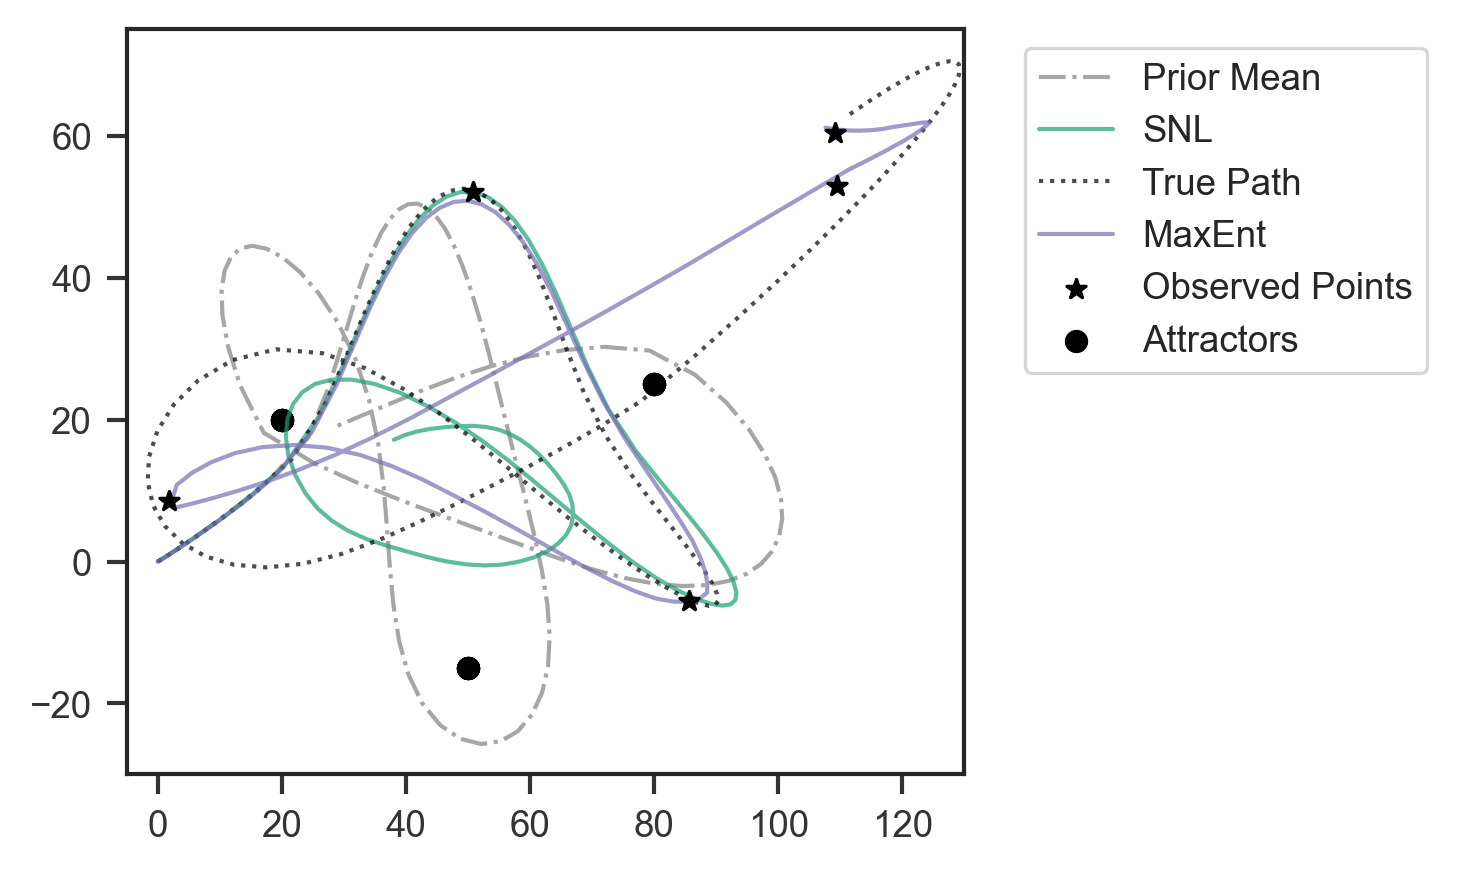

In [14]:
alpha_val = 0.7
fig, axes = plt.subplots(figsize=(5,3), dpi=300)

# plot the observation points
axes.scatter(observed_points[:,0], observed_points[:,1],
             color='black', zorder=10, marker='*', label='Observed Points')

# plot the trajectory generated by prior means
sim.set_traj(prior_means_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Greys').reversed(),
              color='grey',
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-.',
              linewidth=1,
              label='Prior Mean')

# plot the SNL mean trajectory
sim.set_traj(mean_snl_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Greens').reversed(),
              color=colors[0],
              fade_lines=False,
              linewidth=1,
              alpha=alpha_val,
              label='SNL')

# plot the true trajectory
sim.set_traj(true_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Reds').reversed(),
              color='black',
              fade_lines=False,
              alpha=alpha_val,
              linestyle=':',
              linewidth=1,
              label='True Path',
              label_attractors=False)

# plot the maxent average trajectory
sim.set_traj(maxent_avg_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Oranges').reversed(),
              color=colors[2],
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-',
              linewidth=1,
              label='MaxEnt',
              label_attractors=True)

# set limits manually
axes.set_xlim(-5, 130)
axes.set_ylim(-30, 75)

plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.))
plt.tight_layout()

#plt.savefig('paths_compare.png')
#plt.savefig('paths_compare.svg')
plt.show()

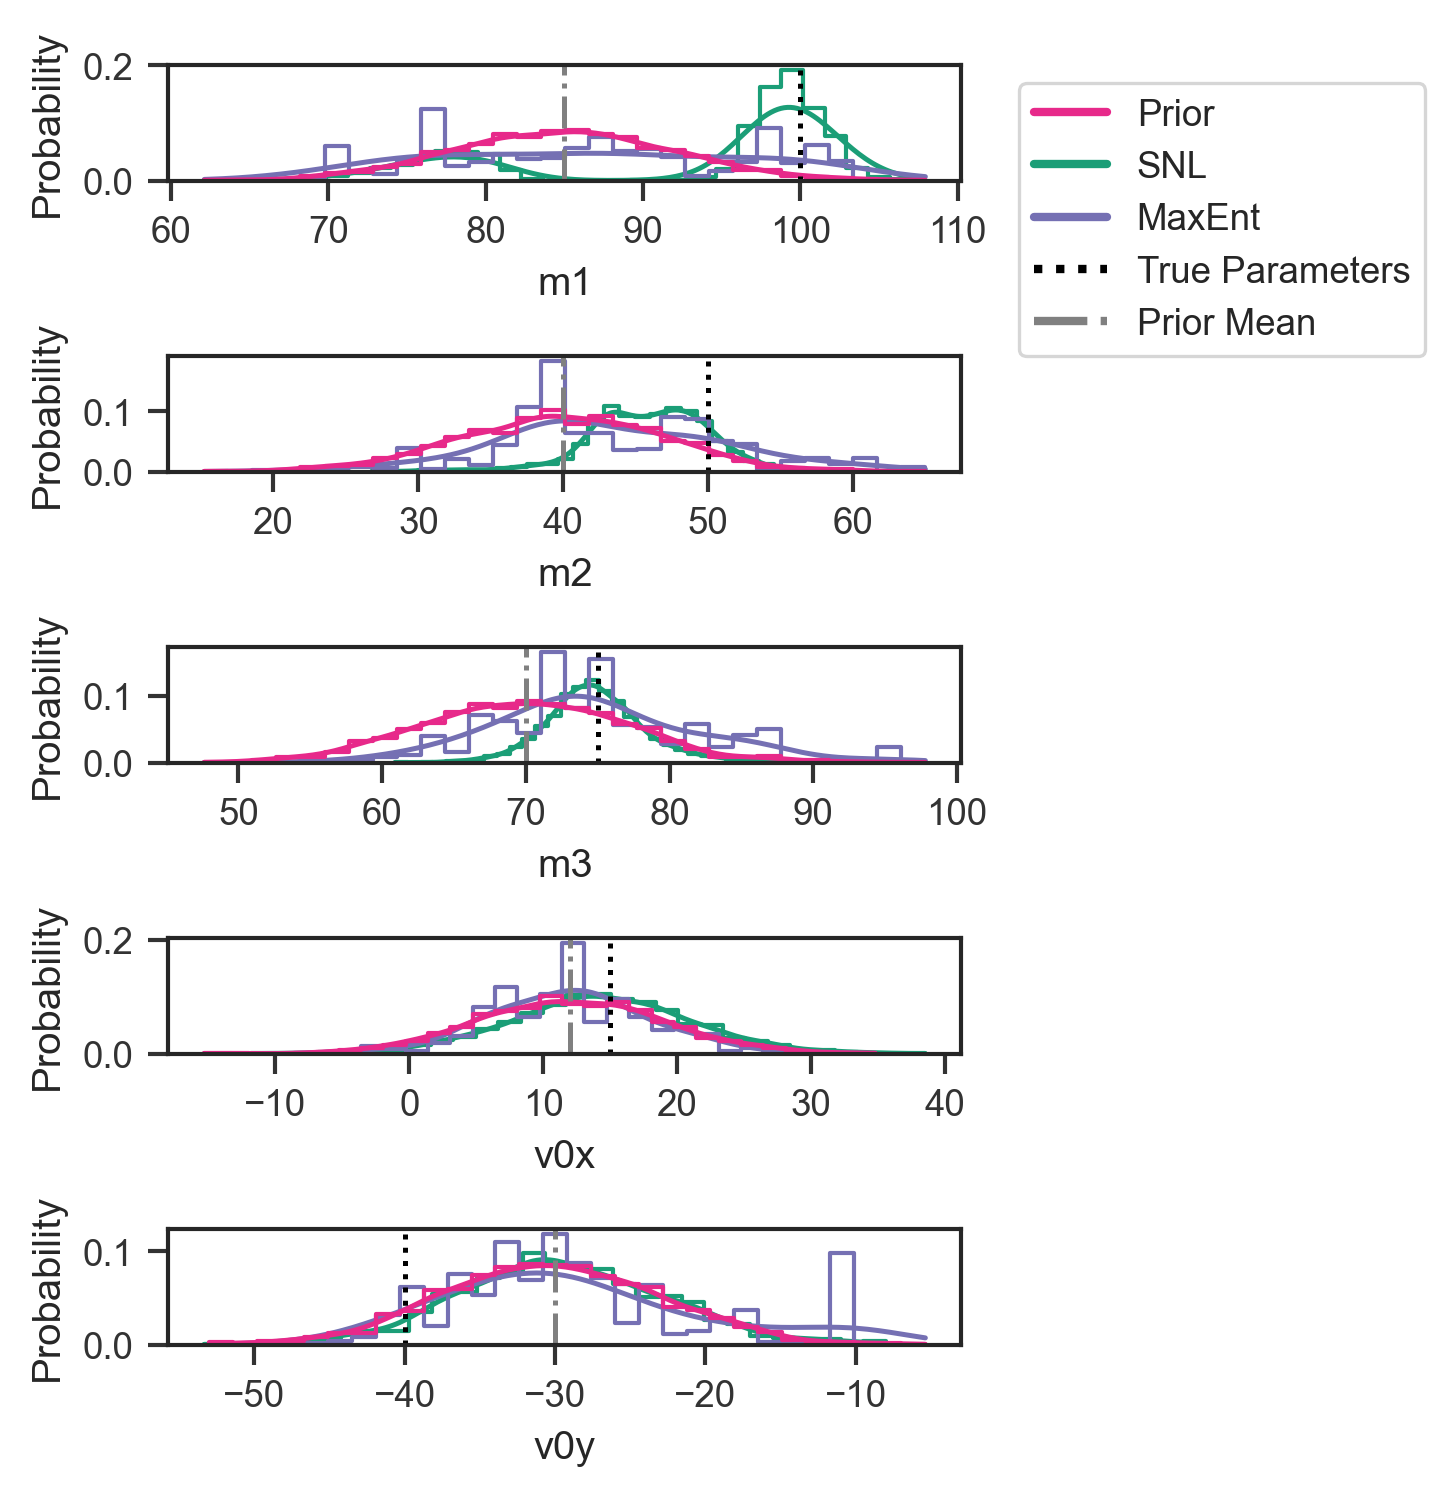

In [15]:
# set up KDE plotting of posteriors
column_names = ['m1', 'm2', 'm3', 'v0x', 'v0y']

snl_dist = np.array(snl_data)
snl_frame = pd.DataFrame(snl_dist, columns = column_names)

maxent_dist = np.load('maxent_prior_samples.npy')
maxent_frame = pd.DataFrame(maxent_dist, columns = column_names)

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5,5), dpi=300, sharex=False)

# iterate over the five parameters
n_bins = 30
for i, key in enumerate(column_names):
    sns.histplot(data=snl_frame, x=key, ax=axes[i], color=colors[0],
                 stat='probability', element='step', kde=True, fill=False,
                 bins=n_bins, lw=1.0)
    sns.histplot(data=maxent_frame, x=key, ax=axes[i], color=colors[2],
                 stat='probability', element='step', kde=True, fill=False,
                 bins=n_bins, weights=maxent_weights, lw=1.0)
    sns.histplot(data=maxent_frame, x=key, ax=axes[i], color=colors[3],
                 stat='probability', element='step', kde=True, fill=False,
                 bins=n_bins, lw=1.0)
    axes[i].axvline(prior_means[i], ls='-.', color='grey', lw=1.2)
    axes[i].axvline(true_params[i], ls=':', color='black', lw=1.2)
    axes[i].set_xlabel(key)
    
# custom lines object for making legend
custom_lines = [Line2D([0], [0], color=colors[3], lw=2),
                Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[2], lw=2),
                Line2D([0], [0], color='black', ls=':', lw=2),
                Line2D([0], [0], color='grey', ls='-.', lw=2)]
axes[0].legend(custom_lines, ['Prior', 'SNL',  'MaxEnt', 'True Parameters', 'Prior Mean'],
               loc='upper left', bbox_to_anchor=(1.05,1.))
plt.tight_layout()

#plt.savefig('posterior_compare.png')
#plt.savefig('posterior_compare.svg')
plt.show()

In [16]:
# calculating cross-entropy values
def get_crossent(prior_samples, posterior_samples, epsilon = 1e-7, x_range=[-100, 100], nbins=40, post_weights=None):
    prior_dists = []
    posterior_dists = []
    crossents = []
    for i in range(5):
        prior_dist, _ = np.histogram(prior_samples[:,i], bins=nbins, range=x_range, density=True)
        prior_dists.append(prior_dist)
        posterior_dist, _ = np.histogram(posterior_samples[:,i], bins=nbins, range=x_range, density=True, weights=post_weights)
        posterior_dists.append(posterior_dist)
        crossents.append( np.log(posterior_dist+epsilon) * (prior_dist + epsilon) )
    return -np.sum(crossents)

snl_prior = np.random.multivariate_normal(mean=prior_means, cov=np.eye(5)*50, size=snl_dist.shape[0])
snl_crossent = get_crossent(snl_prior, snl_dist)

maxent_prior = np.random.multivariate_normal(prior_means, np.eye(5)*50, size=2048)
maxent_crossent = get_crossent(maxent_prior, maxent_prior, post_weights=maxent_weights)

print(f'CROSS-ENTROPY:\nSNL: {snl_crossent}\nMaxEnt: {maxent_crossent}')

crossent_values = [snl_crossent, maxent_crossent]
np.savetxt('crossent_values.txt', np.array(crossent_values), header='SNL, MaxEnt')

CROSS-ENTROPY:
SNL: 4.377024064259781
MaxEnt: 3.4363923365118247


## MaxEnt With Variational

In [125]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [133]:
x = np.array(prior_means, dtype=np.float32)
y = np.array(prior_cov, dtype=np.float32)
i = tf.keras.Input((1,))
l = maxent.TrainableInputLayer(x)(i)
d = tfp.layers.DistributionLambda(lambda x: tfd.MultivariateNormalFullCovariance(
    loc=x, covariance_matrix=y))(l)
model = maxent.ParameterJoint([lambda x: x], inputs=i, outputs=[d])
model.compile(tf.keras.optimizers.Adam(0.1))
model.summary()
model(tf.constant([1., 2., 3., 4., 5.]))

Model: "parameter_joint_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
trainable_input_layer_2 (Tra (None, 5)                 5         
_________________________________________________________________
distribution_lambda_2 (Distr multiple                  0         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


<tfp.distributions.MultivariateNormalFullCovariance 'parameter_joint_2_distribution_lambda_2_MultivariateNormalFullCovariance' batch_shape=[5] event_shape=[5] dtype=float32>

In [134]:
print(model.sample(1, True))

([<tf.Tensor: shape=(1, 1, 5), dtype=float32, numpy=
array([[[ 91.76605 ,  37.57191 ,  76.288506,   8.228722, -16.532295]]],
      dtype=float32)>], [<tf.Tensor: shape=(1, 1, 5), dtype=float32, numpy=
array([[[ 91.76605 ,  37.57191 ,  76.288506,   8.228722, -16.532295]]],
      dtype=float32)>], [<tfp.distributions.MultivariateNormalFullCovariance 'parameter_joint_2_distribution_lambda_2_MultivariateNormalFullCovariance' batch_shape=[1] event_shape=[5] dtype=float32>])


In [168]:
def simulate(x):
        '''params_list should be: m1, m2, m3, v0[0], v0[1] in that order'''
        params_list = x[0,0,:]
        m1, m2, m3 = float(params_list[0]), float(params_list[1]), float(params_list[2])
        v0 = np.array([params_list[3], params_list[4]], dtype=np.float64)
        this_sim = GravitySimulator(m1, m2, m3, v0, random_noise=False)
        this_traj = this_sim.run()
        # need to be 1D to jive with hypermaxent setup
        return(np.array([this_traj.flatten()]))


In [169]:
print(get_observation_points(noisy_traj))
def get_observation_points_from_flat(flat_traj):
    recovered_traj = flat_traj.reshape([-1,2])
    return get_observation_points(recovered_traj).flatten()
print(get_observation_points_from_flat(noisy_traj.flatten()))

[[ 50.73233156  52.03546097]
 [ 85.66440807  -5.50210995]
 [  1.78997266   8.51447241]
 [109.39080972  52.99067167]
 [109.19999104  60.34926203]]
[ 50.73233156  52.03546097  85.66440807  -5.50210995   1.78997266
   8.51447241 109.39080972  52.99067167 109.19999104  60.34926203]


In [170]:
r = []
true_points = get_observation_points(noisy_traj)
true_points_flat = true_points.flatten()
for i, point in enumerate(true_points_flat):
    r.append(maxent.Restraint(lambda x: get_observation_points_from_flat(x)[i],
                              point,
                              maxent.EmptyPrior()))
hme_model = maxent.HyperMaxentModel(r, model, simulate)
hme_model.compile(tf.keras.optimizers.Adam(1e-4), 'mean_squared_error')

In [172]:
hme_results = hme_model.fit(epochs=2000, sample_batch_size=1, final_batch_multiplier=100)

Epoch 1/2000
1/1 [==============================] - 0s 348ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 2/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 3/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 4/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 5/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 6/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 7/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 8/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 9/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00

1/1 [==============================] - 0s 4ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 73/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 74/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 75/2000
1/1 [==============================] - 0s 4ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 76/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 77/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 78/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 79/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 80/2000
1/1 [==============================] - 0s 4ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 

1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 145/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 146/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 147/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 148/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 149/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 150/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 151/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 152/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 217/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 218/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 219/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 220/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 221/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 222/2000
1/1 [==============================] - ETA: 0s - loss: 2137.3560 - weight-entropy: 0.0000e+0 - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 223/2000
1/1 [==============================] - 0s 4ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 224/2000
1/1 [==============================] - 0

1/1 [==============================] - 0s 4ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 289/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 290/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 291/2000
1/1 [==============================] - 0s 4ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 292/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 293/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 294/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 295/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 296/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 361/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 362/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 363/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 364/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 365/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 366/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 367/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 368/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 433/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 434/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 435/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 436/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 437/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 438/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 439/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 440/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 505/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 506/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 507/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 508/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 509/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 510/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 511/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 512/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 577/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 578/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 579/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 580/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 581/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 582/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 583/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 584/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 649/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 650/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 651/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 652/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 653/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 654/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 655/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 656/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 721/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 722/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 723/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 724/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 725/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 726/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 727/2000
1/1 [==============================] - ETA: 0s - loss: 2137.3560 - weight-entropy: 0.0000e+0 - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 728/2000
1/1 [==============================] - 0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 792/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 793/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 794/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 795/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 796/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 797/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 798/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 799/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 864/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 865/2000
1/1 [==============================] - 0s 5ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 866/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 867/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 868/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 869/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 870/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 871/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 936/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 937/2000
1/1 [==============================] - 0s 4ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 938/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 939/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 940/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 941/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 942/2000
1/1 [==============================] - 0s 4ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 943/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1008/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1009/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1010/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1011/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1012/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1013/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1014/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1015/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0

1/1 [==============================] - 0s 4ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1080/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1081/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1082/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1083/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1084/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1085/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1086/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1087/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1152/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1153/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1154/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1155/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1156/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1157/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1158/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1159/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1224/2000
1/1 [==============================] - 0s 4ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1225/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1226/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1227/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1228/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1229/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1230/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1231/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1296/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1297/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1298/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1299/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1300/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1301/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1302/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1303/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1368/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1369/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1370/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1371/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1372/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1373/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1374/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1375/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1440/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1441/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1442/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1443/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1444/2000
1/1 [==============================] - 0s 5ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1445/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1446/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1447/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1512/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1513/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1514/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1515/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1516/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1517/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1518/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1519/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1584/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1585/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1586/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1587/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1588/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1589/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1590/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1591/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1656/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1657/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1658/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1659/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1660/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1661/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1662/2000
1/1 [==============================] - ETA: 0s - loss: 2137.3560 - weight-entropy: 0.0000e+0 - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1663/2000
1/1 [===========================

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1727/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1728/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1729/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1730/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1731/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1732/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1733/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1734/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1799/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1800/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1801/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1802/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1803/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1804/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1805/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1806/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1871/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1872/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1873/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1874/2000
1/1 [==============================] - 0s 6ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1875/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1876/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1877/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1878/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1943/2000
1/1 [==============================] - 0s 4ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1944/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1945/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1946/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1947/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1948/2000
1/1 [==============================] - 0s 3ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1949/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0.0000e+00
Epoch 1950/2000
1/1 [==============================] - 0s 2ms/step - loss: 2137.3560 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 15.1017
Epoch 20/2000
1/1 [==============================] - 0s 3ms/step - loss: 15.0243
Epoch 21/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.9530
Epoch 22/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.8878
Epoch 23/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.8284
Epoch 24/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.7745
Epoch 25/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.7259
Epoch 26/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.6822
Epoch 27/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.6431
Epoch 28/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.6082
Epoch 29/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.5772
Epoch 30/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.5497
Epoch 31/2000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 121/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 122/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 123/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 124/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 125/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 126/2000
1/1 [==============================] - 0s 6ms/step - loss: 14.3748
Epoch 127/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 128/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 129/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 130/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 131/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 132/2000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 221/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 222/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 223/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 224/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 225/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 226/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 227/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 228/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 229/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 230/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 231/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 232/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 320/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 321/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 322/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 323/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 324/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 325/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 326/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 327/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 328/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 329/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 330/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 331/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 419/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 420/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 421/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 422/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 423/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 424/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 425/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 426/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 427/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 428/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 429/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 430/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 519/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 520/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 521/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 522/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 523/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 524/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 525/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 526/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 527/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 528/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 529/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 530/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 619/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 620/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 621/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 622/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 623/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 624/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 625/2000
1/1 [==============================] - 0s 6ms/step - loss: 14.3748
Epoch 626/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 627/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 628/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 629/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 630/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 718/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 719/2000
1/1 [==============================] - ETA: 0s - loss: 14.37 - 0s 3ms/step - loss: 14.3748
Epoch 720/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 721/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 722/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 723/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 724/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 725/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 726/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 727/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 728/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 7

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 817/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 818/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 819/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 820/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 821/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 822/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 823/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 824/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 825/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 826/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 827/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 828/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 917/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 918/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 919/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 920/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 921/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 922/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 923/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 924/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 925/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 926/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 927/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 928/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1016/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1017/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1018/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1019/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1020/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1021/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1022/2000
1/1 [==============================] - 0s 7ms/step - loss: 14.3748
Epoch 1023/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1024/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1025/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1026/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1027/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1114/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1115/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1116/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1117/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1118/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1119/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1120/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1121/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1122/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1123/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1124/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1125/2000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1212/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1213/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1214/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1215/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1216/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1217/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1218/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1219/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1220/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1221/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1222/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1223/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1310/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1311/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1312/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1313/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1314/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1315/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1316/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1317/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1318/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1319/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1320/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1321/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1408/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1409/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1410/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1411/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1412/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1413/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1414/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1415/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1416/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1417/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1418/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1419/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1506/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1507/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1508/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1509/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1510/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1511/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1512/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1513/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1514/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1515/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1516/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1517/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1604/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1605/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1606/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1607/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1608/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1609/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1610/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1611/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1612/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1613/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1614/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1615/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1702/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1703/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1704/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1705/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1706/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1707/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1708/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1709/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1710/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1711/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1712/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1713/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1800/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1801/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1802/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1803/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1804/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1805/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1806/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1807/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1808/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1809/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1810/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1811/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1898/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1899/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1900/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1901/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1902/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1903/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1904/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1905/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1906/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1907/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1908/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1909/2000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1996/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1997/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1998/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1999/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 2000/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1/2000
1/1 [==============================] - 0s 6ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 2/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 3/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 4/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 5/2000
1/1 [==============================] - 0s 2ms/step - loss: 24

1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 70/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 71/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 72/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 73/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 74/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 75/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 76/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 77/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 142/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 143/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 144/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 145/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 146/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 147/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 148/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 149/2000
1/1 [==============================] - 0s 4ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 214/2000
1/1 [==============================] - 0s 4ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 215/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 216/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 217/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 218/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 219/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 220/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 221/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 6ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 286/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 287/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 288/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 289/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 290/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 291/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 292/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 293/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 358/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 359/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 360/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 361/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 362/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 363/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 364/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 365/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 430/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 431/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 432/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 433/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 434/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 435/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 436/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 437/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 502/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 503/2000
1/1 [==============================] - 0s 4ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 504/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 505/2000
1/1 [==============================] - 0s 4ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 506/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 507/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 508/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 509/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 574/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 575/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 576/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 577/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 578/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 579/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 580/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 581/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 646/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 647/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 648/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 649/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 650/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 651/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 652/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 653/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 718/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 719/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 720/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 721/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 722/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 723/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 724/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 725/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 790/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 791/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 792/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 793/2000
1/1 [==============================] - 0s 8ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 794/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 795/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 796/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 797/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 862/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 863/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 864/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 865/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 866/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 867/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 868/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 869/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 934/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 935/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 936/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 937/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 938/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 939/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 940/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 941/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1006/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1007/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1008/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1009/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1010/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1011/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1012/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1013/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1078/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1079/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1080/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1081/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1082/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1083/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1084/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1085/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1150/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1151/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1152/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1153/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1154/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1155/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1156/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1157/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1222/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1223/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1224/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1225/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1226/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1227/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1228/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1229/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1294/2000
1/1 [==============================] - 0s 4ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1295/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1296/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1297/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1298/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1299/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1300/2000
1/1 [==============================] - 0s 4ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1301/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1366/2000
1/1 [==============================] - 0s 5ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1367/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1368/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1369/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1370/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1371/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1372/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1373/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1438/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1439/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1440/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1441/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1442/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1443/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1444/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1445/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1510/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1511/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1512/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1513/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1514/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1515/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1516/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1517/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1582/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1583/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1584/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1585/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1586/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1587/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1588/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1589/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1654/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1655/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1656/2000
1/1 [==============================] - 0s 4ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1657/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1658/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1659/2000
1/1 [==============================] - 0s 4ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1660/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1661/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1726/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1727/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1728/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1729/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1730/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1731/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1732/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1733/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1798/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1799/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1800/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1801/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1802/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1803/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1804/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1805/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1869/2000
1/1 [==============================] - ETA: 0s - loss: 2428.3862 - weight-entropy: 0.0000e+0 - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1870/2000
1/1 [==============================] - 0s 4ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1871/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1872/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1873/2000
1/1 [==============================] - 0s 4ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1874/2000
1/1 [==============================] - 0s 4ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1875/2000
1/1 [==============================] - 0s 4ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1876/2000
1/1 [===========================

1/1 [==============================] - 0s 4ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1940/2000
1/1 [==============================] - 0s 11ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1941/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1942/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1943/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1944/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1945/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1946/2000
1/1 [==============================] - 0s 3ms/step - loss: 2428.3862 - weight-entropy: 0.0000e+00
Epoch 1947/2000
1/1 [==============================] - 0s 2ms/step - loss: 2428.3862 - weight-entropy: 

1/1 [==============================] - 0s 2ms/step - loss: 14.5475
Epoch 16/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.5141
Epoch 17/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.4862
Epoch 18/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.4633
Epoch 19/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.4446
Epoch 20/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.4296
Epoch 21/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.4178
Epoch 22/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.4086
Epoch 23/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.4015
Epoch 24/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3962
Epoch 25/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3922
Epoch 26/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3894
Epoch 27/2000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 117/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 118/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 119/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 120/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 121/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 122/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 123/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 124/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 125/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 126/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 127/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 128/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 217/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 218/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 219/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 220/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 221/2000
1/1 [==============================] - ETA: 0s - loss: 14.37 - 0s 3ms/step - loss: 14.3748
Epoch 222/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 223/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 224/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 225/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 226/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 227/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 2

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 316/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 317/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 318/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 319/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 320/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 321/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 322/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 323/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 324/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 325/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 326/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 327/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 415/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 416/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 417/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 418/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 419/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 420/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 421/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 422/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 423/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 424/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 425/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 426/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 514/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 515/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 516/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 517/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 518/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 519/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 520/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 521/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 522/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 523/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 524/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 525/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 614/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 615/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 616/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 617/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 618/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 619/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 620/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 621/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 622/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 623/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 624/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 625/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 714/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 715/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 716/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 717/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 718/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 719/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 720/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 721/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 722/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 723/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 724/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 725/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 814/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 815/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 816/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 817/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 818/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 819/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 820/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 821/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 822/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 823/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 824/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 825/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 913/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 914/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 915/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 916/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 917/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 918/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 919/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 920/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 921/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 922/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 923/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 924/2000
1/1 [===========

Epoch 1012/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1013/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1014/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1015/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1016/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1017/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1018/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1019/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1020/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1021/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1022/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1023/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoc

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1111/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1112/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1113/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1114/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1115/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1116/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1117/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1118/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1119/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1120/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1121/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1122/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1209/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1210/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1211/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1212/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1213/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1214/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1215/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1216/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1217/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1218/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1219/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1220/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1307/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1308/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1309/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1310/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1311/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1312/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1313/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1314/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1315/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1316/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1317/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1318/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1405/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1406/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1407/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1408/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1409/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1410/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1411/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1412/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1413/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1414/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1415/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1416/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1503/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1504/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1505/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1506/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1507/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1508/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1509/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1510/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1511/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1512/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1513/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1514/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1601/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1602/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1603/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1604/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1605/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1606/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1607/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1608/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1609/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1610/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1611/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1612/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1699/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1700/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1701/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1702/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1703/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1704/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1705/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1706/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1707/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1708/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1709/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1710/2000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1797/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1798/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1799/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1800/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1801/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1802/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1803/2000
1/1 [==============================] - ETA: 0s - loss: 14.37 - 0s 2ms/step - loss: 14.3748
Epoch 1804/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1805/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1806/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1807/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1895/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1896/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1897/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1898/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1899/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1900/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1901/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1902/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1903/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1904/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1905/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1906/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1993/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1994/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1995/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1996/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1997/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1998/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1999/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 2000/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 2/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 3/2000
1/1 [=============================

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 68/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 69/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 70/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 71/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 72/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 73/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 74/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 75/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 

1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 140/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 141/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 142/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 143/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 144/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 145/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 146/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 147/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 212/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 213/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 214/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 215/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 216/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 217/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 218/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 219/2000
1/1 [==============================] - ETA: 0s - loss: 2700.1960 - weight-entropy: 0.0000e+0 - 0

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 284/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 285/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 286/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 287/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 288/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 289/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 290/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 291/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 356/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 357/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 358/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 359/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 360/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 361/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 362/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 363/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 428/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 429/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 430/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 431/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 432/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 433/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 434/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 435/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 500/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 501/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 502/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 503/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 504/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 505/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 506/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 507/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 4ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 572/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 573/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 574/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 575/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 576/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 577/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 578/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 579/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 644/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 645/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 646/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 647/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 648/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 649/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 650/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 651/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 716/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 717/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 718/2000
1/1 [==============================] - 0s 5ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 719/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 720/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 721/2000
1/1 [==============================] - ETA: 0s - loss: 2700.1960 - weight-entropy: 0.0000e+0 - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 722/2000
1/1 [==============================] - 0s 4ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 723/2000
1/1 [==============================] - 0

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 788/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 789/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 790/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 791/2000
1/1 [==============================] - 0s 4ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 792/2000
1/1 [==============================] - 0s 5ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 793/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 794/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 795/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 860/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 861/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 862/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 863/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 864/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 865/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 866/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 867/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 932/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 933/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 934/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 935/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 936/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 937/2000
1/1 [==============================] - 0s 4ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 938/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 939/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1004/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1005/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1006/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1007/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1008/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1009/2000
1/1 [==============================] - 0s 4ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1010/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1011/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1076/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1077/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1078/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1079/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1080/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1081/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1082/2000
1/1 [==============================] - 0s 4ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1083/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0

Epoch 1147/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1148/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1149/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1150/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1151/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1152/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1153/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1154/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1155/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - w

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1219/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1220/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1221/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1222/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1223/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1224/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1225/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1226/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1290/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1291/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1292/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1293/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1294/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1295/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1296/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1297/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1362/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1363/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1364/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1365/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1366/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1367/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1368/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1369/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1434/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1435/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1436/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1437/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1438/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1439/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1440/2000
1/1 [==============================] - 0s 13ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1441/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 

Epoch 1505/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1506/2000
1/1 [==============================] - 0s 5ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1507/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1508/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1509/2000
1/1 [==============================] - 0s 9ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1510/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1511/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1512/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1513/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - w

1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1577/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1578/2000
1/1 [==============================] - 0s 11ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1579/2000
1/1 [==============================] - 0s 4ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1580/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1581/2000
1/1 [==============================] - 0s 5ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1582/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1583/2000
1/1 [==============================] - 0s 4ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1584/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 

Epoch 1648/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1649/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1650/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1651/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1652/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1653/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1654/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1655/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1656/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - w

1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1720/2000
1/1 [==============================] - 0s 4ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1721/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1722/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1723/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1724/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1725/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1726/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1727/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1792/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1793/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1794/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1795/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1796/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1797/2000
1/1 [==============================] - ETA: 0s - loss: 2700.1960 - weight-entropy: 0.0000e+0 - 0s 8ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1798/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1799/2000
1/1 [===========================

1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1863/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1864/2000
1/1 [==============================] - 0s 4ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1865/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1866/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1867/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1868/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1869/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1870/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0

Epoch 1934/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1935/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1936/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1937/2000
1/1 [==============================] - 0s 5ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1938/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1939/2000
1/1 [==============================] - 0s 4ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1940/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1941/2000
1/1 [==============================] - 0s 3ms/step - loss: 2700.1960 - weight-entropy: 0.0000e+00
Epoch 1942/2000
1/1 [==============================] - 0s 2ms/step - loss: 2700.1960 - w

1/1 [==============================] - 0s 2ms/step - loss: 16.2691
Epoch 8/2000
1/1 [==============================] - 0s 2ms/step - loss: 15.9869
Epoch 9/2000
1/1 [==============================] - 0s 2ms/step - loss: 15.7277
Epoch 10/2000
1/1 [==============================] - 0s 2ms/step - loss: 15.4948
Epoch 11/2000
1/1 [==============================] - 0s 2ms/step - loss: 15.2897
Epoch 12/2000
1/1 [==============================] - 0s 2ms/step - loss: 15.1125
Epoch 13/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.9620
Epoch 14/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.8365
Epoch 15/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.7334
Epoch 16/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.6502
Epoch 17/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.5842
Epoch 18/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.5329
Epoch 19/2000
1/1 [=========================

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 109/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 110/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 111/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 112/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 113/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 114/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 115/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 116/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 117/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 118/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 119/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 120/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 209/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 210/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 211/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 212/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 213/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 214/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 215/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 216/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 217/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 218/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 219/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 220/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 309/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 310/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 311/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 312/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 313/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 314/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 315/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 316/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 317/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 318/2000
1/1 [==============================] - 0s 6ms/step - loss: 14.3748
Epoch 319/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 320/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 409/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 410/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 411/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 412/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 413/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 414/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 415/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 416/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 417/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 418/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 419/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 420/2000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 509/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 510/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 511/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 512/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 513/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 514/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 515/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 516/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 517/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 518/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 519/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 520/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 609/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 610/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 611/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 612/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 613/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 614/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 615/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 616/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 617/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 618/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 619/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 620/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 709/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 710/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 711/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 712/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 713/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 714/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 715/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 716/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 717/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 718/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 719/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 720/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 809/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 810/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 811/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 812/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 813/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 814/2000
1/1 [==============================] - ETA: 0s - loss: 14.37 - 0s 4ms/step - loss: 14.3748
Epoch 815/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 816/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 817/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 818/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 819/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 8

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 908/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 909/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 910/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 911/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 912/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 913/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 914/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 915/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 916/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 917/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 918/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 919/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1008/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1009/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1010/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1011/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1012/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1013/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1014/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1015/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1016/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1017/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1018/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1019/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1106/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1107/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1108/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1109/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1110/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1111/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1112/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1113/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1114/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1115/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1116/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1117/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1204/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1205/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1206/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1207/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1208/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1209/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1210/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1211/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1212/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1213/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1214/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1215/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1302/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1303/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1304/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1305/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1306/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1307/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1308/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1309/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1310/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1311/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1312/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1313/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1400/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1401/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1402/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1403/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1404/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1405/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1406/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1407/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1408/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1409/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1410/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1411/2000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1498/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1499/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1500/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1501/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1502/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1503/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1504/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1505/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1506/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1507/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1508/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1509/2000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1596/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1597/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1598/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1599/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1600/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1601/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1602/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1603/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1604/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1605/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1606/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1607/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1694/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1695/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1696/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1697/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1698/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1699/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1700/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1701/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1702/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1703/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1704/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1705/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1792/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1793/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1794/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1795/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1796/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1797/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1798/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1799/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1800/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1801/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1802/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1803/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1890/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1891/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1892/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1893/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1894/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1895/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1896/2000
1/1 [==============================] - 0s 10ms/step - loss: 14.3748
Epoch 1897/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1898/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1899/2000
1/1 [==============================] - 0s 6ms/step - loss: 14.3748
Epoch 1900/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1901/2000
1/1

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1988/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1989/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1990/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1991/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1992/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1993/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1994/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1995/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1996/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1997/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1998/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1999/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 64/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 65/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 66/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 67/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 68/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 69/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 70/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 71/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+

1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 136/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 137/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 138/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 139/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 140/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 141/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 142/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 143/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 

Epoch 207/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 208/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 209/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 210/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 211/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 212/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 213/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 214/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 215/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - w

1/1 [==============================] - 0s 4ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 279/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 280/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 281/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 282/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 283/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 284/2000
1/1 [==============================] - 0s 4ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 285/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 286/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 

1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 350/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 351/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 352/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 353/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 354/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 355/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 356/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 357/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 

Epoch 421/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 422/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 423/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 424/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 425/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 426/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 427/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 428/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 429/2000
1/1 [==============================] - 0s 4ms/step - loss: 11475.6328 - w

1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 493/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 494/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 495/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 496/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 497/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 498/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 499/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 500/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 

Epoch 564/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 565/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 566/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 567/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 568/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 569/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 570/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 571/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 572/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - w

1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 636/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 637/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 638/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 639/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 640/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 641/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 642/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 643/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 

Epoch 707/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 708/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 709/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 710/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 711/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 712/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 713/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 714/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 715/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - w

1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 779/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 780/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 781/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 782/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 783/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 784/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 785/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 786/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 

Epoch 850/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 851/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 852/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 853/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 854/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 855/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 856/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 857/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 858/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - w

1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 922/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 923/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 924/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 925/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 926/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 927/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 928/2000
1/1 [==============================] - 0s 4ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 929/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 

Epoch 993/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 994/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 995/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 996/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 997/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 998/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 999/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1000/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1001/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 -

1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1065/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1066/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1067/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1068/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1069/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1070/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1071/2000
1/1 [==============================] - ETA: 0s - loss: 11475.6328 - weight-entropy: 0.0000e+ - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1072/2000
1/1 [===================

1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1135/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1136/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1137/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1138/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1139/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1140/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1141/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1142/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-e

1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1206/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1207/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1208/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1209/2000
1/1 [==============================] - 0s 4ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1210/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1211/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1212/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1213/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-e

1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1277/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1278/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1279/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1280/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1281/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1282/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1283/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1284/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-e

1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1348/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1349/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1350/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1351/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1352/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1353/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1354/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1355/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-e

1/1 [==============================] - 0s 4ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1419/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1420/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1421/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1422/2000
1/1 [==============================] - ETA: 0s - loss: 11475.6328 - weight-entropy: 0.0000e+ - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1423/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1424/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1425/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1426/2000
1/1 [===================

1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1489/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1490/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1491/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1492/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1493/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1494/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1495/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1496/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-e

1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1560/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1561/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1562/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1563/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1564/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1565/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1566/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1567/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-e

1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1630/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1631/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1632/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1633/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1634/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1635/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1636/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1637/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-e

1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1701/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1702/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1703/2000
1/1 [==============================] - 0s 5ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1704/2000
1/1 [==============================] - 0s 4ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1705/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1706/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1707/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1708/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-e

1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1772/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1773/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1774/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1775/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1776/2000
1/1 [==============================] - 0s 4ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1777/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1778/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1779/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-e

1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1843/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1844/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1845/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1846/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1847/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1848/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1849/2000
1/1 [==============================] - 0s 4ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1850/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-e

1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1914/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1915/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1916/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1917/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1918/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1919/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1920/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1921/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-e

1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1985/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1986/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1987/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1988/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1989/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1990/2000
1/1 [==============================] - 0s 3ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1991/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-entropy: 0.0000e+00
Epoch 1992/2000
1/1 [==============================] - 0s 2ms/step - loss: 11475.6328 - weight-e

1/1 [==============================] - 0s 3ms/step - loss: 14.3751
Epoch 79/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3751
Epoch 80/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3751
Epoch 81/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3751
Epoch 82/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3751
Epoch 83/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3751
Epoch 84/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3751
Epoch 85/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3750
Epoch 86/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3750
Epoch 87/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3750
Epoch 88/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3750
Epoch 89/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3750
Epoch 90/2000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 179/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 180/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 181/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 182/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 183/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 184/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 185/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 186/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 187/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 188/2000
1/1 [==============================] - ETA: 0s - loss: 14.37 - 0s 3ms/step - loss: 14.3748
Epoch 189/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 278/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 279/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 280/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 281/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 282/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 283/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 284/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 285/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 286/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 287/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 288/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 289/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 378/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 379/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 380/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 381/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 382/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 383/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 384/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 385/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 386/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 387/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 388/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 389/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 478/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 479/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 480/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 481/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 482/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 483/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 484/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 485/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 486/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 487/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 488/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 489/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 578/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 579/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 580/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 581/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 582/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 583/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 584/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 585/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 586/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 587/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 588/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 589/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 678/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 679/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 680/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 681/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 682/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 683/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 684/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 685/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 686/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 687/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 688/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 689/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 777/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 778/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 779/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 780/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 781/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 782/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 783/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 784/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 785/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 786/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 787/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 788/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 877/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 878/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 879/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 880/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 881/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 882/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 883/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 884/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 885/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 886/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 887/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 888/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 977/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 978/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 979/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 980/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 981/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 982/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 983/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 984/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 985/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 986/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 987/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 988/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1076/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1077/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1078/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1079/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1080/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1081/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1082/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1083/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1084/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1085/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1086/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1087/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1174/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1175/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1176/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1177/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1178/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1179/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1180/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1181/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1182/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1183/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1184/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1185/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1272/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1273/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1274/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1275/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1276/2000
1/1 [==============================] - 0s 9ms/step - loss: 14.3748
Epoch 1277/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1278/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1279/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1280/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1281/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1282/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1283/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1370/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1371/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1372/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1373/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1374/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1375/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1376/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1377/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1378/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1379/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1380/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1381/2000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1468/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1469/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1470/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1471/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1472/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1473/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1474/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1475/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1476/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1477/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1478/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1479/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1566/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1567/2000
1/1 [==============================] - 0s 13ms/step - loss: 14.3748
Epoch 1568/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1569/2000
1/1 [==============================] - 0s 8ms/step - loss: 14.3748
Epoch 1570/2000
1/1 [==============================] - 0s 6ms/step - loss: 14.3748
Epoch 1571/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1572/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1573/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1574/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1575/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1576/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1577/2000
1/1

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1664/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1665/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1666/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1667/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1668/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1669/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1670/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1671/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1672/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1673/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1674/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1675/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1762/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1763/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1764/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1765/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1766/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1767/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1768/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1769/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1770/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1771/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1772/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1773/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1860/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1861/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1862/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1863/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1864/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1865/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1866/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1867/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1868/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1869/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1870/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1871/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1958/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1959/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1960/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1961/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1962/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1963/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1964/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1965/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1966/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1967/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1968/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1969/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 42/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 43/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 44/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 45/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 46/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 47/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 48/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 49/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 114/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 115/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 116/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 117/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 118/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 119/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 120/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 121/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 185/2000
1/1 [==============================] - 0s 5ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 186/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 187/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 188/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 189/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 190/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 191/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 192/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 

Epoch 256/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 257/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 258/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 259/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 260/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 261/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 262/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 263/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 264/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - w

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 328/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 329/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 330/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 331/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 332/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 333/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 334/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 335/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 

Epoch 399/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 400/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 401/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 402/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 403/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 404/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 405/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 406/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 407/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - w

1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 471/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 472/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 473/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 474/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 475/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 476/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 477/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 478/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 

Epoch 542/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 543/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 544/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 545/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 546/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 547/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 548/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 549/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 550/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - w

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 614/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 615/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 616/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 617/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 618/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 619/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 620/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 621/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 

Epoch 685/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 686/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 687/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 688/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 689/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 690/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 691/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 692/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 693/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - w

1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 757/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 758/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 759/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 760/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 761/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 762/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 763/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 764/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 828/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 829/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 830/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 831/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 832/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 833/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 834/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 835/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 

Epoch 899/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 900/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 901/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 902/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 903/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 904/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 905/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 906/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 907/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - w

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 971/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 972/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 973/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 974/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 975/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 976/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 977/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 978/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1042/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1043/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1044/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1045/2000
1/1 [==============================] - 0s 6ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1046/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1047/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1048/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1049/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1113/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1114/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1115/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1116/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1117/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1118/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1119/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1120/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1184/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1185/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1186/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1187/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1188/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1189/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1190/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1191/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1254/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1255/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1256/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1257/2000
1/1 [==============================] - 0s 9ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1258/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1259/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1260/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1261/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1325/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1326/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1327/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1328/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1329/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1330/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1331/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1332/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1395/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1396/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1397/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1398/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1399/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1400/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1401/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1402/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1466/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1467/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1468/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1469/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1470/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1471/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1472/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1473/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1537/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1538/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1539/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1540/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1541/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1542/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1543/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1544/2000
1/1 [==============================] - 0s 6ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1608/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1609/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1610/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1611/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1612/2000
1/1 [==============================] - 0s 4ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1613/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1614/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1615/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1679/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1680/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1681/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1682/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1683/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1684/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1685/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1686/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1750/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1751/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1752/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1753/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1754/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1755/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1756/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1757/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1821/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1822/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1823/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1824/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1825/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1826/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1827/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1828/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1892/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1893/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1894/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1895/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1896/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1897/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1898/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1899/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1963/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1964/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1965/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1966/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1967/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1968/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1969/2000
1/1 [==============================] - 0s 3ms/step - loss: 19014.7793 - weight-entropy: 0.0000e+00
Epoch 1970/2000
1/1 [==============================] - 0s 2ms/step - loss: 19014.7793 - weight-e

1/1 [==============================] - 0s 2ms/step - loss: 14.3841
Epoch 48/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3828
Epoch 49/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3817
Epoch 50/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3807
Epoch 51/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3799
Epoch 52/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3792
Epoch 53/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3786
Epoch 54/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3781
Epoch 55/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3777
Epoch 56/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3774
Epoch 57/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3771
Epoch 58/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3768
Epoch 59/2000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 148/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 149/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 150/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 151/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 152/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 153/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 154/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 155/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 156/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 157/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 158/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 159/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 247/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 248/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 249/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 250/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 251/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 252/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 253/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 254/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 255/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 256/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 257/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 258/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 347/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 348/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 349/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 350/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 351/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 352/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 353/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 354/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 355/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 356/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 357/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 358/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 447/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 448/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 449/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 450/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 451/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 452/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 453/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 454/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 455/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 456/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 457/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 458/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 547/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 548/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 549/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 550/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 551/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 552/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 553/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 554/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 555/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 556/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 557/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 558/2000
1/1 [===========

Epoch 646/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 647/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 648/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 649/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 650/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 651/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 652/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 653/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 654/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 655/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 656/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 657/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 658/2000
1

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 746/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 747/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 748/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 749/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 750/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 751/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 752/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 753/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 754/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 755/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 756/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 757/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 846/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 847/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 848/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 849/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 850/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 851/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 852/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 853/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 854/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 855/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 856/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 857/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 946/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 947/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 948/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 949/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 950/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 951/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 952/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 953/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 954/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 955/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 956/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 957/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1045/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1046/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1047/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1048/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1049/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1050/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1051/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1052/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1053/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1054/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1055/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1056/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1143/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1144/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1145/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1146/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1147/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1148/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1149/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1150/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1151/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1152/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1153/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1154/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1241/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1242/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1243/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1244/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1245/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1246/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1247/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1248/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1249/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1250/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1251/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1252/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1339/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1340/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1341/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1342/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1343/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1344/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1345/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1346/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1347/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1348/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1349/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1350/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1437/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1438/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1439/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1440/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1441/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1442/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1443/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1444/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1445/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1446/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1447/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1448/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1535/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1536/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1537/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1538/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1539/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1540/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1541/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1542/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1543/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1544/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1545/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1546/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1633/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1634/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1635/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1636/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1637/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1638/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1639/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1640/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1641/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1642/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1643/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1644/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1731/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1732/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1733/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1734/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1735/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1736/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1737/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1738/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1739/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1740/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1741/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1742/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1829/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1830/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1831/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1832/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1833/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1834/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1835/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1836/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1837/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1838/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1839/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1840/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1927/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1928/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1929/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1930/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1931/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1932/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1933/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1934/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1935/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1936/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1937/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1938/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 19/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 20/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 21/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 22/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 23/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 24/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 25/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 26/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 92/2000
1/1 [==============================] - 0s 6ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 93/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 94/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 95/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 96/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 97/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 98/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 99/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 

1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 164/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 165/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 166/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 167/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 168/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 169/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 170/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 171/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 236/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 237/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 238/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 239/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 240/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 241/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 242/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 243/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 308/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 309/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 310/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 311/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 312/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 313/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 314/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 315/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 380/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 381/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 382/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 383/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 384/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 385/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 386/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 387/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 452/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 453/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 454/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 455/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 456/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 457/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 458/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 459/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 524/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 525/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 526/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 527/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 528/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 529/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 530/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 531/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 596/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 597/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 598/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 599/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 600/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 601/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 602/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 603/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 668/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 669/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 670/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 671/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 672/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 673/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 674/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 675/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 740/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 741/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 742/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 743/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 744/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 745/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 746/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 747/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 812/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 813/2000
1/1 [==============================] - 0s 4ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 814/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 815/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 816/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 817/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 818/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 819/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 884/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 885/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 886/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 887/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 888/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 889/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 890/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 891/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 956/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 957/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 958/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 959/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 960/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 961/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 962/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 963/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1028/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1029/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1030/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1031/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1032/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1033/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1034/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1035/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1100/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1101/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1102/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1103/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1104/2000
1/1 [==============================] - 0s 5ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1105/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1106/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1107/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1171/2000
1/1 [==============================] - 0s 4ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1172/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1173/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1174/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1175/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1176/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1177/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1178/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1243/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1244/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1245/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1246/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1247/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1248/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1249/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1250/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1315/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1316/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1317/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1318/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1319/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1320/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1321/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1322/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1386/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1387/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1388/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1389/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1390/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1391/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1392/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1393/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1458/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1459/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1460/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1461/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1462/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1463/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1464/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1465/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1530/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1531/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1532/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1533/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1534/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1535/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1536/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1537/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1602/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1603/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1604/2000
1/1 [==============================] - 0s 4ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1605/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1606/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1607/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1608/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1609/2000
1/1 [==============================] - 0s 4ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1673/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1674/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1675/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1676/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1677/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1678/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1679/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1680/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1744/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1745/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1746/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1747/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1748/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1749/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1750/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1751/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1816/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1817/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1818/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1819/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1820/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1821/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1822/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1823/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1888/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1889/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1890/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1891/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1892/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1893/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1894/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1895/2000
1/1 [==============================] - 0s 3ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1960/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1961/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1962/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1963/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1964/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1965/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1966/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0.0000e+00
Epoch 1967/2000
1/1 [==============================] - 0s 2ms/step - loss: 4155.4624 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 14.3797
Epoch 44/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3781
Epoch 45/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3772
Epoch 46/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3769
Epoch 47/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3769
Epoch 48/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3773
Epoch 49/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3778
Epoch 50/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3783
Epoch 51/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3789
Epoch 52/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3793
Epoch 53/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3797
Epoch 54/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3799
Epoch 55/2000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 144/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 145/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 146/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 147/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 148/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 149/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 150/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 151/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 152/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 153/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 154/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 155/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 244/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 245/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 246/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 247/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 248/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 249/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 250/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 251/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 252/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 253/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 254/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 255/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 344/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 345/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 346/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 347/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 348/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 349/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 350/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 351/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 352/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 353/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 354/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 355/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 444/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 445/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 446/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 447/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 448/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 449/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 450/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 451/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 452/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 453/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 454/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 455/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 544/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 545/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 546/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 547/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 548/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 549/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 550/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 551/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 552/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 553/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 554/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 555/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 644/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 645/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 646/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 647/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 648/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 649/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 650/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 651/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 652/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 653/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 654/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 655/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 744/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 745/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 746/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 747/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 748/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 749/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 750/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 751/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 752/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 753/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 754/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 755/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 844/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 845/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 846/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 847/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 848/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 849/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 850/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 851/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 852/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 853/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 854/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 855/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 944/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 945/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 946/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 947/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 948/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 949/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 950/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 951/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 952/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 953/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 954/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 955/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1043/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1044/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1045/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1046/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1047/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1048/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1049/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1050/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1051/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1052/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1053/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1054/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1141/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1142/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1143/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1144/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1145/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1146/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1147/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1148/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1149/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1150/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1151/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1152/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1239/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1240/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1241/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1242/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1243/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1244/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1245/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1246/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1247/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1248/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1249/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1250/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1337/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1338/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1339/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1340/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1341/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1342/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1343/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1344/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1345/2000
1/1 [==============================] - 0s 1ms/step - loss: 14.3748
Epoch 1346/2000
1/1 [==============================] - 0s 1ms/step - loss: 14.3748
Epoch 1347/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1348/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1435/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1436/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1437/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1438/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1439/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1440/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1441/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1442/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1443/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1444/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1445/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1446/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1532/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1533/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1534/2000
1/1 [==============================] - ETA: 0s - loss: 14.37 - 0s 2ms/step - loss: 14.3748
Epoch 1535/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1536/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1537/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1538/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1539/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1540/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1541/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1542/2000
1/1 [==============================] - 0s 6ms/step - loss: 14.3

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1630/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1631/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1632/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1633/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1634/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1635/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1636/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1637/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1638/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1639/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1640/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1641/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1728/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1729/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1730/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1731/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1732/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1733/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1734/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1735/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1736/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1737/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1738/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1739/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1826/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1827/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1828/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1829/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1830/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1831/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1832/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1833/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1834/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1835/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1836/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1837/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1924/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1925/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1926/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1927/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1928/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1929/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1930/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1931/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1932/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1933/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1934/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1935/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 17/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 18/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 19/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 20/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 21/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 22/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 23/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 24/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 90/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 91/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 92/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 93/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 94/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 95/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 96/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 97/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 162/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 163/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 164/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 165/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 166/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 167/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 168/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 169/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 234/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 235/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 236/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 237/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 238/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 239/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 240/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 241/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 306/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 307/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 308/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 309/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 310/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 311/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 312/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 313/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 378/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 379/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 380/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 381/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 382/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 383/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 384/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 385/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 450/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 451/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 452/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 453/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 454/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 455/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 456/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 457/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 522/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 523/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 524/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 525/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 526/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 527/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 528/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 529/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 594/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 595/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 596/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 597/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 598/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 599/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 600/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 601/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 666/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 667/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 668/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 669/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 670/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 671/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 672/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 673/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 738/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 739/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 740/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 741/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 742/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 743/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 744/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 745/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 810/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 811/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 812/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 813/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 814/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 815/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 816/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 817/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 882/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 883/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 884/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 885/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 886/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 887/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 888/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 889/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 954/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 955/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 956/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 957/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 958/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 959/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 960/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 961/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 4ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1026/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1027/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1028/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1029/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1030/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1031/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1032/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1033/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1098/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1099/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1100/2000
1/1 [==============================] - ETA: 0s - loss: 2822.7144 - weight-entropy: 0.0000e+0 - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1101/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1102/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1103/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1104/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1105/2000
1/1 [===========================

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1169/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1170/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1171/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1172/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1173/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1174/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1175/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1176/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1241/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1242/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1243/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1244/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1245/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1246/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1247/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1248/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1313/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1314/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1315/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1316/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1317/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1318/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1319/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1320/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1385/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1386/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1387/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1388/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1389/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1390/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1391/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1392/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1457/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1458/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1459/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1460/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1461/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1462/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1463/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1464/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1529/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1530/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1531/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1532/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1533/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1534/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1535/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1536/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1601/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1602/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1603/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1604/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1605/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1606/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1607/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1608/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1673/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1674/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1675/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1676/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1677/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1678/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1679/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1680/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1745/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1746/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1747/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1748/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1749/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1750/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1751/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1752/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1817/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1818/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1819/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1820/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1821/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1822/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1823/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1824/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1889/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1890/2000
1/1 [==============================] - 0s 4ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1891/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1892/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1893/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1894/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1895/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1896/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1961/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1962/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1963/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1964/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1965/2000
1/1 [==============================] - 0s 3ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1966/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1967/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0.0000e+00
Epoch 1968/2000
1/1 [==============================] - 0s 2ms/step - loss: 2822.7144 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 14.3803
Epoch 45/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3800
Epoch 46/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3797
Epoch 47/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3792
Epoch 48/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3788
Epoch 49/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3783
Epoch 50/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3778
Epoch 51/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3773
Epoch 52/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3769
Epoch 53/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3765
Epoch 54/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3762
Epoch 55/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3760
Epoch 56/2000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 145/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 146/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 147/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 148/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 149/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 150/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 151/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 152/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 153/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 154/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 155/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 156/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 245/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 246/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 247/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 248/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 249/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 250/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 251/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 252/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 253/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 254/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 255/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 256/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 345/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 346/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 347/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 348/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 349/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 350/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 351/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 352/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 353/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 354/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 355/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 356/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 445/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 446/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 447/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 448/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 449/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 450/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 451/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 452/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 453/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 454/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 455/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 456/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 545/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 546/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 547/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 548/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 549/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 550/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 551/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 552/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 553/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 554/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 555/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 556/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 644/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 645/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 646/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 647/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 648/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 649/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 650/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 651/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 652/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 653/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 654/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 655/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 744/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 745/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 746/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 747/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 748/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 749/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 750/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 751/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 752/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 753/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 754/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 755/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 844/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 845/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 846/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 847/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 848/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 849/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 850/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 851/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 852/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 853/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 854/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 855/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 944/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 945/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 946/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 947/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 948/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 949/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 950/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 951/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 952/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 953/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 954/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 955/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1043/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1044/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1045/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1046/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1047/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1048/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1049/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1050/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1051/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1052/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1053/2000
1/1 [==============================] - 0s 1ms/step - loss: 14.3748
Epoch 1054/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1141/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1142/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1143/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1144/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1145/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1146/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1147/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1148/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1149/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1150/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1151/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1152/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1239/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1240/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1241/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1242/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1243/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1244/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1245/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1246/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1247/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1248/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1249/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1250/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1337/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1338/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1339/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1340/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1341/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1342/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1343/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1344/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1345/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1346/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1347/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1348/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1435/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1436/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1437/2000
1/1 [==============================] - ETA: 0s - loss: 14.37 - 0s 2ms/step - loss: 14.3748
Epoch 1438/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1439/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1440/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1441/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1442/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1443/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1444/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1445/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1532/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1533/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1534/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1535/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1536/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1537/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1538/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1539/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1540/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1541/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1542/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1543/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1630/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1631/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1632/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1633/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1634/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1635/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1636/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1637/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1638/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1639/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1640/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1641/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1728/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1729/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1730/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1731/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1732/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1733/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1734/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1735/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1736/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1737/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1738/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1739/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1826/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1827/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1828/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1829/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1830/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1831/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1832/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1833/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1834/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1835/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1836/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1837/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1924/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1925/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1926/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1927/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1928/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1929/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1930/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1931/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1932/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1933/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1934/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1935/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 16/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 17/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 18/2000
1/1 [==============================] - 0s 4ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 19/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 20/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 21/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 22/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 23/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 87/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 88/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 89/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 90/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 91/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 92/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 93/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 94/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 157/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 158/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 159/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 160/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 161/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 162/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 163/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 164/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 227/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 228/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 229/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 230/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 231/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 232/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 233/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 234/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 297/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 298/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 299/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 300/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 301/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 302/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 303/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 304/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 

1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 367/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 368/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 369/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 370/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 371/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 372/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 373/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 374/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 

1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 437/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 438/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 439/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 440/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 441/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 442/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 443/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 444/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 507/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 508/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 509/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 510/2000
1/1 [==============================] - 0s 1ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 511/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 512/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 513/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 514/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 

1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 577/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 578/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 579/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 580/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 581/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 582/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 583/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 584/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 647/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 648/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 649/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 650/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 651/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 652/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 653/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 654/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 717/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 718/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 719/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 720/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 721/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 722/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 723/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 724/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 787/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 788/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 789/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 790/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 791/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 792/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 793/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 794/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 

1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 857/2000
1/1 [==============================] - ETA: 0s - loss: 1580104.5000 - weight-entropy: 0.0000e+ - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 858/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 859/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 860/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 861/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 862/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 863/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 864/2000
1/1 [=========

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 927/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 928/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 929/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 930/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 931/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 932/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 933/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 934/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 997/2000
1/1 [==============================] - 0s 4ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 998/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 999/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1000/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1001/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1002/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1003/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1004/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.

1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1067/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1068/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1069/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1070/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1071/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1072/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1073/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1074/2000
1/1 [==============================] - 0s 2ms/step - loss: 15801

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1137/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1138/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1139/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1140/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1141/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1142/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1143/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1144/2000
1/1 [==============================] - 0s 3ms/step - loss: 15801

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1207/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1208/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1209/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1210/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1211/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1212/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1213/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1214/2000
1/1 [==============================] - 0s 3ms/step - loss: 15801

1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1277/2000
1/1 [==============================] - 0s 4ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1278/2000
1/1 [==============================] - 0s 4ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1279/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1280/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1281/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1282/2000
1/1 [==============================] - 0s 4ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1283/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1284/2000
1/1 [==============================] - 0s 2ms/step - loss: 15801

1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1347/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1348/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1349/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1350/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1351/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1352/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1353/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1354/2000
1/1 [==============================] - 0s 4ms/step - loss: 15801

1/1 [==============================] - 0s 4ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1417/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1418/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1419/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1420/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1421/2000
1/1 [==============================] - 0s 4ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1422/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1423/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1424/2000
1/1 [==============================] - 0s 3ms/step - loss: 15801

1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1487/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1488/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1489/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1490/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1491/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1492/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1493/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1494/2000
1/1 [==============================] - 0s 3ms/step - loss: 15801

1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1557/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1558/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1559/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1560/2000
1/1 [==============================] - 0s 4ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1561/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1562/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1563/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1564/2000
1/1 [==============================] - 0s 3ms/step - loss: 15801

1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1627/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1628/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1629/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1630/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1631/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1632/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1633/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1634/2000
1/1 [==============================] - 0s 2ms/step - loss: 15801

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1697/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1698/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1699/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1700/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1701/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1702/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1703/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1704/2000
1/1 [==============================] - 0s 2ms/step - loss: 15801

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1767/2000
1/1 [==============================] - ETA: 0s - loss: 1580104.5000 - weight-entropy: 0.0000e+ - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1768/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1769/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1770/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1771/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1772/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1773/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1774/2000
1/1 [=

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1836/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1837/2000
1/1 [==============================] - 0s 5ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1838/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1839/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1840/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1841/2000
1/1 [==============================] - 0s 4ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1842/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1843/2000
1/1 [==============================] - 0s 2ms/step - loss: 15801

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1906/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1907/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1908/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1909/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1910/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1911/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1912/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1913/2000
1/1 [==============================] - 0s 2ms/step - loss: 15801

1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1976/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1977/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1978/2000
1/1 [==============================] - 0s 3ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1979/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1980/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1981/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1982/2000
1/1 [==============================] - 0s 2ms/step - loss: 1580104.5000 - weight-entropy: 0.0000e+00
Epoch 1983/2000
1/1 [==============================] - 0s 2ms/step - loss: 15801

1/1 [==============================] - 0s 2ms/step - loss: 14.3828
Epoch 65/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3821
Epoch 66/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3815
Epoch 67/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3808
Epoch 68/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3802
Epoch 69/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3797
Epoch 70/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3791
Epoch 71/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3786
Epoch 72/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3781
Epoch 73/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3777
Epoch 74/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3773
Epoch 75/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3769
Epoch 76/2000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 165/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 166/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 167/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 168/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 169/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 170/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 171/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 172/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 173/2000
1/1 [==============================] - ETA: 0s - loss: 14.37 - 0s 6ms/step - loss: 14.3748
Epoch 174/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 175/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 264/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 265/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 266/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 267/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 268/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 269/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 270/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 271/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 272/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 273/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 274/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 275/2000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 364/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 365/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 366/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 367/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 368/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 369/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 370/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 371/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 372/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 373/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 374/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 375/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 464/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 465/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 466/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 467/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 468/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 469/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 470/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 471/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 472/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 473/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 474/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 475/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 564/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 565/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 566/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 567/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 568/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 569/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 570/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 571/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 572/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 573/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 574/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 575/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 663/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 664/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 665/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 666/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 667/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 668/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 669/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 670/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 671/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 672/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 673/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 674/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 762/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 763/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 764/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 765/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 766/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 767/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 768/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 769/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 770/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 771/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 772/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 773/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 862/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 863/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 864/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 865/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 866/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 867/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 868/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 869/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 870/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 871/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 872/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 873/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 962/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 963/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 964/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 965/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 966/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 967/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 968/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 969/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 970/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 971/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 972/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 973/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1061/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1062/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1063/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1064/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1065/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1066/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1067/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1068/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1069/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1070/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1071/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1072/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1159/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1160/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1161/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1162/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1163/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1164/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1165/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1166/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1167/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1168/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1169/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1170/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1257/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1258/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1259/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1260/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1261/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1262/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1263/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1264/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1265/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1266/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1267/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1268/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1355/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1356/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1357/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1358/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1359/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1360/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1361/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1362/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1363/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1364/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1365/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1366/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1453/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1454/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1455/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1456/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1457/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1458/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1459/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1460/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1461/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1462/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1463/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1464/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1551/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1552/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1553/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1554/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1555/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1556/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1557/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1558/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1559/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1560/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1561/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1562/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1649/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1650/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1651/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1652/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1653/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1654/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1655/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1656/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1657/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1658/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1659/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1660/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1747/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1748/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1749/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1750/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1751/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1752/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1753/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1754/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1755/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1756/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1757/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1758/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1845/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1846/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1847/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1848/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1849/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1850/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1851/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1852/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1853/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1854/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1855/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1856/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1943/2000
1/1 [==============================] - 0s 6ms/step - loss: 14.3748
Epoch 1944/2000
1/1 [==============================] - 0s 7ms/step - loss: 14.3748
Epoch 1945/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1946/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1947/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1948/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1949/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1950/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1951/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1952/2000
1/1 [==============================] - 0s 5ms/step - loss: 14.3748
Epoch 1953/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1954/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 31/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 32/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 33/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 34/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 35/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 36/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 37/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 38/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 

1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 104/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 105/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 106/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 107/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 108/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 109/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 110/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 111/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 176/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 177/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 178/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 179/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 180/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 181/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 182/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 183/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 248/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 249/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 250/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 251/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 252/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 253/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 254/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 255/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 320/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 321/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 322/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 323/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 324/2000
1/1 [==============================] - 0s 4ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 325/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 326/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 327/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 4ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 392/2000
1/1 [==============================] - 0s 8ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 393/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 394/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 395/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 396/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 397/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 398/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 399/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 464/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 465/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 466/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 467/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 468/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 469/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 470/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 471/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 536/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 537/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 538/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 539/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 540/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 541/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 542/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 543/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 608/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 609/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 610/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 611/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 612/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 613/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 614/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 615/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 680/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 681/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 682/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 683/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 684/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 685/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 686/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 687/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 752/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 753/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 754/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 755/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 756/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 757/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 758/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 759/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 824/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 825/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 826/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 827/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 828/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 829/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 830/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 831/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 896/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 897/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 898/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 899/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 900/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 901/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 902/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 903/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 968/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 969/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 970/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 971/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 972/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 973/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 974/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 975/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+0

1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1040/2000
1/1 [==============================] - 0s 6ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1041/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1042/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1043/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1044/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1045/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1046/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1047/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0

Epoch 1111/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1112/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1113/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1114/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1115/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1116/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1117/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1118/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1119/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - w

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1183/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1184/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1185/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1186/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1187/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1188/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1189/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1190/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1255/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1256/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1257/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1258/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1259/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1260/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1261/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1262/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1327/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1328/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1329/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1330/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1331/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1332/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1333/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1334/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1399/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1400/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1401/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1402/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1403/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1404/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1405/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1406/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1471/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1472/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1473/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1474/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1475/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1476/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1477/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1478/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1543/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1544/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1545/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1546/2000
1/1 [==============================] - 0s 4ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1547/2000
1/1 [==============================] - 0s 4ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1548/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1549/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1550/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1615/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1616/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1617/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1618/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1619/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1620/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1621/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1622/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1686/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1687/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1688/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1689/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1690/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1691/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1692/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1693/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1758/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1759/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1760/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1761/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1762/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1763/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1764/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1765/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0

1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1830/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1831/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1832/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1833/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1834/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1835/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1836/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1837/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1902/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1903/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1904/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1905/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1906/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1907/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1908/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1909/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1974/2000
1/1 [==============================] - 0s 2ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1975/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1976/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1977/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1978/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1979/2000
1/1 [==============================] - 0s 4ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1980/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0.0000e+00
Epoch 1981/2000
1/1 [==============================] - 0s 3ms/step - loss: 2628.9456 - weight-entropy: 0

1/1 [==============================] - 0s 2ms/step - loss: 14.3764
Epoch 64/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3762
Epoch 65/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3760
Epoch 66/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3758
Epoch 67/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3756
Epoch 68/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3754
Epoch 69/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3753
Epoch 70/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3753
Epoch 71/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3752
Epoch 72/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3752
Epoch 73/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3751
Epoch 74/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3751
Epoch 75/2000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 164/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 165/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 166/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 167/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 168/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 169/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 170/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 171/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 172/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 173/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 174/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 175/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 264/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 265/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 266/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 267/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 268/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 269/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 270/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 271/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 272/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 273/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 274/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 275/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 364/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 365/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 366/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 367/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 368/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 369/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 370/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 371/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 372/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 373/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 374/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 375/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 464/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 465/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 466/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 467/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 468/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 469/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 470/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 471/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 472/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 473/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 474/2000
1/1 [==============================] - 0s 8ms/step - loss: 14.3748
Epoch 475/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 564/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 565/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 566/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 567/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 568/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 569/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 570/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 571/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 572/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 573/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 574/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 575/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 664/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 665/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 666/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 667/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 668/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 669/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 670/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 671/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 672/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 673/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 674/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 675/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 764/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 765/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 766/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 767/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 768/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 769/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 770/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 771/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 772/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 773/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 774/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 775/2000
1/1 [===========

Epoch 863/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 864/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 865/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 866/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 867/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 868/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 869/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 870/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 871/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 872/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 873/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 874/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 875/2000
1

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 963/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 964/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 965/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 966/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 967/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 968/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 969/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 970/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 971/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 972/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 973/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 974/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1062/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1063/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1064/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1065/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1066/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1067/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1068/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1069/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1070/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1071/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1072/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1073/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1160/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1161/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1162/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1163/2000
1/1 [==============================] - 0s 1ms/step - loss: 14.3748
Epoch 1164/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1165/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1166/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1167/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1168/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1169/2000
1/1 [==============================] - 0s 1ms/step - loss: 14.3748
Epoch 1170/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1171/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1258/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1259/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1260/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1261/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1262/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1263/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1264/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1265/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1266/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1267/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1268/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1269/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1356/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1357/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1358/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1359/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1360/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1361/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1362/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1363/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1364/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1365/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1366/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1367/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1454/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1455/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1456/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1457/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1458/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1459/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1460/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1461/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1462/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1463/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1464/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1465/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1552/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1553/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1554/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1555/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1556/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1557/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1558/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1559/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1560/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1561/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1562/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1563/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1650/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1651/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1652/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1653/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1654/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1655/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1656/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1657/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1658/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1659/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1660/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1661/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1748/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1749/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1750/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1751/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1752/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1753/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1754/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1755/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1756/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1757/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1758/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1759/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1846/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1847/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1848/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1849/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1850/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1851/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1852/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1853/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1854/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1855/2000
1/1 [==============================] - 0s 4ms/step - loss: 14.3748
Epoch 1856/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1857/2000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1944/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1945/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1946/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1947/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1948/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1949/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1950/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1951/2000
1/1 [==============================] - 0s 3ms/step - loss: 14.3748
Epoch 1952/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1953/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1954/2000
1/1 [==============================] - 0s 2ms/step - loss: 14.3748
Epoch 1955/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 585162.2500 - weight-entropy: 0.1329
Epoch 32/2000
1/1 [==============================] - 0s 3ms/step - loss: 585351.3750 - weight-entropy: 0.1297
Epoch 33/2000
1/1 [==============================] - 0s 2ms/step - loss: 585515.9375 - weight-entropy: 0.1269
Epoch 34/2000
1/1 [==============================] - 0s 3ms/step - loss: 585659.5000 - weight-entropy: 0.1244
Epoch 35/2000
1/1 [==============================] - 0s 3ms/step - loss: 585784.8125 - weight-entropy: 0.1223
Epoch 36/2000
1/1 [==============================] - 0s 3ms/step - loss: 585894.3750 - weight-entropy: 0.1204
Epoch 37/2000
1/1 [==============================] - 0s 2ms/step - loss: 585990.3750 - weight-entropy: 0.1187
Epoch 38/2000
1/1 [==============================] - 0s 2ms/step - loss: 586074.5000 - weight-entropy: 0.1173
Epoch 39/2000
1/1 [==============================] - 0s 3ms/step - loss: 586148.5000 - weight-entropy: 0.1160
Epoch 40/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 586343.5000 - weight-entropy: 0.1125
Epoch 106/2000
1/1 [==============================] - 0s 4ms/step - loss: 586335.3750 - weight-entropy: 0.1127
Epoch 107/2000
1/1 [==============================] - 0s 3ms/step - loss: 586327.2500 - weight-entropy: 0.1128
Epoch 108/2000
1/1 [==============================] - 0s 2ms/step - loss: 586319.1875 - weight-entropy: 0.1130
Epoch 109/2000
1/1 [==============================] - 0s 3ms/step - loss: 586311.0625 - weight-entropy: 0.1131
Epoch 110/2000
1/1 [==============================] - 0s 3ms/step - loss: 586302.8125 - weight-entropy: 0.1132
Epoch 111/2000
1/1 [==============================] - 0s 3ms/step - loss: 586294.5625 - weight-entropy: 0.1134
Epoch 112/2000
1/1 [==============================] - 0s 4ms/step - loss: 586286.3750 - weight-entropy: 0.1135
Epoch 113/2000
1/1 [==============================] - 0s 3ms/step - loss: 586277.9375 - weight-entropy: 0.1137
Epoch 114/2000
1

1/1 [==============================] - 0s 3ms/step - loss: 585663.9375 - weight-entropy: 0.1244
Epoch 179/2000
1/1 [==============================] - 0s 3ms/step - loss: 585653.2500 - weight-entropy: 0.1245
Epoch 180/2000
1/1 [==============================] - 0s 5ms/step - loss: 585642.5000 - weight-entropy: 0.1247
Epoch 181/2000
1/1 [==============================] - 0s 6ms/step - loss: 585631.6250 - weight-entropy: 0.1249
Epoch 182/2000
1/1 [==============================] - 0s 2ms/step - loss: 585620.9375 - weight-entropy: 0.1251
Epoch 183/2000
1/1 [==============================] - 0s 3ms/step - loss: 585610.0000 - weight-entropy: 0.1253
Epoch 184/2000
1/1 [==============================] - 0s 3ms/step - loss: 585599.0000 - weight-entropy: 0.1255
Epoch 185/2000
1/1 [==============================] - 0s 3ms/step - loss: 585588.0625 - weight-entropy: 0.1257
Epoch 186/2000
1/1 [==============================] - 0s 2ms/step - loss: 585576.9375 - weight-entropy: 0.1258
Epoch 187/2000
1

1/1 [==============================] - 0s 3ms/step - loss: 584748.0625 - weight-entropy: 0.1398
Epoch 252/2000
1/1 [==============================] - 0s 2ms/step - loss: 584733.2500 - weight-entropy: 0.1401
Epoch 253/2000
1/1 [==============================] - 0s 2ms/step - loss: 584718.4375 - weight-entropy: 0.1403
Epoch 254/2000
1/1 [==============================] - 0s 3ms/step - loss: 584703.6250 - weight-entropy: 0.1406
Epoch 255/2000
1/1 [==============================] - 0s 3ms/step - loss: 584688.7500 - weight-entropy: 0.1408
Epoch 256/2000
1/1 [==============================] - 0s 3ms/step - loss: 584673.5625 - weight-entropy: 0.1411
Epoch 257/2000
1/1 [==============================] - 0s 3ms/step - loss: 584658.6250 - weight-entropy: 0.1413
Epoch 258/2000
1/1 [==============================] - 0s 3ms/step - loss: 584643.3750 - weight-entropy: 0.1416
Epoch 259/2000
1/1 [==============================] - 0s 2ms/step - loss: 584628.2500 - weight-entropy: 0.1418
Epoch 260/2000
1

1/1 [==============================] - 0s 3ms/step - loss: 583452.3750 - weight-entropy: 0.1609
Epoch 325/2000
1/1 [==============================] - 0s 3ms/step - loss: 583430.9375 - weight-entropy: 0.1612
Epoch 326/2000
1/1 [==============================] - 0s 2ms/step - loss: 583409.2500 - weight-entropy: 0.1616
Epoch 327/2000
1/1 [==============================] - 0s 2ms/step - loss: 583387.6250 - weight-entropy: 0.1619
Epoch 328/2000
1/1 [==============================] - 0s 3ms/step - loss: 583365.7500 - weight-entropy: 0.1623
Epoch 329/2000
1/1 [==============================] - 0s 2ms/step - loss: 583343.9375 - weight-entropy: 0.1626
Epoch 330/2000
1/1 [==============================] - 0s 3ms/step - loss: 583321.9375 - weight-entropy: 0.1630
Epoch 331/2000
1/1 [==============================] - 0s 3ms/step - loss: 583299.4375 - weight-entropy: 0.1633
Epoch 332/2000
1/1 [==============================] - 0s 3ms/step - loss: 583277.2500 - weight-entropy: 0.1637
Epoch 333/2000
1

1/1 [==============================] - 0s 4ms/step - loss: 581488.0625 - weight-entropy: 0.1913
Epoch 398/2000
1/1 [==============================] - 0s 3ms/step - loss: 581454.0625 - weight-entropy: 0.1918
Epoch 399/2000
1/1 [==============================] - 0s 2ms/step - loss: 581419.9375 - weight-entropy: 0.1923
Epoch 400/2000
1/1 [==============================] - 0s 3ms/step - loss: 581385.6250 - weight-entropy: 0.1928
Epoch 401/2000
1/1 [==============================] - 0s 3ms/step - loss: 581350.9375 - weight-entropy: 0.1934
Epoch 402/2000
1/1 [==============================] - 0s 3ms/step - loss: 581316.1875 - weight-entropy: 0.1939
Epoch 403/2000
1/1 [==============================] - 0s 3ms/step - loss: 581281.0625 - weight-entropy: 0.1944
Epoch 404/2000
1/1 [==============================] - 0s 2ms/step - loss: 581245.5000 - weight-entropy: 0.1949
Epoch 405/2000
1/1 [==============================] - 0s 2ms/step - loss: 581209.9375 - weight-entropy: 0.1955
Epoch 406/2000
1

1/1 [==============================] - 0s 3ms/step - loss: 578184.0625 - weight-entropy: 0.2392
Epoch 471/2000
1/1 [==============================] - 0s 4ms/step - loss: 578123.3750 - weight-entropy: 0.2400
Epoch 472/2000
1/1 [==============================] - 0s 3ms/step - loss: 578062.0625 - weight-entropy: 0.2409
Epoch 473/2000
1/1 [==============================] - 0s 2ms/step - loss: 578000.0000 - weight-entropy: 0.2417
Epoch 474/2000
1/1 [==============================] - 0s 3ms/step - loss: 577937.5625 - weight-entropy: 0.2426
Epoch 475/2000
1/1 [==============================] - 0s 4ms/step - loss: 577874.4375 - weight-entropy: 0.2435
Epoch 476/2000
1/1 [==============================] - 0s 3ms/step - loss: 577810.7500 - weight-entropy: 0.2444
Epoch 477/2000
1/1 [==============================] - 0s 3ms/step - loss: 577746.5000 - weight-entropy: 0.2453
Epoch 478/2000
1/1 [==============================] - 0s 2ms/step - loss: 577681.5000 - weight-entropy: 0.2462
Epoch 479/2000
1

1/1 [==============================] - 0s 2ms/step - loss: 571547.7500 - weight-entropy: 0.3263
Epoch 544/2000
1/1 [==============================] - 0s 2ms/step - loss: 571409.9375 - weight-entropy: 0.3280
Epoch 545/2000
1/1 [==============================] - 0s 3ms/step - loss: 571270.2500 - weight-entropy: 0.3297
Epoch 546/2000
1/1 [==============================] - 0s 3ms/step - loss: 571128.8125 - weight-entropy: 0.3314
Epoch 547/2000
1/1 [==============================] - 0s 2ms/step - loss: 570985.8125 - weight-entropy: 0.3332
Epoch 548/2000
1/1 [==============================] - 0s 2ms/step - loss: 570840.8125 - weight-entropy: 0.3350
Epoch 549/2000
1/1 [==============================] - 0s 3ms/step - loss: 570693.3750 - weight-entropy: 0.3368
Epoch 550/2000
1/1 [==============================] - 0s 2ms/step - loss: 570543.4375 - weight-entropy: 0.3386
Epoch 551/2000
1/1 [==============================] - 0s 3ms/step - loss: 570392.2500 - weight-entropy: 0.3405
Epoch 552/2000
1

1/1 [==============================] - 0s 3ms/step - loss: 550854.0625 - weight-entropy: 0.5510
Epoch 617/2000
1/1 [==============================] - 0s 2ms/step - loss: 550223.2500 - weight-entropy: 0.5571
Epoch 618/2000
1/1 [==============================] - 0s 4ms/step - loss: 549568.7500 - weight-entropy: 0.5634
Epoch 619/2000
1/1 [==============================] - 0s 3ms/step - loss: 548888.9375 - weight-entropy: 0.5699
Epoch 620/2000
1/1 [==============================] - 0s 3ms/step - loss: 548181.7500 - weight-entropy: 0.5766
Epoch 621/2000
1/1 [==============================] - 0s 3ms/step - loss: 547445.6250 - weight-entropy: 0.5835
Epoch 622/2000
1/1 [==============================] - 0s 3ms/step - loss: 546677.9375 - weight-entropy: 0.5907
Epoch 623/2000
1/1 [==============================] - 0s 3ms/step - loss: 545876.8125 - weight-entropy: 0.5982
Epoch 624/2000
1/1 [==============================] - 0s 3ms/step - loss: 545039.0625 - weight-entropy: 0.6060
Epoch 625/2000
1

1/1 [==============================] - 0s 3ms/step - loss: 479519.0312 - weight-entropy: 1.1188
Epoch 691/2000
1/1 [==============================] - 0s 3ms/step - loss: 473615.0000 - weight-entropy: 1.1599
Epoch 692/2000
1/1 [==============================] - 0s 3ms/step - loss: 466395.4062 - weight-entropy: 1.2096
Epoch 693/2000
1/1 [==============================] - 0s 3ms/step - loss: 457540.2812 - weight-entropy: 1.2696
Epoch 694/2000
1/1 [==============================] - 0s 3ms/step - loss: 446607.0312 - weight-entropy: 1.3426
Epoch 695/2000
1/1 [==============================] - 0s 3ms/step - loss: 432982.2812 - weight-entropy: 1.4322
Epoch 696/2000
1/1 [==============================] - 0s 3ms/step - loss: 415820.1875 - weight-entropy: 1.5432
Epoch 697/2000
1/1 [==============================] - 0s 2ms/step - loss: 393969.8438 - weight-entropy: 1.6824
Epoch 698/2000
1/1 [==============================] - 0s 3ms/step - loss: 365927.9688 - weight-entropy: 1.8583
Epoch 699/2000
1

Epoch 765/2000
1/1 [==============================] - 0s 3ms/step - loss: 1589.4661 - weight-entropy: 4.5760
Epoch 766/2000
1/1 [==============================] - 0s 2ms/step - loss: 1593.8906 - weight-entropy: 4.5763
Epoch 767/2000
1/1 [==============================] - 0s 3ms/step - loss: 1597.5245 - weight-entropy: 4.5765
Epoch 768/2000
1/1 [==============================] - 0s 2ms/step - loss: 1600.3353 - weight-entropy: 4.5767
Epoch 769/2000
1/1 [==============================] - 0s 3ms/step - loss: 1602.3235 - weight-entropy: 4.5768
Epoch 770/2000
1/1 [==============================] - 0s 2ms/step - loss: 1603.5157 - weight-entropy: 4.5769
Epoch 771/2000
1/1 [==============================] - 0s 2ms/step - loss: 1603.9602 - weight-entropy: 4.5769
Epoch 772/2000
1/1 [==============================] - 0s 3ms/step - loss: 1603.7217 - weight-entropy: 4.5769
Epoch 773/2000
1/1 [==============================] - 0s 2ms/step - loss: 1602.8712 - weight-entropy: 4.5769
Epoch 774/2000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 1548.7678 - weight-entropy: 4.5694
Epoch 841/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7594 - weight-entropy: 4.5694
Epoch 842/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7511 - weight-entropy: 4.5695
Epoch 843/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7444 - weight-entropy: 4.5695
Epoch 844/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7378 - weight-entropy: 4.5695
Epoch 845/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7314 - weight-entropy: 4.5695
Epoch 846/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7264 - weight-entropy: 4.5695
Epoch 847/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7219 - weight-entropy: 4.5695
Epoch 848/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7181 - weight-entropy: 4.5696
Epoch 849/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 915/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 916/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 917/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 918/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 919/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6996 - weight-entropy: 4.5697
Epoch 920/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 921/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 922/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6993 - weight-entropy: 4.5697
Epoch 923/2000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 990/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 991/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 992/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 993/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 994/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 995/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6993 - weight-entropy: 4.5697
Epoch 996/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 997/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7004 - weight-entropy: 4.5697
Epoch 998/2000
1/1 [==============

1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1064/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1065/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6996 - weight-entropy: 4.5697
Epoch 1066/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 1067/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1068/2000
1/1 [==============================] - 0s 4ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1069/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7003 - weight-entropy: 4.5697
Epoch 1070/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1071/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7002 - weight-entropy: 4.5697
Epoch 1072/2000
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 1548.6996 - weight-entropy: 4.5697
Epoch 1138/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6993 - weight-entropy: 4.5697
Epoch 1139/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6996 - weight-entropy: 4.5697
Epoch 1140/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7002 - weight-entropy: 4.5697
Epoch 1141/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1142/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1143/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6996 - weight-entropy: 4.5697
Epoch 1144/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1145/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 1146/2000
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1212/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1213/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1214/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1215/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6993 - weight-entropy: 4.5697
Epoch 1216/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1217/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 1218/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1219/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1220/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 1548.7003 - weight-entropy: 4.5697
Epoch 1286/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 1287/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6996 - weight-entropy: 4.5697
Epoch 1288/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6996 - weight-entropy: 4.5697
Epoch 1289/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1290/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1291/2000
1/1 [==============================] - 0s 4ms/step - loss: 1548.7003 - weight-entropy: 4.5697
Epoch 1292/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1293/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1294/2000
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1360/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6996 - weight-entropy: 4.5697
Epoch 1361/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1362/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1363/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 1364/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1365/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1366/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1367/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1368/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 1548.7002 - weight-entropy: 4.5697
Epoch 1434/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7003 - weight-entropy: 4.5697
Epoch 1435/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1436/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1437/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1438/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1439/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1440/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1441/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6993 - weight-entropy: 4.5697
Epoch 1442/2000
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1508/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1509/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1510/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1511/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1512/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6996 - weight-entropy: 4.5697
Epoch 1513/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1514/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1515/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 1516/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 1548.7002 - weight-entropy: 4.5697
Epoch 1582/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 1583/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 1584/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1585/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1586/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1587/2000
1/1 [==============================] - 0s 4ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1588/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1589/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1590/2000
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 1656/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1657/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1658/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1659/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1660/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1661/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 1662/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1663/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1664/2000
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1730/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1731/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1732/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1733/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1734/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1735/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1736/2000
1/1 [==============================] - 0s 4ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1737/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6996 - weight-entropy: 4.5697
Epoch 1738/2000
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 1548.7002 - weight-entropy: 4.5697
Epoch 1804/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1805/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1806/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6993 - weight-entropy: 4.5697
Epoch 1807/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 1808/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1809/2000
1/1 [==============================] - 0s 4ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1810/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1811/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6996 - weight-entropy: 4.5697
Epoch 1812/2000
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1878/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1879/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1880/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6993 - weight-entropy: 4.5697
Epoch 1881/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1882/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1883/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6996 - weight-entropy: 4.5697
Epoch 1884/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6993 - weight-entropy: 4.5697
Epoch 1885/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6996 - weight-entropy: 4.5697
Epoch 1886/2000
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1952/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1953/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1954/2000
1/1 [==============================] - 0s 2ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 1955/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1956/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6997 - weight-entropy: 4.5697
Epoch 1957/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7000 - weight-entropy: 4.5697
Epoch 1958/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.6998 - weight-entropy: 4.5697
Epoch 1959/2000
1/1 [==============================] - 0s 3ms/step - loss: 1548.7002 - weight-entropy: 4.5697
Epoch 1960/2000
1/1 [=====

In [173]:
hme_predicted_params = hme_model.weights[1]
hme_trajectory_weights= hme_model.traj_weights
variational_trajs = hme_model.trajs.reshape([hme_model.trajs.shape[0], -1, 2])
maxent_variational_avg_traj = np.sum(variational_trajs * hme_trajectory_weights[:, np.newaxis, np.newaxis], axis=0)
np.savetxt('maxent_variational_avg_traj.txt', maxent_variational_avg_traj)

In [174]:
# simulate traj generated by prior means
sim = GravitySimulator(prior_means[0], prior_means[1], prior_means[2], prior_means[3:])
prior_means_traj = sim.run()

In [175]:
mean_snl_traj = np.genfromtxt('mean_snl_traj.txt')
maxent_avg_traj = np.genfromtxt('maxent_avg_traj.txt')
maxent_variational_avg_traj = np.genfromtxt('maxent_variational_avg_traj.txt')

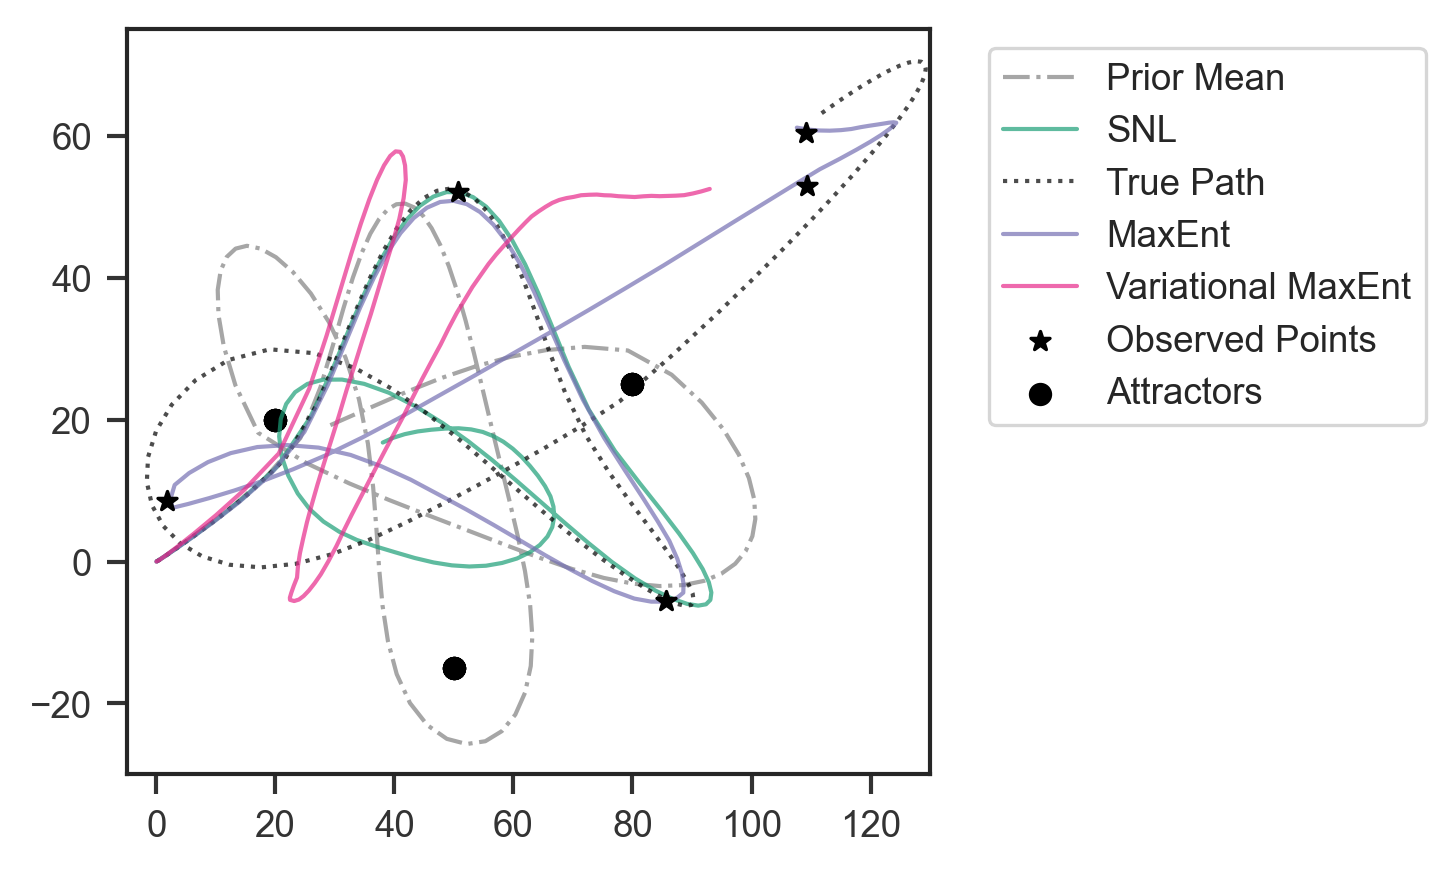

In [176]:
alpha_val = 0.7
fig, axes = plt.subplots(figsize=(5,3), dpi=300)

# plot the observation points
axes.scatter(observed_points[:,0], observed_points[:,1],
             color='black', zorder=10, marker='*', label='Observed Points')

# plot the trajectory generated by prior means
sim.set_traj(prior_means_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Greys').reversed(),
              color='grey',
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-.',
              linewidth=1,
              label='Prior Mean')

# plot the SNL mean trajectory
sim.set_traj(mean_snl_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Greens').reversed(),
              color=colors[0],
              fade_lines=False,
              linewidth=1,
              alpha=alpha_val,
              label='SNL')

# plot the true trajectory
sim.set_traj(true_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Reds').reversed(),
              color='black',
              fade_lines=False,
              alpha=alpha_val,
              linestyle=':',
              linewidth=1,
              label='True Path',
              label_attractors=False)

# plot the maxent average trajectory
sim.set_traj(maxent_avg_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Oranges').reversed(),
              color=colors[2],
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-',
              linewidth=1,
              label='MaxEnt',
              label_attractors=False)

# plot the maxent average trajectory
sim.set_traj(maxent_variational_avg_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Oranges').reversed(),
              color=colors[3],
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-',
              linewidth=1,
              label='Variational MaxEnt',
              label_attractors=True)

# set limits manually
axes.set_xlim(-5, 130)
axes.set_ylim(-30, 75)

plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.))
plt.tight_layout()

#plt.savefig('paths_compare.png')
#plt.savefig('paths_compare.svg')
plt.show()